# 1. 프로젝트 주제

### 어플평점 4점을 넘기위해 고려해야 할 사항에 대한 ML Project

* 해결하고자하는 문제 : 어플 고평점 예측
* 데이터 : 캐글의 2017년 7월 앱스토어 어플 통계데이터(7197개)
* 선정이유
 * 코로나시국, 비대면 사회에서 가장 중요한 도구는 휴대폰이다.
 * 사용할 Target 특성은 4.5이상 평점을 받은 binary data로 분류문제이다.
 * 어떤 특징에 따라 고평점을 받을 수 있는지 없는지, 예측하는 모델링을 할 것이다.

# 2. 라이브러리 및 데이터 불러오기

In [1]:
# 필요한 라이브러리들
import pandas as pd
import numpy as np
import graphviz
import matplotlib.pyplot as plt
import eli5

from category_encoders import OrdinalEncoder
from catboost import CatBoostClassifier

from eli5.sklearn import PermutationImportance

from imblearn.over_sampling import SMOTE, SMOTENC

from scipy.stats import boxcox, chi2_contingency

from sklearn.model_selection import train_test_split ,GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, f1_score, roc_curve, roc_auc_score
from sklearn import tree, preprocessing
from sklearn.utils import resample

from pandas_profiling import ProfileReport

from pdpbox.pdp import pdp_interact, pdp_interact_plot, pdp_isolate, pdp_plot

In [2]:
# https://www.kaggle.com/ramamet4/app-store-apple-data-set-10k-apps
# Data collection date (from API); July 2017

data = pd.read_csv('AppleStore.csv')
data.head()

,Unnamed: 0,id,track_name,size_bytes,currency,price,rating_count_tot,rating_count_ver,user_rating,user_rating_ver,ver,cont_rating,prime_genre,sup_devices.num,ipadSc_urls.num,lang.num,vpp_lic
0,1,281656475,PAC-MAN Premium,100788224,USD,3.99,21292,26,4.0,4.5,6.3.5,4+,Games,38,5,10,1
1,2,281796108,Evernote - stay organized,158578688,USD,0.00,161065,26,4.0,3.5,8.2.2,4+,Productivity,37,5,23,1
2,3,281940292,"WeatherBug - Local Weather, Radar, Maps, Alerts",100524032,USD,0.00,188583,2822,3.5,4.5,5.0.0,4+,Weather,37,5,3,1
3,4,282614216,"eBay: Best App to Buy, Sell, Save! Online Shop...",128512000,USD,0.00,262241,649,4.0,4.5,5.10.0,12+,Shopping,37,5,9,1
4,5,282935706,Bible,92774400,USD,0.00,985920,5320,4.5,5.0,7.5.1,4+,Reference,37,5,45,1


In [3]:
data.shape

(7197, 17)

### 특성별 설명(캐글)

"id" : 앱 ID  
"track_name": 앱 이름  
"size_bytes": 크기(바이트)  
"currency": 통화  
"price": 가격  
"ratingcounttot": 사용자 평가 수(모든 버전용)  
"ratingcountver": 사용자 평가 수(현재 버전용)  
"user_rating" : 평균 사용자 평가 값(모든 버전에 대해)  
"userratingver": 평균 사용자 평가 값(현재 버전의 경우)  
"ver" : 최신 버전 코드  
"cont_rating": 콘텐츠 등급  
"prime_genre": 기본 장르  
"sup_devices.num": 지원 장치 수  
"ipadSc_urls.num": 표현하기 위해 보여주는 스크린샷 수  
"lang.num": 지원되는 언어 수  
"vpp_lic": Vpp 장치기반 라이선스 사용  

# 3. 가설, 기준모델(Baseline Model), 평가지표설명

* 가설
    * 가설1 : 소프트웨어산업 중 가장 높은 비율을 차지하는 장르가 추천할 확률도 가장 높을 것이다
    * 가설2 : 가격의 영향력은 크기 때문에, 저렴하면 추천될 확률이 높을 것이다.
* 기준모델 및 평가지표설명
 * Target 특성은 어플 평점이 4점을 넘으면 True로 표시하는 새로운 특성을 생성.
 * Baseline Model로는 초기 최빈값인 0.9214에서 RandomForest의 AUC Score로 변경하였다.

# 4. EDA, Data Preprocessing

## 데이터를 아래와 같이 확인한 후, 함수로 전처리 및 EDA완료
###  1) 불필요한 특성제거 및 특성이름정리

* Currency특성에 다른 통화 유무 체크 => 전부 달러임을 확인  
data['currency'].unique()  

* 'Unnames: 0' 특성의 중복값여부체크 => 목차와 거의 동일하다 판단.(2개의 데이터가 다름)  
data.duplicated('vpp_lic').sort_values(ascending=True)  

* 컬럼의 단어 연결을 '.'을 '_'로 일관성있게 정리.


### 2) data 정리  

* 중복값여부체크 => 중복값이 데이터에 없음을 확인.  
data.duplicated().sort_values  

* 결측치유무확인->없음  
pd.isnull(data).sum()  

* ver 컬럼구성확인 -> 함수를 통해 int화함.  
data['ver'].value_counts()

* 어플이용 연령제한구성확인 -> 함수를 통해 int화함.  
data['cont_rating'].unique()  

* 장르별로 어플 구성 확인  
data['prime_genre'].value_counts()

* 대략적으로 데이터 구성내용 확인  
from pandas_profiling import ProfileReport  
profile = ProfileReport(data, minimal=True).to_notebook_iframe()  

* 불필요한 컬럼 일괄 삭제

In [4]:
# ver 특성의 int화 위한 작업

# 알파벳을 리스트화하기

import string
string.ascii_lowercase   # 'abcdefghijklmnopqrstuvwxyz'

alphabet=list(string.ascii_letters)

# ver 함수생성 (str로 이뤄진 버전을 인트화)
def ver(value):
    if value[0]=='v':
        value = int(value[1])
        return value
    elif value[0]=='V':
        value = int(value[1])
        return value
    elif (value[0]=='9') and (value[1]=='9'):
        value = int(value[5])                 # 9999.2->버전2로간주
        return value
    else:                                     
        value = value[0]                      
        if value in alphabet:                 # 문자열이 있으면 0으로 변환
            value = int(0)
            return value
        else:
            value = int(value)                # 문자열이 없다면 int로 변환
            return value

# int 함수생성
def int_make(value):
    return int(value)

In [5]:
# EDA AND Feature Engineering

def Feature_engineering(df):
    
    # 컬럼이름정리 ('.')->('_')
    df.columns = ['Unnamed: 0', 'id', 'track_name', 'size_bytes', 'currency', 'price', 'rating_count_tot',
                'rating_count_ver', 'user_rating_tot', 'user_rating_ver','ver', 'cont_rating', 'prime_genre', 
                'sup_devices_num', 'ipadSc_urls_num', 'lang_num', 'vpp_lic']

    # ver column int로 변경
    df['ver'] = df['ver'].apply(ver)
    
    # ver이 0이 아닌 것만 가져오기 =>value_counts()로 32개임을 확인했으나, 큰 의미가 없다 판단하여 제거함
    df = df[df.ver != 0]
    
    # cont_rating(연령) 안에 '+' 지우고, int화하기
    df['cont_rating'] = df['cont_rating'].str.split('+').str[0].apply(int_make)    
    
    # 'user_rating_tot'이 0이면 이상치로 봐서 해당 row 삭제 
    # (모든 버전에 대한 사용자평가인데, 어떤 회사라도 1개라도 있어야할텐데, 점수가 없다면 만들어진지 얼마 안된 어플일 것이라 간주하고 928개이지만 삭제함)
    df[df['user_rating_tot'] == 0.0]
    df = df[df.user_rating_tot > 0]
    
    # recommendation 타겟이 될 특성을 만들어 이진분류문제로 만듦.
    df['recommendation'] = (df['user_rating_tot']>4.5).astype(int) # True:1, False:0. 원하는 정수로 바꾸려면.replace({True:1,False:2})

    # 불필요한 5개 컬럼 삭제
    df = df.drop(['currency','Unnamed: 0', 'id','user_rating_ver', 'rating_count_ver'],axis=1)

    return df
data = Feature_engineering(data)
data.head()

,track_name,size_bytes,price,rating_count_tot,user_rating_tot,ver,cont_rating,prime_genre,sup_devices_num,ipadSc_urls_num,lang_num,vpp_lic,recommendation
0,PAC-MAN Premium,100788224,3.99,21292,4.0,6,4,Games,38,5,10,1,0
1,Evernote - stay organized,158578688,0.00,161065,4.0,8,4,Productivity,37,5,23,1,0
2,"WeatherBug - Local Weather, Radar, Maps, Alerts",100524032,0.00,188583,3.5,5,4,Weather,37,5,3,1,0
3,"eBay: Best App to Buy, Sell, Save! Online Shop...",128512000,0.00,262241,4.0,5,12,Shopping,37,5,9,1,0
4,Bible,92774400,0.00,985920,4.5,7,4,Reference,37,5,45,1,0


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6237 entries, 0 to 7196
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   track_name        6237 non-null   object 
 1   size_bytes        6237 non-null   int64  
 2   price             6237 non-null   float64
 3   rating_count_tot  6237 non-null   int64  
 4   user_rating_tot   6237 non-null   float64
 5   ver               6237 non-null   int64  
 6   cont_rating       6237 non-null   int64  
 7   prime_genre       6237 non-null   object 
 8   sup_devices_num   6237 non-null   int64  
 9   ipadSc_urls_num   6237 non-null   int64  
 10  lang_num          6237 non-null   int64  
 11  vpp_lic           6237 non-null   int64  
 12  recommendation    6237 non-null   int64  
dtypes: float64(2), int64(9), object(2)
memory usage: 682.2+ KB


In [7]:
# High Cardinality 확인. track_name의 카디널리티가 높다. (unique가 높다)  
data.describe(exclude='number').T.sort_values(by='unique')  

,count,unique,top,freq
prime_genre,6237,23,Games,3374
track_name,6237,6236,Mannequin Challenge,2


In [8]:
# 어플 이름이 같은 것이 있는지 확인
data[data['track_name'].duplicated(keep=False)==True]  

,track_name,size_bytes,price,rating_count_tot,user_rating_tot,ver,cont_rating,prime_genre,sup_devices_num,ipadSc_urls_num,lang_num,vpp_lic,recommendation
7092,Mannequin Challenge,109705216,0.0,668,3.0,1,9,Games,37,4,1,1,0
7128,Mannequin Challenge,59572224,0.0,105,4.0,1,4,Games,38,5,1,1,0


In [9]:
data.shape

(6237, 13)

In [10]:
# rating_count_tot이 적은것들 기준으로 삭제
data.drop(index=[7128], inplace=True)

In [11]:
data.shape

(6236, 13)

## 3) 데이터분포확인

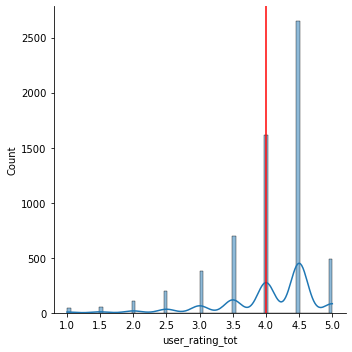

In [12]:
# 데이터 분포확인
import seaborn as sns
import matplotlib.pyplot as plt
sns.displot(data['user_rating_tot'],kde=True);
plt.axvline(4, color='red'); 

In [13]:
# 실제 평균점수보다 높은 어플은 몇개인가? True+False = 6268 => True와 False의 비율이 비슷해서 타겟 balance가 좋음.
print(data['recommendation'].value_counts())

print(data['recommendation'].value_counts(normalize=True))

0    5746
1     490
Name: recommendation, dtype: int64
0    0.921424
1    0.078576
Name: recommendation, dtype: float64


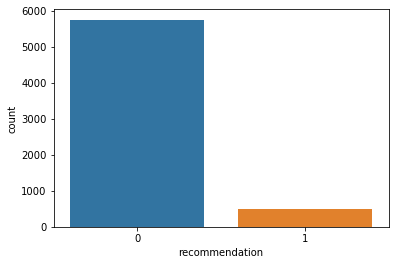

In [14]:
# recommendation의 imbalance 확인

%matplotlib inline
import seaborn as sns
sns.countplot(data['recommendation']);

* 최빈값인 0.9214를 초기 정확도 Baseline으로 잡아둔다.
* scale_pos_weight을 위해 ratio를 계산해둔다.
* Hyperparameter tuning만으로 부족하다면 smote도 고려해둔다.

In [15]:
# scale_pos_weight을 위한 ratio
ratio0 = data['recommendation'].value_counts(normalize=True)[0]
ratio0

0.9214239897370109

In [16]:
ratio1 = data['recommendation'].value_counts(normalize=True)[1]
ratio1

0.07857601026298909

In [17]:
ratio = ratio1/ratio0
ratio

0.08527671423599024

In [18]:
data['user_rating_tot'].value_counts()

4.5    2651
4.0    1619
3.5     695
5.0     490
3.0     379
2.5     196
2.0     106
1.5      56
1.0      44
Name: user_rating_tot, dtype: int64

In [19]:
data['rating_count_tot'].value_counts()

1         120
7          47
9          47
5          45
6          44
         ... 
47172       1
1155        1
7131        1
416736      1
1441        1
Name: rating_count_tot, Length: 3175, dtype: int64

In [20]:
# recommendation 특성 만들고 기반이 된 user_rating_tot, high cardinality인 track_name 제거
data.drop(['user_rating_tot','track_name'], axis=1, inplace=True)

# data reset_index
data = data.reset_index(drop=True)
data.head()

,size_bytes,price,rating_count_tot,ver,cont_rating,prime_genre,sup_devices_num,ipadSc_urls_num,lang_num,vpp_lic,recommendation
0,100788224,3.99,21292,6,4,Games,38,5,10,1,0
1,158578688,0.00,161065,8,4,Productivity,37,5,23,1,0
2,100524032,0.00,188583,5,4,Weather,37,5,3,1,0
3,128512000,0.00,262241,5,12,Shopping,37,5,9,1,0
4,92774400,0.00,985920,7,4,Reference,37,5,45,1,0


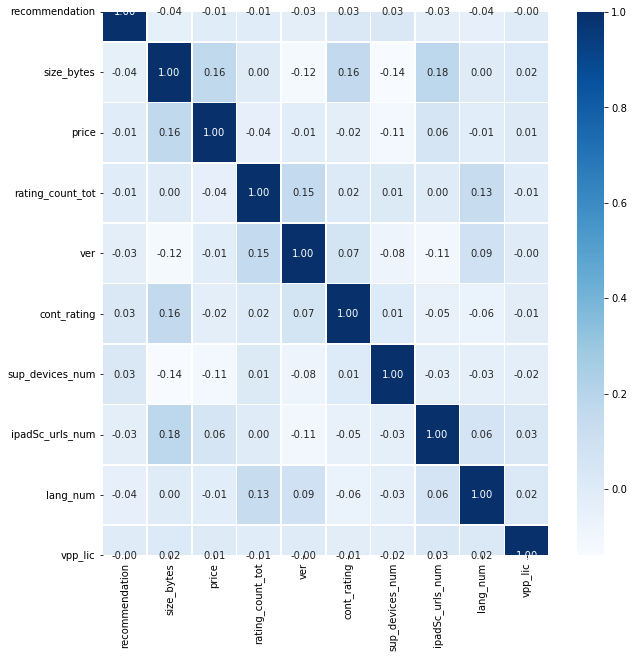

In [21]:
# 특성간 상관관계 시각화
new = data['recommendation']
trainn = data.drop(['recommendation'],axis=1)
trainn = pd.concat([new,trainn], axis=1)
plt.figure(figsize=(10,10))
sns.heatmap(data=trainn.corr(), annot=True, fmt='.2f', linewidths=.5, cmap='Blues');

* 특성들간 상관관계가 높음이 확인되지 않음.

In [22]:
# recommendation True로 나온 특성별 분포확인
recommendd = trainn[trainn.recommendation == True]
print(recommendd.shape)


(490, 11)


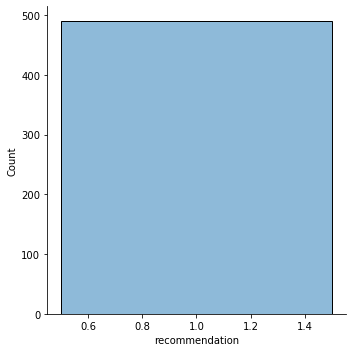

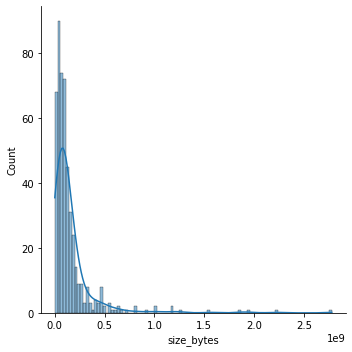

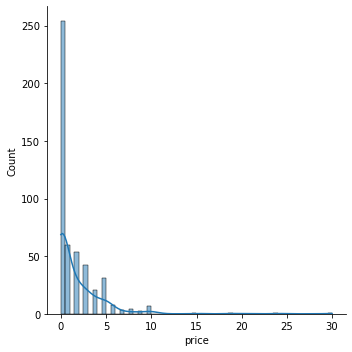

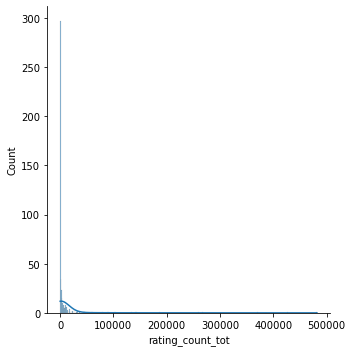

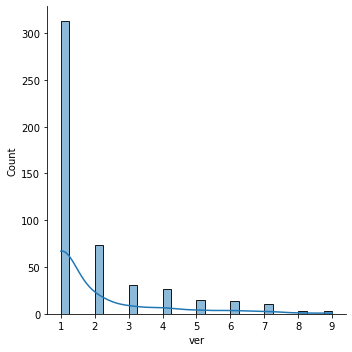

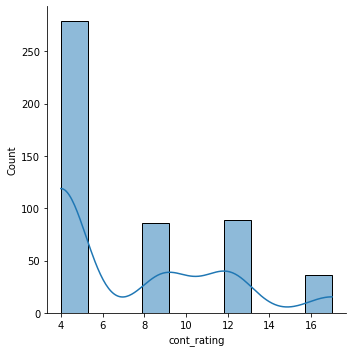

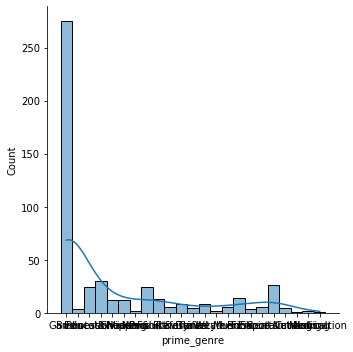

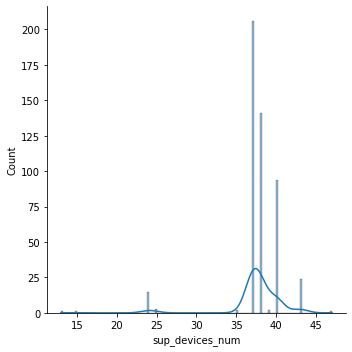

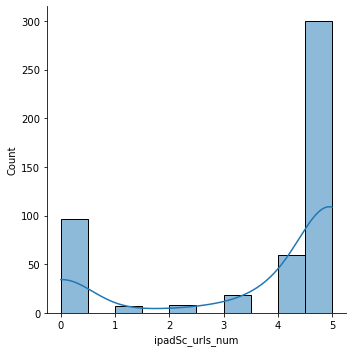

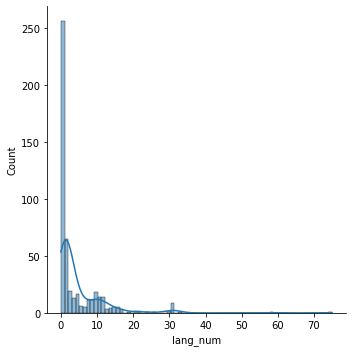

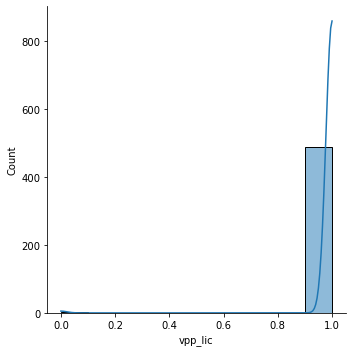

In [23]:
# recommendation True로 나온 특성별 분포확인

for i in trainn.columns:
    sns.displot(recommendd[i],kde=True) # kde : 커널밀도추정. 커널함수와 데이터를 바탕으로 연속성있는 확률밀도함수를 추정하는것.

### 가설1 소프트웨어산업 중 가장 높은 비율을 차지하는 장르가 추천할 확률도 가장 높을 것이다

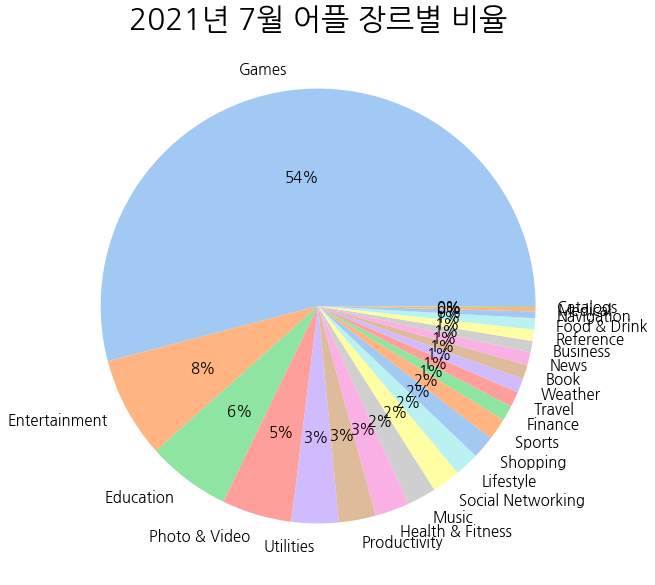

In [24]:
# 장르별 2021년 7월 어플비중비율

plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['font.size'] = 15

pie, ax = plt.subplots(figsize=[10,10])
plt.title("2021년 7월 어플 장르별 비율", fontsize=30);

# define data
data_by_genre=data['prime_genre'].value_counts()
labels=data['prime_genre'].value_counts().index

colors = sns.color_palette('pastel')

#create pie chart
plt.pie(data_by_genre, labels = labels, colors = colors, autopct='%.0f%%')
plt.show()

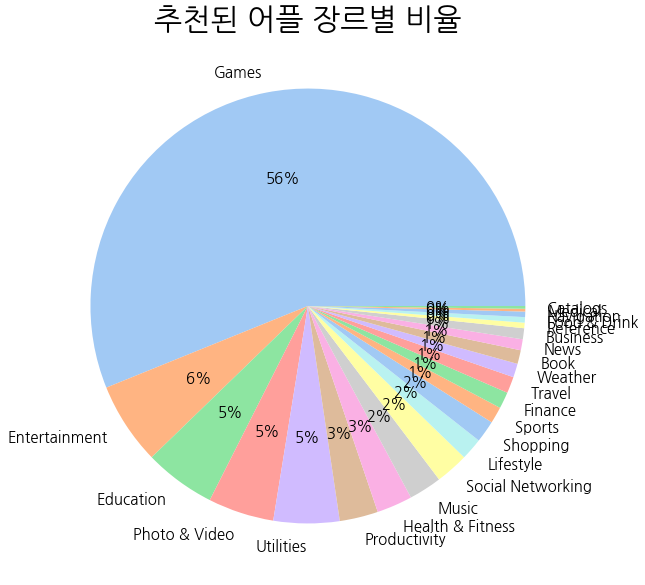

In [25]:
# 어플이용자 중 많은 비율이 게임이므로, 게임의 추천비율이 많을 것이다.

good = data[data.recommendation==1]

# 장르별 2021년 7월 어플비중비율

plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['font.size'] = 15

pie, ax = plt.subplots(figsize=[10,10])
plt.title("추천된 어플 장르별 비율", fontsize=30);

# define data
data_by_genre=good['prime_genre'].value_counts()
labels=data['prime_genre'].value_counts().index

colors = sns.color_palette('pastel')

#create pie chart
plt.pie(data_by_genre, labels = labels, colors = colors, autopct='%.0f%%')
plt.show()

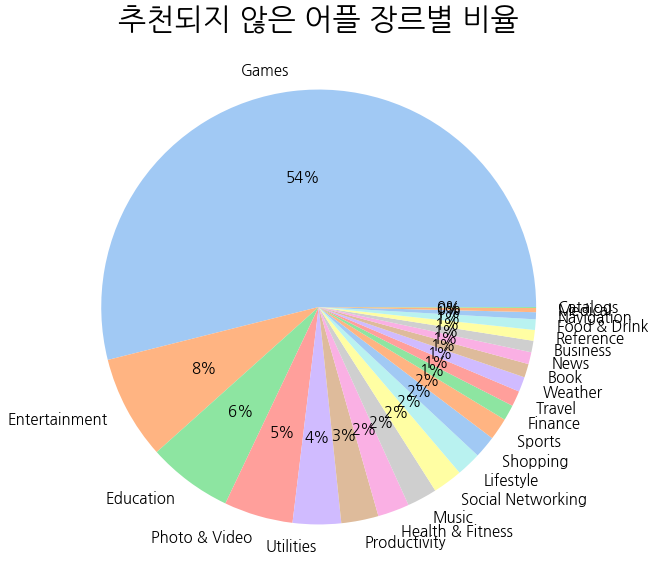

In [26]:
# 어플이용자 중 많은 비율이 게임이므로, 게임의 추천비율이 많을 것이다.

bad = data[data.recommendation==0]

# 장르별 2021년 7월 어플비중비율

plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['font.size'] = 15

pie, ax = plt.subplots(figsize=[10,10])
plt.title("추천되지 않은 어플 장르별 비율", fontsize=30);

# define data
data_by_genre=bad['prime_genre'].value_counts()
labels=data['prime_genre'].value_counts().index

colors = sns.color_palette('pastel')

#create pie chart
plt.pie(data_by_genre, labels = labels, colors = colors, autopct='%.0f%%')
plt.show()

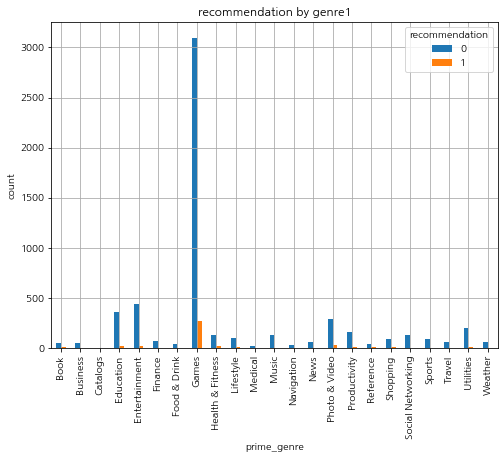

In [27]:
# 실제 총 데이터 중 추천비율을 보자 => 게임의 추천이 가장 높긴 하지만, 비추천은 훨씬 높음을 확인.

obs = pd.crosstab(data['prime_genre'],data['recommendation'])
obs

import matplotlib.pyplot as plt
%matplotlib inline

ax = obs.plot(kind='bar', title='recommendation by genre1', figsize=(8, 6))
ax.set_ylabel('count')
plt.grid(color='darkgray')
plt.show()

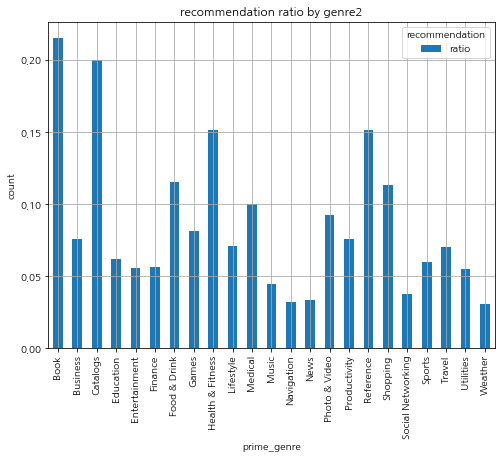

In [28]:
# 장르별 추천비율

obs['ratio'] = obs[1]/(obs[1]+obs[0])
obss = obs.drop([0,1],axis=1)

import matplotlib.pyplot as plt
%matplotlib inline

ax = obss.plot(kind='bar', title='recommendation ratio by genre2', figsize=(8, 6))
ax.set_ylabel('count')
plt.grid(color='darkgray')
plt.show()


* 어플 장르에 게임이 차지하는 비율이 압도적으로 높다.
* 전체를 기준으로 추천율, 비추천율을 장르별로 구분하여도 게임이 다른 장르에 비해서 모두 높다.
* 마지막 그래프인 recommendation ratio by genre2를 보면, 게임의 점유율과 무관하게 추천율은 높지 않음을 확인할 수 있으며, 가장 추천율이 높은 장르는 Book으로 확인하였다.

### 가설 2 : 가격의 영향력은 크기 때문에, 저렴하면 추천될 확률이 높을 것이다.

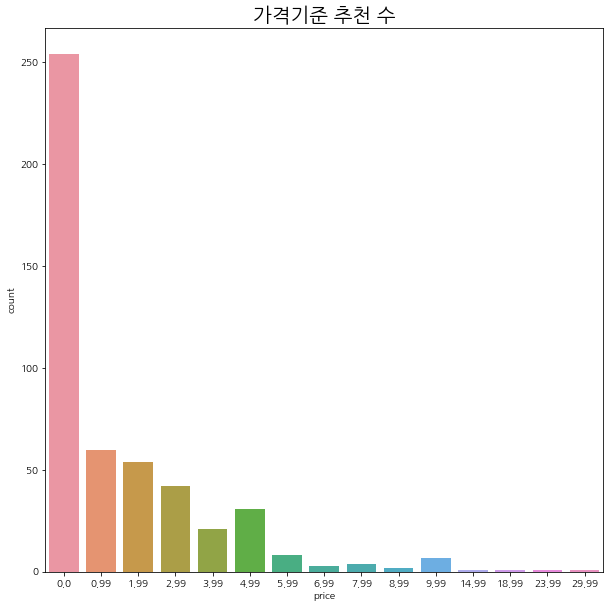

In [29]:
# 추천된것 중 가격비교함.

good = data[data.recommendation==1]
good.shape

good_by_price = good['price'].value_counts().reset_index().rename(columns={'index':'price','price':'count'})

plt.figure(figsize=(10,10))
sns.barplot(x='price',y='count',data=good_by_price)
plt.title('가격기준 추천 수',fontsize=20);

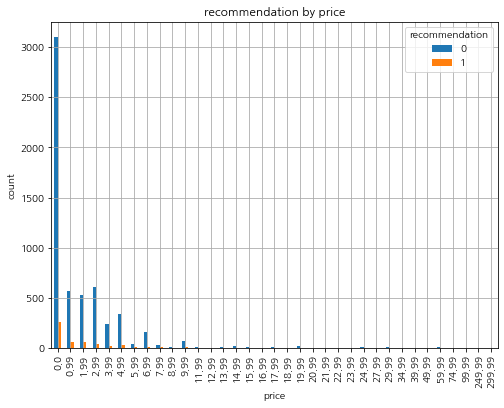

In [30]:
# 실제 총 데이터 중 추천비율을 보자 => 무료의 비중이 가장 높긴 하지만, 비추천은 훨씬 높음을 확인.

obs2 = pd.crosstab(data['price'],data['recommendation'])
obs2

import matplotlib.pyplot as plt
%matplotlib inline

ax = obs2.plot(kind='bar', title='recommendation by price', figsize=(8, 6))
ax.set_ylabel('count')
plt.grid(color='darkgray')
plt.show()


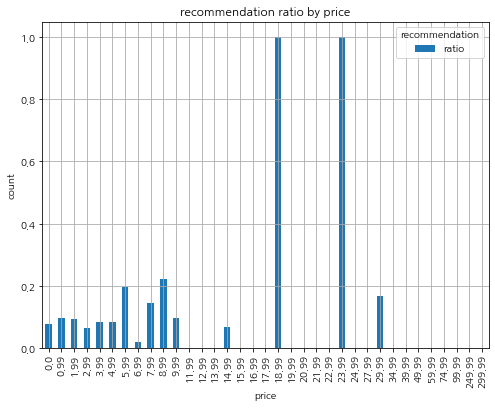

In [31]:
# 가격별 추천비율

obs2['ratio'] = obs2[1]/(obs2[1]+obs2[0])
obs3 = obs2.drop([0,1],axis=1)

import matplotlib.pyplot as plt
%matplotlib inline

ax = obs3.plot(kind='bar', title='recommendation ratio by price', figsize=(8, 6))
ax.set_ylabel('count')
plt.grid(color='darkgray')
plt.show()


In [32]:
data[data['price']==18.99]

,size_bytes,price,rating_count_tot,ver,cont_rating,prime_genre,sup_devices_num,ipadSc_urls_num,lang_num,vpp_lic,recommendation
4269,6290432,18.99,79,1,4,Music,37,5,1,1,1


In [33]:
data[data['price']==23.99]

,size_bytes,price,rating_count_tot,ver,cont_rating,prime_genre,sup_devices_num,ipadSc_urls_num,lang_num,vpp_lic,recommendation
1645,265569280,23.99,5,2,4,Reference,37,5,2,1,1


* 추천과 비추천의 데이터 수가 무료에 다른 가격에 비해 많고, 추천과 비추천 모두 가격이 적을수록 수치가 높았다.
* 큰 의미가 없다 판단하여 각 가격별로 추천비율을 구했을 때, 18.99달러와 23.99달러의 추천율이 1로, 데이터가 하나씩있는 이상치임을 확인하였다.
* 해당 가설은 큰 의미가 없는 것으로 판단한다.

# 5. Modeling

### 모델의 유용성과 한계

* 목적 : 만들고자 하는 모델의 경우 어떤 특성을 가진 어플이 4.5이상의 추천을 받을 수 있는지 예측
* 유용성 : 어플을 사용하려는 고객은 추천여부를 알 수 있고, 앱스토어 자체에서 추천하는 항목으로 될 수 있기에 판매자에게도 유용할 것이다.
* 한계 : 
 1. 악의적으로 저점을 받는 어플은 추천할 수 있는 가능성을 상실할 수 있다.
 2. paid/Free의 구분이 어플구입시 기준으로 나뉘는데, 시범기간 이후 유료화로 변하기도하고, 무료버전이라하더라도 유료를 해야 가능한 서비스가 있다면 구분이 모호하다 할 수 있다.
 3. 데이터가 2021/7월 한 달치로 부족할 수 있으나, 특별한 어플들이 많이 나오지 않은 이상, 특징은 크게 다르지 않을 것이라 판단한다.

## 1) 1차 모델링(RandomForest), 기준모델

In [34]:
# 훈련/검증/테스트셋 나누기

train, test = train_test_split(data, test_size=0.2, random_state=2)
train, val = train_test_split(train, test_size=0.2, random_state=2)

target = 'recommendation'
features = data.columns.drop([target])

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

train.shape, val.shape, test.shape

((3990, 11), (998, 11), (1248, 11))

In [35]:
# randomforest_ordinal encoding

pipe_rf_o = make_pipeline(
    OrdinalEncoder(), # 범주형 자료를 모델링할 때는 원핫보다 오디널이 좋음! 중요한 노드가 상위에서 선택되어야하는데 원핫을하면 적용이 잘 안됨! 한가지 특성이 여러가지로 나눠지기 때문에! 그래서 노미널인코딩이라도 오디널을 사용함! 트리에서는 순서가 상관없어서 괜찮다!
    RandomForestClassifier())

pipe_rf_o.fit(X_train, y_train)
y_pred = pipe_rf_o.predict(X_val)

print('훈련 정확도', pipe_rf_o.score(X_train,y_train))
print('검증 정확도', pipe_rf_o.score(X_val, y_val))
print('F1 score', f1_score(y_val, y_pred))
print('AUC 점수 :', roc_auc_score(y_val, y_pred))
print('REPORT',classification_report(y_val, y_pred))

훈련 정확도 1.0
검증 정확도 0.9248496993987976
F1 score 0.0963855421686747
AUC 점수 : 0.5243213993213992
REPORT               precision    recall  f1-score   support

           0       0.93      0.99      0.96       924
           1       0.44      0.05      0.10        74

    accuracy                           0.92       998
   macro avg       0.69      0.52      0.53       998
weighted avg       0.89      0.92      0.90       998



* Ordinal Encoder로 RandomForest를 이용해서 1차 Baseline Modeling을 진행했다.
* 기본적인 모델링으로 특별한 Parameter없이 진행했으며, 훈련정확도가 1로 과적합임을 확인하였다.
* 하지만 검증 Set에서의 정확도가 최빈값 Baseline을 넘었으므로 이번 Modeling에서 유심히 볼 평가지표인 'AUC Score'를 Baseline으로 두고 진행한다.
* Target의 imbalance함이 score에 영향을 주어 소수인 '1'에 대한 score는 전체적으로 낮은데, 밸런스화가 이번 모델링의 핵심으로 보인다.
* 추후 SMOTE를 적용하면 얼마나 성능이 좋아질 지 확인해보기로 한다.

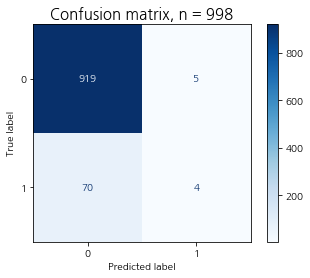

In [36]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
pcm = plot_confusion_matrix(pipe_rf_o, X_val, y_val,
                            cmap=plt.cm.Blues,
                            ax=ax);
plt.title(f'Confusion matrix, n = {len(y_val)}', fontsize=15)
plt.show()

In [37]:
tp = 5
tn = 919
fp = 5
fn = 69
total = tp+tn+fp+fn

In [38]:
y_train.value_counts(normalize=True)[1]

0.07794486215538847

## 2) 2차 모델링 (CatBoost)

In [39]:
# catboost, ordinalencoder

pipe_cat_o = make_pipeline(
    OrdinalEncoder(), # 범주형 자료를 모델링할 때는 원핫보다 오디널이 좋음! 중요한 노드가 상위에서 선택되어야하는데 원핫을하면 적용이 잘 안됨! 한가지 특성이 여러가지로 나눠지기 때문에! 그래서 노미널인코딩이라도 오디널을 사용함! 트리에서는 순서가 상관없어서 괜찮다!
    CatBoostClassifier())

pipe_cat_o.fit(X_train, y_train)
y_pred = pipe_cat_o.predict(X_val)

print('훈련 정확도', pipe_cat_o.score(X_train,y_train))
print('검증 정확도', pipe_cat_o.score(X_val, y_val))
print('F1 score', f1_score(y_val, y_pred))
print('AUC 점수 :', roc_auc_score(y_val, y_pred))
print('REPORT',classification_report(y_val, y_pred))

Learning rate set to 0.018602
0:	learn: 0.6724004	total: 53.2ms	remaining: 53.1s
1:	learn: 0.6522795	total: 54.5ms	remaining: 27.2s
2:	learn: 0.6345067	total: 55.8ms	remaining: 18.5s
3:	learn: 0.6178689	total: 56.8ms	remaining: 14.2s
4:	learn: 0.6020946	total: 57.6ms	remaining: 11.5s
5:	learn: 0.5855534	total: 59ms	remaining: 9.77s
6:	learn: 0.5703694	total: 60.2ms	remaining: 8.54s
7:	learn: 0.5566231	total: 61.5ms	remaining: 7.63s
8:	learn: 0.5422197	total: 62.9ms	remaining: 6.92s
9:	learn: 0.5286886	total: 64ms	remaining: 6.33s
10:	learn: 0.5163311	total: 65.5ms	remaining: 5.89s
11:	learn: 0.5051701	total: 66.8ms	remaining: 5.5s
12:	learn: 0.4933237	total: 68ms	remaining: 5.16s
13:	learn: 0.4823609	total: 69ms	remaining: 4.86s
14:	learn: 0.4716016	total: 70.4ms	remaining: 4.62s
15:	learn: 0.4624243	total: 71.4ms	remaining: 4.39s
16:	learn: 0.4525095	total: 72.6ms	remaining: 4.2s
17:	learn: 0.4434643	total: 73.8ms	remaining: 4.02s
18:	learn: 0.4353762	total: 74.8ms	remaining: 3.86s
19

264:	learn: 0.2163807	total: 377ms	remaining: 1.05s
265:	learn: 0.2162384	total: 379ms	remaining: 1.04s
266:	learn: 0.2162137	total: 380ms	remaining: 1.04s
267:	learn: 0.2161306	total: 381ms	remaining: 1.04s
268:	learn: 0.2159573	total: 383ms	remaining: 1.04s
269:	learn: 0.2158550	total: 384ms	remaining: 1.04s
270:	learn: 0.2158048	total: 385ms	remaining: 1.04s
271:	learn: 0.2155967	total: 387ms	remaining: 1.03s
272:	learn: 0.2154206	total: 388ms	remaining: 1.03s
273:	learn: 0.2151808	total: 389ms	remaining: 1.03s
274:	learn: 0.2150733	total: 390ms	remaining: 1.03s
275:	learn: 0.2149208	total: 392ms	remaining: 1.03s
276:	learn: 0.2148426	total: 393ms	remaining: 1.03s
277:	learn: 0.2148059	total: 395ms	remaining: 1.02s
278:	learn: 0.2146068	total: 396ms	remaining: 1.02s
279:	learn: 0.2145508	total: 397ms	remaining: 1.02s
280:	learn: 0.2144625	total: 399ms	remaining: 1.02s
281:	learn: 0.2143938	total: 400ms	remaining: 1.02s
282:	learn: 0.2140513	total: 402ms	remaining: 1.02s
283:	learn: 

537:	learn: 0.1847731	total: 754ms	remaining: 648ms
538:	learn: 0.1846251	total: 756ms	remaining: 647ms
539:	learn: 0.1844598	total: 758ms	remaining: 646ms
540:	learn: 0.1843311	total: 759ms	remaining: 644ms
541:	learn: 0.1841971	total: 761ms	remaining: 643ms
542:	learn: 0.1840943	total: 762ms	remaining: 641ms
543:	learn: 0.1840293	total: 763ms	remaining: 640ms
544:	learn: 0.1839629	total: 764ms	remaining: 638ms
545:	learn: 0.1837899	total: 766ms	remaining: 637ms
546:	learn: 0.1837402	total: 767ms	remaining: 635ms
547:	learn: 0.1835660	total: 768ms	remaining: 634ms
548:	learn: 0.1834955	total: 770ms	remaining: 632ms
549:	learn: 0.1833801	total: 771ms	remaining: 631ms
550:	learn: 0.1832408	total: 773ms	remaining: 630ms
551:	learn: 0.1832044	total: 774ms	remaining: 628ms
552:	learn: 0.1831573	total: 775ms	remaining: 627ms
553:	learn: 0.1830092	total: 777ms	remaining: 626ms
554:	learn: 0.1829717	total: 778ms	remaining: 624ms
555:	learn: 0.1829102	total: 780ms	remaining: 623ms
556:	learn: 

768:	learn: 0.1635592	total: 1.13s	remaining: 338ms
769:	learn: 0.1634872	total: 1.13s	remaining: 337ms
770:	learn: 0.1633727	total: 1.13s	remaining: 335ms
771:	learn: 0.1633326	total: 1.13s	remaining: 334ms
772:	learn: 0.1632045	total: 1.13s	remaining: 332ms
773:	learn: 0.1630899	total: 1.13s	remaining: 331ms
774:	learn: 0.1630166	total: 1.13s	remaining: 329ms
775:	learn: 0.1629472	total: 1.14s	remaining: 328ms
776:	learn: 0.1628607	total: 1.14s	remaining: 326ms
777:	learn: 0.1627225	total: 1.14s	remaining: 325ms
778:	learn: 0.1626846	total: 1.14s	remaining: 323ms
779:	learn: 0.1625196	total: 1.14s	remaining: 322ms
780:	learn: 0.1624557	total: 1.14s	remaining: 321ms
781:	learn: 0.1623896	total: 1.14s	remaining: 319ms
782:	learn: 0.1622858	total: 1.15s	remaining: 318ms
783:	learn: 0.1621797	total: 1.15s	remaining: 316ms
784:	learn: 0.1620588	total: 1.15s	remaining: 315ms
785:	learn: 0.1619229	total: 1.15s	remaining: 313ms
786:	learn: 0.1618279	total: 1.15s	remaining: 312ms
787:	learn: 

## 3) Hyper Parameter Tuning the RandomForest with SMOTE

In [40]:
###### pipe라인 랜덤포레스트 모델의 파라미터튜닝
pipe = make_pipeline(
      OrdinalEncoder(),
      RandomForestClassifier(random_state=2))

# 튜닝할 하이퍼파라미터의 범위를 지정
parameters = {'randomforestclassifier__max_depth': range(1, 5, 2), 
              'randomforestclassifier__max_features': range(1, 5, 2), 
              'randomforestclassifier__min_samples_leaf' : range(1, 5, 2)}
    
# 최적의 hyper parameter를 찾기 위한 RandomizedSearchCV
rf_classifier = RandomizedSearchCV(pipe, 
                                    param_distributions=parameters, #  param_distributions : 사전/사전목록
                                    n_iter=10, # 정수, 기본값=10
                                    cv=5, # 교차검증생성기 또는 반복가능 default=None
                                    scoring='accuracy', # 평가방법
                                    verbose=1) # 진행상황표시. 높을수록 더 많은 메세지표시.
rf_classifier.fit(X_train, y_train);

Fitting 5 folds for each of 8 candidates, totalling 40 fits


In [41]:
# RandomSearchCV 결과 확인
print('Best Parameters: ', rf_classifier.best_params_)
print('검증정확도: ', rf_classifier.best_score_)

Best Parameters:  {'randomforestclassifier__min_samples_leaf': 1, 'randomforestclassifier__max_features': 1, 'randomforestclassifier__max_depth': 1}
검증정확도:  0.9220551378446113


### (1) RandomForest with SMOTE1

In [42]:
# sampling_strategy=1.0

# 인코딩
encoder = OrdinalEncoder()
dataaa=encoder.fit_transform(data)

# 훈련/검증/테스트셋 나누기

train, test = train_test_split(dataaa, test_size=0.2, random_state=2)
train, val = train_test_split(train, test_size=0.2, random_state=2)
 
target = 'recommendation'
features = dataaa.columns.drop([target])

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

# smote 적용
sm = SMOTE(random_state=2, sampling_strategy=1.0) # sampling_strategy = 'minority'
X_train, y_train = sm.fit_resample(X_train, y_train)

# Hyperparameter 적용
smote = RandomForestClassifier(random_state=2, min_samples_leaf=1, max_features=1, max_depth=1).fit(X_train,y_train)
smote_pred=smote.predict(X_val)

print('훈련 정확도', smote.score(X_train, y_train))
print('검증 정확도', smote.score(X_val, y_val))
print('f1 스코어',f1_score(y_val, smote_pred))
print('auc점수 : ', roc_auc_score(y_val, smote_pred))
print('Report \n',classification_report(y_val, smote_pred))

훈련 정확도 0.7063060614297363
검증 정확도 0.6382765531062125
f1 스코어 0.17011494252873563
auc점수 :  0.5746753246753247
Report 
               precision    recall  f1-score   support

           0       0.94      0.65      0.77       924
           1       0.10      0.50      0.17        74

    accuracy                           0.64       998
   macro avg       0.52      0.57      0.47       998
weighted avg       0.88      0.64      0.72       998



### (2) RandomForest with SMOTE2

In [43]:
# sampling_strategy=1.0, class_weight

# 훈련/검증/테스트셋 나누기

train, test = train_test_split(dataaa, test_size=0.2, random_state=2)
train, val = train_test_split(train, test_size=0.2, random_state=2)
 
target = 'recommendation'
features = dataaa.columns.drop([target])

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

# smote 적용
sm = SMOTE(random_state=2, sampling_strategy=1.0) # sampling_strategy = 'minority'
X_train, y_train = sm.fit_resample(X_train, y_train)

# classweight, Hyperparameter 적용
smote = RandomForestClassifier(class_weight={0:ratio0,1:ratio1}, random_state=2, min_samples_leaf=1, max_features=1, max_depth=1).fit(X_train,y_train)
smote_pred=smote.predict(X_val)

print('훈련 정확도', smote.score(X_train, y_train))
print('검증 정확도', smote.score(X_val, y_val))
print('f1 스코어',f1_score(y_val, smote_pred))
print('auc점수 : ', roc_auc_score(y_val, smote_pred))
print('Report \n',classification_report(y_val, smote_pred))

훈련 정확도 0.5
검증 정확도 0.9258517034068137
f1 스코어 0.0
auc점수 :  0.5
Report 
               precision    recall  f1-score   support

           0       0.93      1.00      0.96       924
           1       0.00      0.00      0.00        74

    accuracy                           0.93       998
   macro avg       0.46      0.50      0.48       998
weighted avg       0.86      0.93      0.89       998



### (3) RandomForest with SMOTE3

In [44]:
# class_weight

# 훈련/검증/테스트셋 나누기

train, test = train_test_split(dataaa, test_size=0.2, random_state=2)
train, val = train_test_split(train, test_size=0.2, random_state=2)
 
target = 'recommendation'
features = dataaa.columns.drop([target])

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

# smote 적용
sm = SMOTE(random_state=2)
X_train, y_train = sm.fit_resample(X_train, y_train)

# classweight, Hyperparameter 적용
smote = RandomForestClassifier(class_weight={0:ratio0,1:ratio1}, random_state=2, min_samples_leaf=1, max_features=1, max_depth=1).fit(X_train,y_train)
smote_pred=smote.predict(X_val)

print('훈련 정확도', smote.score(X_train, y_train))
print('검증 정확도', smote.score(X_val, y_val))
print('f1 스코어',f1_score(y_val, smote_pred))
print('auc점수 : ', roc_auc_score(y_val, smote_pred))
print('Report \n',classification_report(y_val, smote_pred))

훈련 정확도 0.5
검증 정확도 0.9258517034068137
f1 스코어 0.0
auc점수 :  0.5
Report 
               precision    recall  f1-score   support

           0       0.93      1.00      0.96       924
           1       0.00      0.00      0.00        74

    accuracy                           0.93       998
   macro avg       0.46      0.50      0.48       998
weighted avg       0.86      0.93      0.89       998



### RandomForest의 Smote 및 Hyperparameter tuning 결과
* RandomizedSearchCV를 이용하여 hyper parameter를 적용하고, imbalance를 살펴보기로 한다.
* RandomForest의 경우 Hyperparameter에 class_weight={0:ratio0,1:ratio1}를 사용시, AUC score가 0.5이다.
* 소수인 ‘1’에 해당하는 metric socre가 반영이 되지 않았기 때문이다. 
* RandomForest의 class_weight을 제외하고, smote의 parameter인 sampling_strategy=1 만 적용한 첫번째 모델이 AUC가 0.57로 가장 훌륭하다.

## 4) Hyper Parameter Tuning the CatBoost with SMOTE

In [45]:
train, test = train_test_split(dataaa, test_size=0.2, random_state=2)
train, val = train_test_split(train, test_size=0.2, random_state=2)

target = 'recommendation'
features = data.columns.drop([target])

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

model = CatBoostClassifier(random_state=2)

grid = {'learning_rate': [0.03, 0.1],
        'max_depth': [4, 6, 10],
        'l2_leaf_reg': [1, 3, 5, 7, 9]}

randomized_search_result = model.randomized_search(grid, X=X_train, y=y_train, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.5920771	test: 0.5992894	best: 0.5992894 (0)	total: 2.1ms	remaining: 2.09s
1:	learn: 0.5126912	test: 0.5272563	best: 0.5272563 (1)	total: 6.91ms	remaining: 3.45s
2:	learn: 0.4542186	test: 0.4745585	best: 0.4745585 (2)	total: 10.2ms	remaining: 3.4s
3:	learn: 0.4053201	test: 0.4309041	best: 0.4309041 (3)	total: 12.7ms	remaining: 3.17s
4:	learn: 0.3671568	test: 0.3979380	best: 0.3979380 (4)	total: 16ms	remaining: 3.18s
5:	learn: 0.3376485	test: 0.3723629	best: 0.3723629 (5)	total: 19.3ms	remaining: 3.19s
6:	learn: 0.3167200	test: 0.3544194	best: 0.3544194 (6)	total: 23.4ms	remaining: 3.32s
7:	learn: 0.2991140	test: 0.3400967	best: 0.3400967 (7)	total: 26.5ms	remaining: 3.29s
8:	learn: 0.2856113	test: 0.3300015	best: 0.3300015 (8)	total: 29.3ms	remaining: 3.23s
9:	learn: 0.2765711	test: 0.3242226	best: 0.3242226 (9)	total: 46.7ms	remaining: 4.62s
10:	learn: 0.2681268	test: 0.3182034	best: 0.3182034 (10)	total: 56.1ms	remaining: 5.05s
11:	learn: 0.2613037	test: 0.3140856	best: 0.

106:	learn: 0.2021240	test: 0.3131558	best: 0.3045618 (21)	total: 200ms	remaining: 1.67s
107:	learn: 0.2018315	test: 0.3132666	best: 0.3045618 (21)	total: 203ms	remaining: 1.68s
108:	learn: 0.2017061	test: 0.3131738	best: 0.3045618 (21)	total: 206ms	remaining: 1.68s
109:	learn: 0.2014766	test: 0.3131857	best: 0.3045618 (21)	total: 208ms	remaining: 1.68s
110:	learn: 0.2011985	test: 0.3130568	best: 0.3045618 (21)	total: 209ms	remaining: 1.67s
111:	learn: 0.2009416	test: 0.3129042	best: 0.3045618 (21)	total: 210ms	remaining: 1.66s
112:	learn: 0.2007571	test: 0.3128373	best: 0.3045618 (21)	total: 211ms	remaining: 1.66s
113:	learn: 0.2004464	test: 0.3129775	best: 0.3045618 (21)	total: 212ms	remaining: 1.65s
114:	learn: 0.1998346	test: 0.3131920	best: 0.3045618 (21)	total: 213ms	remaining: 1.64s
115:	learn: 0.1994389	test: 0.3132639	best: 0.3045618 (21)	total: 215ms	remaining: 1.64s
116:	learn: 0.1992198	test: 0.3131340	best: 0.3045618 (21)	total: 218ms	remaining: 1.65s
117:	learn: 0.1987881

201:	learn: 0.1767713	test: 0.3168919	best: 0.3045618 (21)	total: 348ms	remaining: 1.37s
202:	learn: 0.1765595	test: 0.3167445	best: 0.3045618 (21)	total: 351ms	remaining: 1.38s
203:	learn: 0.1762888	test: 0.3171541	best: 0.3045618 (21)	total: 354ms	remaining: 1.38s
204:	learn: 0.1762828	test: 0.3171425	best: 0.3045618 (21)	total: 356ms	remaining: 1.38s
205:	learn: 0.1760555	test: 0.3169437	best: 0.3045618 (21)	total: 359ms	remaining: 1.38s
206:	learn: 0.1756423	test: 0.3170709	best: 0.3045618 (21)	total: 360ms	remaining: 1.38s
207:	learn: 0.1755105	test: 0.3171783	best: 0.3045618 (21)	total: 361ms	remaining: 1.38s
208:	learn: 0.1753404	test: 0.3172117	best: 0.3045618 (21)	total: 363ms	remaining: 1.38s
209:	learn: 0.1751273	test: 0.3170545	best: 0.3045618 (21)	total: 364ms	remaining: 1.37s
210:	learn: 0.1749315	test: 0.3170744	best: 0.3045618 (21)	total: 365ms	remaining: 1.37s
211:	learn: 0.1745832	test: 0.3172150	best: 0.3045618 (21)	total: 366ms	remaining: 1.36s
212:	learn: 0.1743144

340:	learn: 0.1503098	test: 0.3263664	best: 0.3045618 (21)	total: 546ms	remaining: 1.05s
341:	learn: 0.1500011	test: 0.3258608	best: 0.3045618 (21)	total: 550ms	remaining: 1.06s
342:	learn: 0.1499327	test: 0.3259367	best: 0.3045618 (21)	total: 553ms	remaining: 1.06s
343:	learn: 0.1496418	test: 0.3260667	best: 0.3045618 (21)	total: 557ms	remaining: 1.06s
344:	learn: 0.1495088	test: 0.3261348	best: 0.3045618 (21)	total: 560ms	remaining: 1.06s
345:	learn: 0.1493215	test: 0.3267133	best: 0.3045618 (21)	total: 561ms	remaining: 1.06s
346:	learn: 0.1490500	test: 0.3267629	best: 0.3045618 (21)	total: 562ms	remaining: 1.06s
347:	learn: 0.1487523	test: 0.3267825	best: 0.3045618 (21)	total: 563ms	remaining: 1.05s
348:	learn: 0.1486108	test: 0.3270472	best: 0.3045618 (21)	total: 565ms	remaining: 1.05s
349:	learn: 0.1484031	test: 0.3274354	best: 0.3045618 (21)	total: 567ms	remaining: 1.05s
350:	learn: 0.1482395	test: 0.3275289	best: 0.3045618 (21)	total: 569ms	remaining: 1.05s
351:	learn: 0.1479918

487:	learn: 0.1290192	test: 0.3382283	best: 0.3045618 (21)	total: 744ms	remaining: 781ms
488:	learn: 0.1288939	test: 0.3384848	best: 0.3045618 (21)	total: 747ms	remaining: 781ms
489:	learn: 0.1287510	test: 0.3385333	best: 0.3045618 (21)	total: 750ms	remaining: 781ms
490:	learn: 0.1286253	test: 0.3386434	best: 0.3045618 (21)	total: 753ms	remaining: 781ms
491:	learn: 0.1285181	test: 0.3388422	best: 0.3045618 (21)	total: 756ms	remaining: 780ms
492:	learn: 0.1284797	test: 0.3389699	best: 0.3045618 (21)	total: 757ms	remaining: 778ms
493:	learn: 0.1284716	test: 0.3389490	best: 0.3045618 (21)	total: 758ms	remaining: 777ms
494:	learn: 0.1283270	test: 0.3391069	best: 0.3045618 (21)	total: 759ms	remaining: 775ms
495:	learn: 0.1282868	test: 0.3391950	best: 0.3045618 (21)	total: 761ms	remaining: 773ms
496:	learn: 0.1279636	test: 0.3393626	best: 0.3045618 (21)	total: 762ms	remaining: 771ms
497:	learn: 0.1276912	test: 0.3392288	best: 0.3045618 (21)	total: 763ms	remaining: 769ms
498:	learn: 0.1275421

628:	learn: 0.1130598	test: 0.3486075	best: 0.3045618 (21)	total: 943ms	remaining: 556ms
629:	learn: 0.1129173	test: 0.3484697	best: 0.3045618 (21)	total: 946ms	remaining: 556ms
630:	learn: 0.1128458	test: 0.3485626	best: 0.3045618 (21)	total: 950ms	remaining: 556ms
631:	learn: 0.1126891	test: 0.3484060	best: 0.3045618 (21)	total: 953ms	remaining: 555ms
632:	learn: 0.1126051	test: 0.3484571	best: 0.3045618 (21)	total: 955ms	remaining: 554ms
633:	learn: 0.1125701	test: 0.3484815	best: 0.3045618 (21)	total: 956ms	remaining: 552ms
634:	learn: 0.1125096	test: 0.3484582	best: 0.3045618 (21)	total: 957ms	remaining: 550ms
635:	learn: 0.1124968	test: 0.3484792	best: 0.3045618 (21)	total: 958ms	remaining: 548ms
636:	learn: 0.1124607	test: 0.3485241	best: 0.3045618 (21)	total: 960ms	remaining: 547ms
637:	learn: 0.1124385	test: 0.3486158	best: 0.3045618 (21)	total: 962ms	remaining: 546ms
638:	learn: 0.1124224	test: 0.3486268	best: 0.3045618 (21)	total: 965ms	remaining: 545ms
639:	learn: 0.1123021

780:	learn: 0.0993496	test: 0.3629560	best: 0.3045618 (21)	total: 1.14s	remaining: 320ms
781:	learn: 0.0992639	test: 0.3629791	best: 0.3045618 (21)	total: 1.14s	remaining: 319ms
782:	learn: 0.0991886	test: 0.3630236	best: 0.3045618 (21)	total: 1.15s	remaining: 317ms
783:	learn: 0.0990943	test: 0.3631350	best: 0.3045618 (21)	total: 1.15s	remaining: 316ms
784:	learn: 0.0990008	test: 0.3631942	best: 0.3045618 (21)	total: 1.15s	remaining: 315ms
785:	learn: 0.0989609	test: 0.3632066	best: 0.3045618 (21)	total: 1.15s	remaining: 314ms
786:	learn: 0.0988730	test: 0.3632015	best: 0.3045618 (21)	total: 1.15s	remaining: 312ms
787:	learn: 0.0987629	test: 0.3634377	best: 0.3045618 (21)	total: 1.15s	remaining: 311ms
788:	learn: 0.0987245	test: 0.3633574	best: 0.3045618 (21)	total: 1.16s	remaining: 309ms
789:	learn: 0.0986768	test: 0.3633726	best: 0.3045618 (21)	total: 1.16s	remaining: 308ms
790:	learn: 0.0985828	test: 0.3634534	best: 0.3045618 (21)	total: 1.16s	remaining: 306ms
791:	learn: 0.0985369

922:	learn: 0.0889481	test: 0.3731545	best: 0.3045618 (21)	total: 1.34s	remaining: 112ms
923:	learn: 0.0888502	test: 0.3731741	best: 0.3045618 (21)	total: 1.34s	remaining: 110ms
924:	learn: 0.0887525	test: 0.3731159	best: 0.3045618 (21)	total: 1.34s	remaining: 109ms
925:	learn: 0.0886352	test: 0.3729403	best: 0.3045618 (21)	total: 1.35s	remaining: 108ms
926:	learn: 0.0884974	test: 0.3727203	best: 0.3045618 (21)	total: 1.35s	remaining: 106ms
927:	learn: 0.0884243	test: 0.3726786	best: 0.3045618 (21)	total: 1.35s	remaining: 105ms
928:	learn: 0.0883603	test: 0.3726979	best: 0.3045618 (21)	total: 1.35s	remaining: 104ms
929:	learn: 0.0882902	test: 0.3728433	best: 0.3045618 (21)	total: 1.36s	remaining: 102ms
930:	learn: 0.0881732	test: 0.3728702	best: 0.3045618 (21)	total: 1.36s	remaining: 101ms
931:	learn: 0.0881347	test: 0.3729482	best: 0.3045618 (21)	total: 1.36s	remaining: 99.5ms
932:	learn: 0.0881243	test: 0.3729524	best: 0.3045618 (21)	total: 1.37s	remaining: 98.2ms
933:	learn: 0.08802

68:	learn: 0.2167524	test: 0.3137525	best: 0.3038621 (18)	total: 69.9ms	remaining: 944ms
69:	learn: 0.2163721	test: 0.3141278	best: 0.3038621 (18)	total: 73.8ms	remaining: 980ms
70:	learn: 0.2161006	test: 0.3144644	best: 0.3038621 (18)	total: 76.5ms	remaining: 1s
71:	learn: 0.2160573	test: 0.3144766	best: 0.3038621 (18)	total: 79.2ms	remaining: 1.02s
72:	learn: 0.2160195	test: 0.3144600	best: 0.3038621 (18)	total: 81.6ms	remaining: 1.04s
73:	learn: 0.2154289	test: 0.3148351	best: 0.3038621 (18)	total: 84.6ms	remaining: 1.06s
74:	learn: 0.2154180	test: 0.3148120	best: 0.3038621 (18)	total: 85.5ms	remaining: 1.05s
75:	learn: 0.2151404	test: 0.3149057	best: 0.3038621 (18)	total: 86.3ms	remaining: 1.05s
76:	learn: 0.2149389	test: 0.3148303	best: 0.3038621 (18)	total: 87.2ms	remaining: 1.04s
77:	learn: 0.2147611	test: 0.3149234	best: 0.3038621 (18)	total: 88.1ms	remaining: 1.04s
78:	learn: 0.2143635	test: 0.3151581	best: 0.3038621 (18)	total: 88.9ms	remaining: 1.04s
79:	learn: 0.2137178	tes

218:	learn: 0.1770524	test: 0.3255569	best: 0.3038621 (18)	total: 269ms	remaining: 959ms
219:	learn: 0.1769454	test: 0.3255567	best: 0.3038621 (18)	total: 272ms	remaining: 963ms
220:	learn: 0.1768630	test: 0.3255756	best: 0.3038621 (18)	total: 275ms	remaining: 968ms
221:	learn: 0.1765761	test: 0.3257007	best: 0.3038621 (18)	total: 277ms	remaining: 971ms
222:	learn: 0.1764927	test: 0.3257900	best: 0.3038621 (18)	total: 281ms	remaining: 978ms
223:	learn: 0.1763336	test: 0.3257580	best: 0.3038621 (18)	total: 283ms	remaining: 982ms
224:	learn: 0.1761350	test: 0.3260052	best: 0.3038621 (18)	total: 286ms	remaining: 985ms
225:	learn: 0.1755555	test: 0.3262719	best: 0.3038621 (18)	total: 288ms	remaining: 988ms
226:	learn: 0.1752581	test: 0.3262877	best: 0.3038621 (18)	total: 291ms	remaining: 989ms
227:	learn: 0.1750035	test: 0.3263960	best: 0.3038621 (18)	total: 293ms	remaining: 992ms
228:	learn: 0.1748951	test: 0.3263600	best: 0.3038621 (18)	total: 296ms	remaining: 996ms
229:	learn: 0.1746658

346:	learn: 0.1547507	test: 0.3340873	best: 0.3038621 (18)	total: 467ms	remaining: 879ms
347:	learn: 0.1546361	test: 0.3341425	best: 0.3038621 (18)	total: 470ms	remaining: 881ms
348:	learn: 0.1545328	test: 0.3340637	best: 0.3038621 (18)	total: 473ms	remaining: 882ms
349:	learn: 0.1542831	test: 0.3344697	best: 0.3038621 (18)	total: 476ms	remaining: 884ms
350:	learn: 0.1541845	test: 0.3345705	best: 0.3038621 (18)	total: 479ms	remaining: 885ms
351:	learn: 0.1539623	test: 0.3343855	best: 0.3038621 (18)	total: 480ms	remaining: 884ms
352:	learn: 0.1539406	test: 0.3344008	best: 0.3038621 (18)	total: 481ms	remaining: 881ms
353:	learn: 0.1538039	test: 0.3345817	best: 0.3038621 (18)	total: 482ms	remaining: 879ms
354:	learn: 0.1537386	test: 0.3345041	best: 0.3038621 (18)	total: 483ms	remaining: 878ms
355:	learn: 0.1534617	test: 0.3349758	best: 0.3038621 (18)	total: 484ms	remaining: 875ms
356:	learn: 0.1531103	test: 0.3346784	best: 0.3038621 (18)	total: 485ms	remaining: 873ms
357:	learn: 0.1530895

505:	learn: 0.1327946	test: 0.3464907	best: 0.3038621 (18)	total: 665ms	remaining: 650ms
506:	learn: 0.1327849	test: 0.3465007	best: 0.3038621 (18)	total: 668ms	remaining: 650ms
507:	learn: 0.1325128	test: 0.3466601	best: 0.3038621 (18)	total: 672ms	remaining: 651ms
508:	learn: 0.1322251	test: 0.3463588	best: 0.3038621 (18)	total: 675ms	remaining: 651ms
509:	learn: 0.1321068	test: 0.3461718	best: 0.3038621 (18)	total: 678ms	remaining: 651ms
510:	learn: 0.1319349	test: 0.3463191	best: 0.3038621 (18)	total: 679ms	remaining: 650ms
511:	learn: 0.1318610	test: 0.3462754	best: 0.3038621 (18)	total: 680ms	remaining: 648ms
512:	learn: 0.1317890	test: 0.3463951	best: 0.3038621 (18)	total: 681ms	remaining: 647ms
513:	learn: 0.1315750	test: 0.3465760	best: 0.3038621 (18)	total: 682ms	remaining: 645ms
514:	learn: 0.1313748	test: 0.3470372	best: 0.3038621 (18)	total: 683ms	remaining: 643ms
515:	learn: 0.1312963	test: 0.3471726	best: 0.3038621 (18)	total: 684ms	remaining: 642ms
516:	learn: 0.1312288

628:	learn: 0.1209211	test: 0.3519408	best: 0.3038621 (18)	total: 866ms	remaining: 511ms
629:	learn: 0.1208879	test: 0.3520037	best: 0.3038621 (18)	total: 870ms	remaining: 511ms
630:	learn: 0.1208462	test: 0.3520470	best: 0.3038621 (18)	total: 874ms	remaining: 511ms
631:	learn: 0.1206778	test: 0.3521550	best: 0.3038621 (18)	total: 877ms	remaining: 511ms
632:	learn: 0.1204434	test: 0.3523090	best: 0.3038621 (18)	total: 880ms	remaining: 510ms
633:	learn: 0.1202977	test: 0.3522772	best: 0.3038621 (18)	total: 883ms	remaining: 510ms
634:	learn: 0.1200364	test: 0.3525051	best: 0.3038621 (18)	total: 886ms	remaining: 509ms
635:	learn: 0.1199670	test: 0.3525438	best: 0.3038621 (18)	total: 888ms	remaining: 508ms
636:	learn: 0.1198827	test: 0.3526636	best: 0.3038621 (18)	total: 892ms	remaining: 508ms
637:	learn: 0.1197817	test: 0.3529275	best: 0.3038621 (18)	total: 894ms	remaining: 507ms
638:	learn: 0.1197032	test: 0.3529915	best: 0.3038621 (18)	total: 897ms	remaining: 507ms
639:	learn: 0.1196572

763:	learn: 0.1095295	test: 0.3603960	best: 0.3038621 (18)	total: 1.06s	remaining: 329ms
764:	learn: 0.1092892	test: 0.3606198	best: 0.3038621 (18)	total: 1.07s	remaining: 328ms
765:	learn: 0.1092439	test: 0.3606029	best: 0.3038621 (18)	total: 1.07s	remaining: 327ms
766:	learn: 0.1092001	test: 0.3606788	best: 0.3038621 (18)	total: 1.07s	remaining: 326ms
767:	learn: 0.1091584	test: 0.3608993	best: 0.3038621 (18)	total: 1.08s	remaining: 325ms
768:	learn: 0.1090830	test: 0.3610332	best: 0.3038621 (18)	total: 1.08s	remaining: 324ms
769:	learn: 0.1090133	test: 0.3614072	best: 0.3038621 (18)	total: 1.08s	remaining: 322ms
770:	learn: 0.1089004	test: 0.3614999	best: 0.3038621 (18)	total: 1.08s	remaining: 321ms
771:	learn: 0.1087200	test: 0.3614644	best: 0.3038621 (18)	total: 1.08s	remaining: 319ms
772:	learn: 0.1086643	test: 0.3615502	best: 0.3038621 (18)	total: 1.08s	remaining: 318ms
773:	learn: 0.1086117	test: 0.3615998	best: 0.3038621 (18)	total: 1.08s	remaining: 316ms
774:	learn: 0.1085626

913:	learn: 0.0982418	test: 0.3719766	best: 0.3038621 (18)	total: 1.26s	remaining: 119ms
914:	learn: 0.0981467	test: 0.3721041	best: 0.3038621 (18)	total: 1.27s	remaining: 118ms
915:	learn: 0.0980389	test: 0.3722172	best: 0.3038621 (18)	total: 1.27s	remaining: 116ms
916:	learn: 0.0979850	test: 0.3720895	best: 0.3038621 (18)	total: 1.27s	remaining: 115ms
917:	learn: 0.0978773	test: 0.3720974	best: 0.3038621 (18)	total: 1.28s	remaining: 114ms
918:	learn: 0.0977660	test: 0.3722288	best: 0.3038621 (18)	total: 1.28s	remaining: 113ms
919:	learn: 0.0976763	test: 0.3722757	best: 0.3038621 (18)	total: 1.28s	remaining: 111ms
920:	learn: 0.0975953	test: 0.3723877	best: 0.3038621 (18)	total: 1.28s	remaining: 110ms
921:	learn: 0.0975175	test: 0.3725404	best: 0.3038621 (18)	total: 1.28s	remaining: 108ms
922:	learn: 0.0974335	test: 0.3725482	best: 0.3038621 (18)	total: 1.28s	remaining: 107ms
923:	learn: 0.0974311	test: 0.3725348	best: 0.3038621 (18)	total: 1.28s	remaining: 106ms
924:	learn: 0.0974289

39:	learn: 0.2559621	test: 0.3147614	best: 0.3147614 (39)	total: 70.5ms	remaining: 1.69s
40:	learn: 0.2539616	test: 0.3139221	best: 0.3139221 (40)	total: 77.9ms	remaining: 1.82s
41:	learn: 0.2526587	test: 0.3133176	best: 0.3133176 (41)	total: 82.6ms	remaining: 1.88s
42:	learn: 0.2506938	test: 0.3121270	best: 0.3121270 (42)	total: 86.1ms	remaining: 1.92s
43:	learn: 0.2490165	test: 0.3112925	best: 0.3112925 (43)	total: 89.8ms	remaining: 1.95s
44:	learn: 0.2473410	test: 0.3105084	best: 0.3105084 (44)	total: 93.9ms	remaining: 1.99s
45:	learn: 0.2459015	test: 0.3099712	best: 0.3099712 (45)	total: 97.9ms	remaining: 2.03s
46:	learn: 0.2447927	test: 0.3093401	best: 0.3093401 (46)	total: 101ms	remaining: 2.04s
47:	learn: 0.2434539	test: 0.3086759	best: 0.3086759 (47)	total: 105ms	remaining: 2.08s
48:	learn: 0.2424025	test: 0.3082516	best: 0.3082516 (48)	total: 109ms	remaining: 2.12s
49:	learn: 0.2413265	test: 0.3078221	best: 0.3078221 (49)	total: 114ms	remaining: 2.16s
50:	learn: 0.2402878	test

147:	learn: 0.2030765	test: 0.3114447	best: 0.3051117 (65)	total: 269ms	remaining: 1.55s
148:	learn: 0.2029262	test: 0.3116093	best: 0.3051117 (65)	total: 274ms	remaining: 1.56s
149:	learn: 0.2028563	test: 0.3115926	best: 0.3051117 (65)	total: 277ms	remaining: 1.57s
150:	learn: 0.2026796	test: 0.3117918	best: 0.3051117 (65)	total: 281ms	remaining: 1.58s
151:	learn: 0.2026629	test: 0.3118091	best: 0.3051117 (65)	total: 282ms	remaining: 1.57s
152:	learn: 0.2023813	test: 0.3119926	best: 0.3051117 (65)	total: 284ms	remaining: 1.57s
153:	learn: 0.2023305	test: 0.3119235	best: 0.3051117 (65)	total: 285ms	remaining: 1.57s
154:	learn: 0.2020753	test: 0.3118886	best: 0.3051117 (65)	total: 288ms	remaining: 1.57s
155:	learn: 0.2017856	test: 0.3119764	best: 0.3051117 (65)	total: 290ms	remaining: 1.57s
156:	learn: 0.2017239	test: 0.3120050	best: 0.3051117 (65)	total: 291ms	remaining: 1.56s
157:	learn: 0.2014612	test: 0.3119054	best: 0.3051117 (65)	total: 294ms	remaining: 1.57s
158:	learn: 0.2012252

253:	learn: 0.1789825	test: 0.3158468	best: 0.3051117 (65)	total: 468ms	remaining: 1.37s
254:	learn: 0.1787467	test: 0.3158653	best: 0.3051117 (65)	total: 472ms	remaining: 1.38s
255:	learn: 0.1782783	test: 0.3158464	best: 0.3051117 (65)	total: 476ms	remaining: 1.38s
256:	learn: 0.1780447	test: 0.3157965	best: 0.3051117 (65)	total: 479ms	remaining: 1.39s
257:	learn: 0.1778119	test: 0.3159986	best: 0.3051117 (65)	total: 481ms	remaining: 1.38s
258:	learn: 0.1777133	test: 0.3159393	best: 0.3051117 (65)	total: 485ms	remaining: 1.39s
259:	learn: 0.1774579	test: 0.3158051	best: 0.3051117 (65)	total: 486ms	remaining: 1.38s
260:	learn: 0.1772436	test: 0.3159758	best: 0.3051117 (65)	total: 487ms	remaining: 1.38s
261:	learn: 0.1771538	test: 0.3161915	best: 0.3051117 (65)	total: 489ms	remaining: 1.38s
262:	learn: 0.1768240	test: 0.3160959	best: 0.3051117 (65)	total: 492ms	remaining: 1.38s
263:	learn: 0.1764245	test: 0.3161875	best: 0.3051117 (65)	total: 494ms	remaining: 1.38s
264:	learn: 0.1761822

374:	learn: 0.1549997	test: 0.3214569	best: 0.3051117 (65)	total: 667ms	remaining: 1.11s
375:	learn: 0.1549332	test: 0.3214571	best: 0.3051117 (65)	total: 670ms	remaining: 1.11s
376:	learn: 0.1547092	test: 0.3214375	best: 0.3051117 (65)	total: 675ms	remaining: 1.11s
377:	learn: 0.1544986	test: 0.3215135	best: 0.3051117 (65)	total: 678ms	remaining: 1.11s
378:	learn: 0.1543424	test: 0.3215652	best: 0.3051117 (65)	total: 679ms	remaining: 1.11s
379:	learn: 0.1541523	test: 0.3217229	best: 0.3051117 (65)	total: 681ms	remaining: 1.11s
380:	learn: 0.1539499	test: 0.3218165	best: 0.3051117 (65)	total: 682ms	remaining: 1.11s
381:	learn: 0.1538868	test: 0.3219230	best: 0.3051117 (65)	total: 683ms	remaining: 1.1s
382:	learn: 0.1537395	test: 0.3219355	best: 0.3051117 (65)	total: 685ms	remaining: 1.1s
383:	learn: 0.1534780	test: 0.3217183	best: 0.3051117 (65)	total: 686ms	remaining: 1.1s
384:	learn: 0.1534437	test: 0.3216872	best: 0.3051117 (65)	total: 687ms	remaining: 1.1s
385:	learn: 0.1534249	tes

484:	learn: 0.1382129	test: 0.3258142	best: 0.3051117 (65)	total: 864ms	remaining: 918ms
485:	learn: 0.1380334	test: 0.3257863	best: 0.3051117 (65)	total: 869ms	remaining: 919ms
486:	learn: 0.1379070	test: 0.3258684	best: 0.3051117 (65)	total: 874ms	remaining: 920ms
487:	learn: 0.1378378	test: 0.3258346	best: 0.3051117 (65)	total: 877ms	remaining: 920ms
488:	learn: 0.1377960	test: 0.3258051	best: 0.3051117 (65)	total: 879ms	remaining: 919ms
489:	learn: 0.1376607	test: 0.3258786	best: 0.3051117 (65)	total: 881ms	remaining: 917ms
490:	learn: 0.1374723	test: 0.3259800	best: 0.3051117 (65)	total: 882ms	remaining: 914ms
491:	learn: 0.1373924	test: 0.3259708	best: 0.3051117 (65)	total: 883ms	remaining: 912ms
492:	learn: 0.1371681	test: 0.3260647	best: 0.3051117 (65)	total: 884ms	remaining: 910ms
493:	learn: 0.1369879	test: 0.3261637	best: 0.3051117 (65)	total: 886ms	remaining: 907ms
494:	learn: 0.1367814	test: 0.3262462	best: 0.3051117 (65)	total: 888ms	remaining: 906ms
495:	learn: 0.1366931

598:	learn: 0.1239839	test: 0.3318827	best: 0.3051117 (65)	total: 1.06s	remaining: 711ms
599:	learn: 0.1238778	test: 0.3319182	best: 0.3051117 (65)	total: 1.06s	remaining: 710ms
600:	learn: 0.1237083	test: 0.3320051	best: 0.3051117 (65)	total: 1.07s	remaining: 711ms
601:	learn: 0.1236710	test: 0.3320138	best: 0.3051117 (65)	total: 1.07s	remaining: 711ms
602:	learn: 0.1235015	test: 0.3321382	best: 0.3051117 (65)	total: 1.08s	remaining: 710ms
603:	learn: 0.1233482	test: 0.3321640	best: 0.3051117 (65)	total: 1.08s	remaining: 707ms
604:	learn: 0.1232613	test: 0.3322581	best: 0.3051117 (65)	total: 1.08s	remaining: 705ms
605:	learn: 0.1231502	test: 0.3322723	best: 0.3051117 (65)	total: 1.08s	remaining: 703ms
606:	learn: 0.1230197	test: 0.3322064	best: 0.3051117 (65)	total: 1.09s	remaining: 703ms
607:	learn: 0.1229603	test: 0.3321729	best: 0.3051117 (65)	total: 1.09s	remaining: 703ms
608:	learn: 0.1227900	test: 0.3322943	best: 0.3051117 (65)	total: 1.09s	remaining: 701ms
609:	learn: 0.1226693

693:	learn: 0.1144958	test: 0.3352480	best: 0.3051117 (65)	total: 1.26s	remaining: 555ms
694:	learn: 0.1144036	test: 0.3352733	best: 0.3051117 (65)	total: 1.26s	remaining: 554ms
695:	learn: 0.1142117	test: 0.3353296	best: 0.3051117 (65)	total: 1.27s	remaining: 553ms
696:	learn: 0.1140797	test: 0.3353479	best: 0.3051117 (65)	total: 1.27s	remaining: 552ms
697:	learn: 0.1139836	test: 0.3353515	best: 0.3051117 (65)	total: 1.27s	remaining: 550ms
698:	learn: 0.1139614	test: 0.3353851	best: 0.3051117 (65)	total: 1.27s	remaining: 548ms
699:	learn: 0.1137377	test: 0.3353999	best: 0.3051117 (65)	total: 1.27s	remaining: 546ms
700:	learn: 0.1136425	test: 0.3354197	best: 0.3051117 (65)	total: 1.28s	remaining: 545ms
701:	learn: 0.1135288	test: 0.3355274	best: 0.3051117 (65)	total: 1.28s	remaining: 543ms
702:	learn: 0.1133793	test: 0.3355310	best: 0.3051117 (65)	total: 1.28s	remaining: 541ms
703:	learn: 0.1132237	test: 0.3357482	best: 0.3051117 (65)	total: 1.28s	remaining: 540ms
704:	learn: 0.1131145

799:	learn: 0.1046860	test: 0.3400782	best: 0.3051117 (65)	total: 1.46s	remaining: 364ms
800:	learn: 0.1046213	test: 0.3400027	best: 0.3051117 (65)	total: 1.46s	remaining: 363ms
801:	learn: 0.1045412	test: 0.3400659	best: 0.3051117 (65)	total: 1.46s	remaining: 361ms
802:	learn: 0.1044761	test: 0.3400815	best: 0.3051117 (65)	total: 1.47s	remaining: 360ms
803:	learn: 0.1043799	test: 0.3401720	best: 0.3051117 (65)	total: 1.47s	remaining: 359ms
804:	learn: 0.1042568	test: 0.3401592	best: 0.3051117 (65)	total: 1.47s	remaining: 357ms
805:	learn: 0.1041495	test: 0.3402249	best: 0.3051117 (65)	total: 1.48s	remaining: 355ms
806:	learn: 0.1040592	test: 0.3403131	best: 0.3051117 (65)	total: 1.48s	remaining: 353ms
807:	learn: 0.1040224	test: 0.3403153	best: 0.3051117 (65)	total: 1.48s	remaining: 351ms
808:	learn: 0.1039219	test: 0.3404155	best: 0.3051117 (65)	total: 1.48s	remaining: 349ms
809:	learn: 0.1038601	test: 0.3402994	best: 0.3051117 (65)	total: 1.48s	remaining: 348ms
810:	learn: 0.1037663

899:	learn: 0.0962778	test: 0.3432984	best: 0.3051117 (65)	total: 1.66s	remaining: 184ms
900:	learn: 0.0961906	test: 0.3434076	best: 0.3051117 (65)	total: 1.66s	remaining: 182ms
901:	learn: 0.0961453	test: 0.3434501	best: 0.3051117 (65)	total: 1.66s	remaining: 181ms
902:	learn: 0.0960284	test: 0.3433406	best: 0.3051117 (65)	total: 1.67s	remaining: 179ms
903:	learn: 0.0959470	test: 0.3434673	best: 0.3051117 (65)	total: 1.67s	remaining: 177ms
904:	learn: 0.0958663	test: 0.3435723	best: 0.3051117 (65)	total: 1.67s	remaining: 176ms
905:	learn: 0.0958503	test: 0.3435715	best: 0.3051117 (65)	total: 1.67s	remaining: 174ms
906:	learn: 0.0957692	test: 0.3436085	best: 0.3051117 (65)	total: 1.68s	remaining: 172ms
907:	learn: 0.0957132	test: 0.3436141	best: 0.3051117 (65)	total: 1.68s	remaining: 170ms
908:	learn: 0.0956677	test: 0.3436500	best: 0.3051117 (65)	total: 1.68s	remaining: 168ms
909:	learn: 0.0956442	test: 0.3436610	best: 0.3051117 (65)	total: 1.68s	remaining: 166ms
910:	learn: 0.0955738

7:	learn: 0.2955538	test: 0.3405716	best: 0.3405716 (7)	total: 15ms	remaining: 1.85s
8:	learn: 0.2814496	test: 0.3312442	best: 0.3312442 (8)	total: 18.8ms	remaining: 2.07s
9:	learn: 0.2704833	test: 0.3238287	best: 0.3238287 (9)	total: 22.7ms	remaining: 2.25s
10:	learn: 0.2616030	test: 0.3185121	best: 0.3185121 (10)	total: 26.3ms	remaining: 2.37s
11:	learn: 0.2548239	test: 0.3148325	best: 0.3148325 (11)	total: 27.7ms	remaining: 2.28s
12:	learn: 0.2489848	test: 0.3114119	best: 0.3114119 (12)	total: 29.1ms	remaining: 2.21s
13:	learn: 0.2441703	test: 0.3093982	best: 0.3093982 (13)	total: 30.6ms	remaining: 2.15s
14:	learn: 0.2409082	test: 0.3080194	best: 0.3080194 (14)	total: 32.2ms	remaining: 2.11s
15:	learn: 0.2376284	test: 0.3069565	best: 0.3069565 (15)	total: 33.5ms	remaining: 2.06s
16:	learn: 0.2352369	test: 0.3067146	best: 0.3067146 (16)	total: 34.9ms	remaining: 2.02s
17:	learn: 0.2324721	test: 0.3059662	best: 0.3059662 (17)	total: 36.1ms	remaining: 1.97s
18:	learn: 0.2304176	test: 0.

121:	learn: 0.1634747	test: 0.3222990	best: 0.3059662 (17)	total: 212ms	remaining: 1.52s
122:	learn: 0.1634302	test: 0.3223577	best: 0.3059662 (17)	total: 216ms	remaining: 1.54s
123:	learn: 0.1625366	test: 0.3225546	best: 0.3059662 (17)	total: 220ms	remaining: 1.55s
124:	learn: 0.1617260	test: 0.3227204	best: 0.3059662 (17)	total: 225ms	remaining: 1.57s
125:	learn: 0.1613433	test: 0.3229694	best: 0.3059662 (17)	total: 226ms	remaining: 1.57s
126:	learn: 0.1608476	test: 0.3231165	best: 0.3059662 (17)	total: 228ms	remaining: 1.56s
127:	learn: 0.1604933	test: 0.3232574	best: 0.3059662 (17)	total: 230ms	remaining: 1.57s
128:	learn: 0.1597609	test: 0.3237774	best: 0.3059662 (17)	total: 232ms	remaining: 1.57s
129:	learn: 0.1596603	test: 0.3239688	best: 0.3059662 (17)	total: 234ms	remaining: 1.56s
130:	learn: 0.1596480	test: 0.3239225	best: 0.3059662 (17)	total: 235ms	remaining: 1.56s
131:	learn: 0.1588688	test: 0.3238081	best: 0.3059662 (17)	total: 239ms	remaining: 1.57s
132:	learn: 0.1579726

234:	learn: 0.1180654	test: 0.3359511	best: 0.3059662 (17)	total: 409ms	remaining: 1.33s
235:	learn: 0.1178926	test: 0.3359808	best: 0.3059662 (17)	total: 413ms	remaining: 1.34s
236:	learn: 0.1176617	test: 0.3359823	best: 0.3059662 (17)	total: 417ms	remaining: 1.34s
237:	learn: 0.1172280	test: 0.3361167	best: 0.3059662 (17)	total: 421ms	remaining: 1.35s
238:	learn: 0.1167418	test: 0.3359923	best: 0.3059662 (17)	total: 424ms	remaining: 1.35s
239:	learn: 0.1167075	test: 0.3360605	best: 0.3059662 (17)	total: 427ms	remaining: 1.35s
240:	learn: 0.1163898	test: 0.3358736	best: 0.3059662 (17)	total: 430ms	remaining: 1.35s
241:	learn: 0.1157803	test: 0.3362991	best: 0.3059662 (17)	total: 432ms	remaining: 1.35s
242:	learn: 0.1157162	test: 0.3362949	best: 0.3059662 (17)	total: 435ms	remaining: 1.35s
243:	learn: 0.1154395	test: 0.3365040	best: 0.3059662 (17)	total: 436ms	remaining: 1.35s
244:	learn: 0.1150784	test: 0.3366510	best: 0.3059662 (17)	total: 437ms	remaining: 1.35s
245:	learn: 0.1148697

329:	learn: 0.0955310	test: 0.3464161	best: 0.3059662 (17)	total: 607ms	remaining: 1.23s
330:	learn: 0.0954969	test: 0.3464398	best: 0.3059662 (17)	total: 611ms	remaining: 1.24s
331:	learn: 0.0951912	test: 0.3463201	best: 0.3059662 (17)	total: 616ms	remaining: 1.24s
332:	learn: 0.0951135	test: 0.3462419	best: 0.3059662 (17)	total: 620ms	remaining: 1.24s
333:	learn: 0.0947646	test: 0.3469722	best: 0.3059662 (17)	total: 622ms	remaining: 1.24s
334:	learn: 0.0944056	test: 0.3459790	best: 0.3059662 (17)	total: 623ms	remaining: 1.24s
335:	learn: 0.0941409	test: 0.3460969	best: 0.3059662 (17)	total: 624ms	remaining: 1.23s
336:	learn: 0.0939156	test: 0.3464159	best: 0.3059662 (17)	total: 626ms	remaining: 1.23s
337:	learn: 0.0935534	test: 0.3466112	best: 0.3059662 (17)	total: 631ms	remaining: 1.23s
338:	learn: 0.0931688	test: 0.3464289	best: 0.3059662 (17)	total: 633ms	remaining: 1.23s
339:	learn: 0.0928635	test: 0.3463831	best: 0.3059662 (17)	total: 634ms	remaining: 1.23s
340:	learn: 0.0925706

437:	learn: 0.0767441	test: 0.3600739	best: 0.3059662 (17)	total: 806ms	remaining: 1.03s
438:	learn: 0.0766596	test: 0.3601966	best: 0.3059662 (17)	total: 810ms	remaining: 1.03s
439:	learn: 0.0765055	test: 0.3602718	best: 0.3059662 (17)	total: 814ms	remaining: 1.03s
440:	learn: 0.0762701	test: 0.3601600	best: 0.3059662 (17)	total: 817ms	remaining: 1.03s
441:	learn: 0.0761340	test: 0.3603280	best: 0.3059662 (17)	total: 819ms	remaining: 1.03s
442:	learn: 0.0759229	test: 0.3608349	best: 0.3059662 (17)	total: 820ms	remaining: 1.03s
443:	learn: 0.0756748	test: 0.3609862	best: 0.3059662 (17)	total: 822ms	remaining: 1.03s
444:	learn: 0.0756646	test: 0.3609963	best: 0.3059662 (17)	total: 825ms	remaining: 1.03s
445:	learn: 0.0752976	test: 0.3613080	best: 0.3059662 (17)	total: 828ms	remaining: 1.03s
446:	learn: 0.0751400	test: 0.3618002	best: 0.3059662 (17)	total: 829ms	remaining: 1.02s
447:	learn: 0.0750978	test: 0.3620701	best: 0.3059662 (17)	total: 830ms	remaining: 1.02s
448:	learn: 0.0748687

548:	learn: 0.0625535	test: 0.3714610	best: 0.3059662 (17)	total: 1s	remaining: 826ms
549:	learn: 0.0623342	test: 0.3720292	best: 0.3059662 (17)	total: 1.01s	remaining: 825ms
550:	learn: 0.0622225	test: 0.3722985	best: 0.3059662 (17)	total: 1.01s	remaining: 825ms
551:	learn: 0.0621340	test: 0.3723793	best: 0.3059662 (17)	total: 1.03s	remaining: 834ms
552:	learn: 0.0621227	test: 0.3724644	best: 0.3059662 (17)	total: 1.03s	remaining: 836ms
553:	learn: 0.0620287	test: 0.3725880	best: 0.3059662 (17)	total: 1.04s	remaining: 836ms
554:	learn: 0.0619135	test: 0.3727106	best: 0.3059662 (17)	total: 1.04s	remaining: 834ms
555:	learn: 0.0618313	test: 0.3727610	best: 0.3059662 (17)	total: 1.04s	remaining: 832ms
556:	learn: 0.0617667	test: 0.3728061	best: 0.3059662 (17)	total: 1.04s	remaining: 830ms
557:	learn: 0.0617022	test: 0.3729108	best: 0.3059662 (17)	total: 1.04s	remaining: 828ms
558:	learn: 0.0616410	test: 0.3729360	best: 0.3059662 (17)	total: 1.05s	remaining: 825ms
559:	learn: 0.0615689	te

643:	learn: 0.0522880	test: 0.3824554	best: 0.3059662 (17)	total: 1.2s	remaining: 664ms
644:	learn: 0.0521789	test: 0.3826969	best: 0.3059662 (17)	total: 1.21s	remaining: 664ms
645:	learn: 0.0521340	test: 0.3827451	best: 0.3059662 (17)	total: 1.21s	remaining: 663ms
646:	learn: 0.0521267	test: 0.3827706	best: 0.3059662 (17)	total: 1.22s	remaining: 664ms
647:	learn: 0.0518356	test: 0.3830621	best: 0.3059662 (17)	total: 1.22s	remaining: 662ms
648:	learn: 0.0517618	test: 0.3833188	best: 0.3059662 (17)	total: 1.22s	remaining: 661ms
649:	learn: 0.0516795	test: 0.3834695	best: 0.3059662 (17)	total: 1.22s	remaining: 659ms
650:	learn: 0.0516201	test: 0.3835556	best: 0.3059662 (17)	total: 1.23s	remaining: 657ms
651:	learn: 0.0515609	test: 0.3836572	best: 0.3059662 (17)	total: 1.23s	remaining: 655ms
652:	learn: 0.0511954	test: 0.3836518	best: 0.3059662 (17)	total: 1.23s	remaining: 654ms
653:	learn: 0.0511631	test: 0.3837056	best: 0.3059662 (17)	total: 1.23s	remaining: 653ms
654:	learn: 0.0511149	

738:	learn: 0.0452420	test: 0.3939464	best: 0.3059662 (17)	total: 1.45s	remaining: 512ms
739:	learn: 0.0452150	test: 0.3939114	best: 0.3059662 (17)	total: 1.45s	remaining: 511ms
740:	learn: 0.0450729	test: 0.3940820	best: 0.3059662 (17)	total: 1.46s	remaining: 509ms
741:	learn: 0.0449525	test: 0.3939534	best: 0.3059662 (17)	total: 1.46s	remaining: 508ms
742:	learn: 0.0448527	test: 0.3940212	best: 0.3059662 (17)	total: 1.46s	remaining: 507ms
743:	learn: 0.0448046	test: 0.3939973	best: 0.3059662 (17)	total: 1.47s	remaining: 505ms
744:	learn: 0.0447289	test: 0.3941107	best: 0.3059662 (17)	total: 1.47s	remaining: 502ms
745:	learn: 0.0446951	test: 0.3940491	best: 0.3059662 (17)	total: 1.47s	remaining: 500ms
746:	learn: 0.0446870	test: 0.3940764	best: 0.3059662 (17)	total: 1.47s	remaining: 498ms
747:	learn: 0.0446136	test: 0.3941332	best: 0.3059662 (17)	total: 1.47s	remaining: 496ms
748:	learn: 0.0445964	test: 0.3942460	best: 0.3059662 (17)	total: 1.48s	remaining: 495ms
749:	learn: 0.0445856

886:	learn: 0.0362411	test: 0.4090497	best: 0.3059662 (17)	total: 1.8s	remaining: 229ms
887:	learn: 0.0361645	test: 0.4090839	best: 0.3059662 (17)	total: 1.81s	remaining: 228ms
888:	learn: 0.0361160	test: 0.4092151	best: 0.3059662 (17)	total: 1.81s	remaining: 226ms
889:	learn: 0.0360954	test: 0.4092804	best: 0.3059662 (17)	total: 1.81s	remaining: 224ms
890:	learn: 0.0359856	test: 0.4095284	best: 0.3059662 (17)	total: 1.82s	remaining: 223ms
891:	learn: 0.0359549	test: 0.4095176	best: 0.3059662 (17)	total: 1.82s	remaining: 221ms
892:	learn: 0.0359044	test: 0.4094778	best: 0.3059662 (17)	total: 1.83s	remaining: 219ms
893:	learn: 0.0358982	test: 0.4094401	best: 0.3059662 (17)	total: 1.83s	remaining: 217ms
894:	learn: 0.0358588	test: 0.4095280	best: 0.3059662 (17)	total: 1.83s	remaining: 215ms
895:	learn: 0.0358575	test: 0.4095165	best: 0.3059662 (17)	total: 1.83s	remaining: 213ms
896:	learn: 0.0358105	test: 0.4094819	best: 0.3059662 (17)	total: 1.83s	remaining: 211ms
897:	learn: 0.0356951	

20:	learn: 0.3297365	test: 0.3673520	best: 0.3673520 (20)	total: 44.9ms	remaining: 2.09s
21:	learn: 0.3234698	test: 0.3626971	best: 0.3626971 (21)	total: 49.4ms	remaining: 2.2s
22:	learn: 0.3179476	test: 0.3583573	best: 0.3583573 (22)	total: 55.5ms	remaining: 2.36s
23:	learn: 0.3124047	test: 0.3540444	best: 0.3540444 (23)	total: 60.1ms	remaining: 2.44s
24:	learn: 0.3067234	test: 0.3498000	best: 0.3498000 (24)	total: 62.1ms	remaining: 2.42s
25:	learn: 0.3024359	test: 0.3464695	best: 0.3464695 (25)	total: 63.1ms	remaining: 2.36s
26:	learn: 0.2975256	test: 0.3427701	best: 0.3427701 (26)	total: 64.5ms	remaining: 2.32s
27:	learn: 0.2931265	test: 0.3393401	best: 0.3393401 (27)	total: 65.9ms	remaining: 2.29s
28:	learn: 0.2886486	test: 0.3362358	best: 0.3362358 (28)	total: 67.5ms	remaining: 2.26s
29:	learn: 0.2845091	test: 0.3334433	best: 0.3334433 (29)	total: 71.7ms	remaining: 2.32s
30:	learn: 0.2804595	test: 0.3305422	best: 0.3305422 (30)	total: 73.5ms	remaining: 2.3s
31:	learn: 0.2766371	te

116:	learn: 0.2124400	test: 0.3111718	best: 0.3063842 (67)	total: 288ms	remaining: 2.18s
117:	learn: 0.2122188	test: 0.3111820	best: 0.3063842 (67)	total: 293ms	remaining: 2.19s
118:	learn: 0.2121262	test: 0.3111137	best: 0.3063842 (67)	total: 297ms	remaining: 2.2s
119:	learn: 0.2119614	test: 0.3112240	best: 0.3063842 (67)	total: 302ms	remaining: 2.21s
120:	learn: 0.2119149	test: 0.3112480	best: 0.3063842 (67)	total: 306ms	remaining: 2.22s
121:	learn: 0.2115906	test: 0.3112958	best: 0.3063842 (67)	total: 309ms	remaining: 2.22s
122:	learn: 0.2112198	test: 0.3114313	best: 0.3063842 (67)	total: 310ms	remaining: 2.21s
123:	learn: 0.2110066	test: 0.3115050	best: 0.3063842 (67)	total: 311ms	remaining: 2.2s
124:	learn: 0.2108080	test: 0.3116038	best: 0.3063842 (67)	total: 313ms	remaining: 2.19s
125:	learn: 0.2106019	test: 0.3116946	best: 0.3063842 (67)	total: 317ms	remaining: 2.2s
126:	learn: 0.2105803	test: 0.3117201	best: 0.3063842 (67)	total: 319ms	remaining: 2.19s
127:	learn: 0.2103084	te

281:	learn: 0.1849998	test: 0.3173262	best: 0.3063842 (67)	total: 638ms	remaining: 1.62s
282:	learn: 0.1849523	test: 0.3172895	best: 0.3063842 (67)	total: 644ms	remaining: 1.63s
283:	learn: 0.1845431	test: 0.3172666	best: 0.3063842 (67)	total: 648ms	remaining: 1.63s
284:	learn: 0.1843054	test: 0.3172715	best: 0.3063842 (67)	total: 653ms	remaining: 1.64s
285:	learn: 0.1841466	test: 0.3172652	best: 0.3063842 (67)	total: 657ms	remaining: 1.64s
286:	learn: 0.1840399	test: 0.3172832	best: 0.3063842 (67)	total: 659ms	remaining: 1.64s
287:	learn: 0.1839550	test: 0.3173928	best: 0.3063842 (67)	total: 661ms	remaining: 1.63s
288:	learn: 0.1838044	test: 0.3174917	best: 0.3063842 (67)	total: 664ms	remaining: 1.63s
289:	learn: 0.1836950	test: 0.3174598	best: 0.3063842 (67)	total: 666ms	remaining: 1.63s
290:	learn: 0.1836578	test: 0.3174730	best: 0.3063842 (67)	total: 667ms	remaining: 1.63s
291:	learn: 0.1834449	test: 0.3176602	best: 0.3063842 (67)	total: 669ms	remaining: 1.62s
292:	learn: 0.1834362

386:	learn: 0.1687859	test: 0.3224081	best: 0.3063842 (67)	total: 883ms	remaining: 1.4s
387:	learn: 0.1686452	test: 0.3224699	best: 0.3063842 (67)	total: 889ms	remaining: 1.4s
388:	learn: 0.1686126	test: 0.3224211	best: 0.3063842 (67)	total: 893ms	remaining: 1.4s
389:	learn: 0.1685859	test: 0.3224290	best: 0.3063842 (67)	total: 897ms	remaining: 1.4s
390:	learn: 0.1681908	test: 0.3227115	best: 0.3063842 (67)	total: 899ms	remaining: 1.4s
391:	learn: 0.1679468	test: 0.3227091	best: 0.3063842 (67)	total: 901ms	remaining: 1.4s
392:	learn: 0.1678370	test: 0.3227595	best: 0.3063842 (67)	total: 904ms	remaining: 1.4s
393:	learn: 0.1677908	test: 0.3227490	best: 0.3063842 (67)	total: 905ms	remaining: 1.39s
394:	learn: 0.1676364	test: 0.3228908	best: 0.3063842 (67)	total: 907ms	remaining: 1.39s
395:	learn: 0.1676256	test: 0.3228717	best: 0.3063842 (67)	total: 910ms	remaining: 1.39s
396:	learn: 0.1675864	test: 0.3228414	best: 0.3063842 (67)	total: 913ms	remaining: 1.39s
397:	learn: 0.1674198	test: 

527:	learn: 0.1498561	test: 0.3275840	best: 0.3063842 (67)	total: 1.24s	remaining: 1.11s
528:	learn: 0.1497081	test: 0.3275868	best: 0.3063842 (67)	total: 1.24s	remaining: 1.11s
529:	learn: 0.1496049	test: 0.3276753	best: 0.3063842 (67)	total: 1.25s	remaining: 1.11s
530:	learn: 0.1494778	test: 0.3277295	best: 0.3063842 (67)	total: 1.25s	remaining: 1.11s
531:	learn: 0.1493582	test: 0.3276799	best: 0.3063842 (67)	total: 1.26s	remaining: 1.11s
532:	learn: 0.1491374	test: 0.3277414	best: 0.3063842 (67)	total: 1.27s	remaining: 1.11s
533:	learn: 0.1489121	test: 0.3277491	best: 0.3063842 (67)	total: 1.28s	remaining: 1.11s
534:	learn: 0.1488917	test: 0.3277532	best: 0.3063842 (67)	total: 1.31s	remaining: 1.14s
535:	learn: 0.1487345	test: 0.3277962	best: 0.3063842 (67)	total: 1.31s	remaining: 1.14s
536:	learn: 0.1485321	test: 0.3278925	best: 0.3063842 (67)	total: 1.32s	remaining: 1.14s
537:	learn: 0.1485165	test: 0.3279048	best: 0.3063842 (67)	total: 1.33s	remaining: 1.14s
538:	learn: 0.1483929

632:	learn: 0.1387000	test: 0.3305765	best: 0.3063842 (67)	total: 1.64s	remaining: 952ms
633:	learn: 0.1386963	test: 0.3305704	best: 0.3063842 (67)	total: 1.65s	remaining: 951ms
634:	learn: 0.1386260	test: 0.3305439	best: 0.3063842 (67)	total: 1.65s	remaining: 949ms
635:	learn: 0.1385629	test: 0.3305319	best: 0.3063842 (67)	total: 1.66s	remaining: 948ms
636:	learn: 0.1384550	test: 0.3306150	best: 0.3063842 (67)	total: 1.66s	remaining: 945ms
637:	learn: 0.1383423	test: 0.3305873	best: 0.3063842 (67)	total: 1.66s	remaining: 942ms
638:	learn: 0.1382137	test: 0.3306771	best: 0.3063842 (67)	total: 1.66s	remaining: 940ms
639:	learn: 0.1381184	test: 0.3307552	best: 0.3063842 (67)	total: 1.67s	remaining: 937ms
640:	learn: 0.1380067	test: 0.3307239	best: 0.3063842 (67)	total: 1.67s	remaining: 934ms
641:	learn: 0.1379863	test: 0.3307230	best: 0.3063842 (67)	total: 1.67s	remaining: 932ms
642:	learn: 0.1378498	test: 0.3308906	best: 0.3063842 (67)	total: 1.67s	remaining: 929ms
643:	learn: 0.1377136

731:	learn: 0.1311278	test: 0.3328741	best: 0.3063842 (67)	total: 1.88s	remaining: 688ms
732:	learn: 0.1310699	test: 0.3328660	best: 0.3063842 (67)	total: 1.88s	remaining: 685ms
733:	learn: 0.1310537	test: 0.3328742	best: 0.3063842 (67)	total: 1.89s	remaining: 683ms
734:	learn: 0.1310456	test: 0.3328755	best: 0.3063842 (67)	total: 1.89s	remaining: 681ms
735:	learn: 0.1309521	test: 0.3328564	best: 0.3063842 (67)	total: 1.89s	remaining: 680ms
736:	learn: 0.1309378	test: 0.3328570	best: 0.3063842 (67)	total: 1.9s	remaining: 677ms
737:	learn: 0.1307460	test: 0.3327973	best: 0.3063842 (67)	total: 1.9s	remaining: 674ms
738:	learn: 0.1306314	test: 0.3329171	best: 0.3063842 (67)	total: 1.9s	remaining: 672ms
739:	learn: 0.1305584	test: 0.3329894	best: 0.3063842 (67)	total: 1.9s	remaining: 669ms
740:	learn: 0.1304595	test: 0.3330503	best: 0.3063842 (67)	total: 1.91s	remaining: 666ms
741:	learn: 0.1302443	test: 0.3330908	best: 0.3063842 (67)	total: 1.91s	remaining: 663ms
742:	learn: 0.1302354	tes

877:	learn: 0.1192938	test: 0.3383279	best: 0.3063842 (67)	total: 2.24s	remaining: 311ms
878:	learn: 0.1192880	test: 0.3383270	best: 0.3063842 (67)	total: 2.24s	remaining: 309ms
879:	learn: 0.1192514	test: 0.3383194	best: 0.3063842 (67)	total: 2.25s	remaining: 307ms
880:	learn: 0.1190856	test: 0.3382631	best: 0.3063842 (67)	total: 2.25s	remaining: 304ms
881:	learn: 0.1190036	test: 0.3383499	best: 0.3063842 (67)	total: 2.25s	remaining: 302ms
882:	learn: 0.1188635	test: 0.3384004	best: 0.3063842 (67)	total: 2.26s	remaining: 299ms
883:	learn: 0.1187649	test: 0.3385805	best: 0.3063842 (67)	total: 2.26s	remaining: 297ms
884:	learn: 0.1186849	test: 0.3386217	best: 0.3063842 (67)	total: 2.26s	remaining: 294ms
885:	learn: 0.1185701	test: 0.3386875	best: 0.3063842 (67)	total: 2.26s	remaining: 291ms
886:	learn: 0.1185548	test: 0.3386774	best: 0.3063842 (67)	total: 2.27s	remaining: 289ms
887:	learn: 0.1183970	test: 0.3387910	best: 0.3063842 (67)	total: 2.27s	remaining: 286ms
888:	learn: 0.1183184

44:	learn: 0.2051434	test: 0.3129072	best: 0.3056214 (18)	total: 85.8ms	remaining: 1.82s
45:	learn: 0.2038697	test: 0.3129166	best: 0.3056214 (18)	total: 90.2ms	remaining: 1.87s
46:	learn: 0.2038496	test: 0.3129112	best: 0.3056214 (18)	total: 93.5ms	remaining: 1.9s
47:	learn: 0.2031525	test: 0.3133242	best: 0.3056214 (18)	total: 97.8ms	remaining: 1.94s
48:	learn: 0.2029082	test: 0.3133803	best: 0.3056214 (18)	total: 102ms	remaining: 1.99s
49:	learn: 0.2024159	test: 0.3130878	best: 0.3056214 (18)	total: 104ms	remaining: 1.97s
50:	learn: 0.2018224	test: 0.3134450	best: 0.3056214 (18)	total: 105ms	remaining: 1.95s
51:	learn: 0.2006846	test: 0.3139234	best: 0.3056214 (18)	total: 107ms	remaining: 1.94s
52:	learn: 0.2002550	test: 0.3139254	best: 0.3056214 (18)	total: 109ms	remaining: 1.95s
53:	learn: 0.1997721	test: 0.3140526	best: 0.3056214 (18)	total: 112ms	remaining: 1.96s
54:	learn: 0.1994960	test: 0.3140495	best: 0.3056214 (18)	total: 113ms	remaining: 1.95s
55:	learn: 0.1986010	test: 0.

153:	learn: 0.1533301	test: 0.3287182	best: 0.3056214 (18)	total: 327ms	remaining: 1.8s
154:	learn: 0.1525728	test: 0.3287315	best: 0.3056214 (18)	total: 331ms	remaining: 1.8s
155:	learn: 0.1517599	test: 0.3296630	best: 0.3056214 (18)	total: 335ms	remaining: 1.81s
156:	learn: 0.1511116	test: 0.3292702	best: 0.3056214 (18)	total: 338ms	remaining: 1.81s
157:	learn: 0.1510116	test: 0.3294329	best: 0.3056214 (18)	total: 341ms	remaining: 1.82s
158:	learn: 0.1504029	test: 0.3297326	best: 0.3056214 (18)	total: 343ms	remaining: 1.81s
159:	learn: 0.1498828	test: 0.3298627	best: 0.3056214 (18)	total: 346ms	remaining: 1.82s
160:	learn: 0.1492476	test: 0.3299858	best: 0.3056214 (18)	total: 348ms	remaining: 1.81s
161:	learn: 0.1486575	test: 0.3300853	best: 0.3056214 (18)	total: 349ms	remaining: 1.8s
162:	learn: 0.1483169	test: 0.3296505	best: 0.3056214 (18)	total: 350ms	remaining: 1.8s
163:	learn: 0.1477176	test: 0.3298167	best: 0.3056214 (18)	total: 352ms	remaining: 1.79s
164:	learn: 0.1476918	tes

260:	learn: 0.1197664	test: 0.3444254	best: 0.3056214 (18)	total: 525ms	remaining: 1.49s
261:	learn: 0.1194428	test: 0.3441878	best: 0.3056214 (18)	total: 527ms	remaining: 1.48s
262:	learn: 0.1194238	test: 0.3441935	best: 0.3056214 (18)	total: 528ms	remaining: 1.48s
263:	learn: 0.1190738	test: 0.3440381	best: 0.3056214 (18)	total: 529ms	remaining: 1.48s
264:	learn: 0.1186673	test: 0.3445140	best: 0.3056214 (18)	total: 531ms	remaining: 1.47s
265:	learn: 0.1185202	test: 0.3448852	best: 0.3056214 (18)	total: 532ms	remaining: 1.47s
266:	learn: 0.1183702	test: 0.3449676	best: 0.3056214 (18)	total: 535ms	remaining: 1.47s
267:	learn: 0.1182706	test: 0.3450958	best: 0.3056214 (18)	total: 537ms	remaining: 1.47s
268:	learn: 0.1182523	test: 0.3451478	best: 0.3056214 (18)	total: 539ms	remaining: 1.46s
269:	learn: 0.1182239	test: 0.3452084	best: 0.3056214 (18)	total: 543ms	remaining: 1.47s
270:	learn: 0.1178987	test: 0.3451157	best: 0.3056214 (18)	total: 546ms	remaining: 1.47s
271:	learn: 0.1178849

355:	learn: 0.0986907	test: 0.3503883	best: 0.3056214 (18)	total: 680ms	remaining: 1.23s
356:	learn: 0.0985518	test: 0.3507117	best: 0.3056214 (18)	total: 685ms	remaining: 1.23s
357:	learn: 0.0984177	test: 0.3505984	best: 0.3056214 (18)	total: 688ms	remaining: 1.23s
358:	learn: 0.0981039	test: 0.3504458	best: 0.3056214 (18)	total: 691ms	remaining: 1.23s
359:	learn: 0.0980868	test: 0.3504652	best: 0.3056214 (18)	total: 694ms	remaining: 1.23s
360:	learn: 0.0979094	test: 0.3506467	best: 0.3056214 (18)	total: 695ms	remaining: 1.23s
361:	learn: 0.0976330	test: 0.3509238	best: 0.3056214 (18)	total: 698ms	remaining: 1.23s
362:	learn: 0.0972724	test: 0.3514652	best: 0.3056214 (18)	total: 700ms	remaining: 1.23s
363:	learn: 0.0970561	test: 0.3513236	best: 0.3056214 (18)	total: 703ms	remaining: 1.23s
364:	learn: 0.0968099	test: 0.3512522	best: 0.3056214 (18)	total: 704ms	remaining: 1.23s
365:	learn: 0.0966481	test: 0.3515724	best: 0.3056214 (18)	total: 706ms	remaining: 1.22s
366:	learn: 0.0966101

461:	learn: 0.0819465	test: 0.3625990	best: 0.3056214 (18)	total: 921ms	remaining: 1.07s
462:	learn: 0.0818750	test: 0.3627483	best: 0.3056214 (18)	total: 925ms	remaining: 1.07s
463:	learn: 0.0818689	test: 0.3627713	best: 0.3056214 (18)	total: 929ms	remaining: 1.07s
464:	learn: 0.0815892	test: 0.3632203	best: 0.3056214 (18)	total: 933ms	remaining: 1.07s
465:	learn: 0.0812836	test: 0.3632881	best: 0.3056214 (18)	total: 934ms	remaining: 1.07s
466:	learn: 0.0810419	test: 0.3632704	best: 0.3056214 (18)	total: 935ms	remaining: 1.07s
467:	learn: 0.0808647	test: 0.3636451	best: 0.3056214 (18)	total: 937ms	remaining: 1.06s
468:	learn: 0.0806654	test: 0.3638766	best: 0.3056214 (18)	total: 938ms	remaining: 1.06s
469:	learn: 0.0805967	test: 0.3638907	best: 0.3056214 (18)	total: 939ms	remaining: 1.06s
470:	learn: 0.0804512	test: 0.3637283	best: 0.3056214 (18)	total: 941ms	remaining: 1.06s
471:	learn: 0.0802795	test: 0.3637351	best: 0.3056214 (18)	total: 944ms	remaining: 1.05s
472:	learn: 0.0801068

556:	learn: 0.0705541	test: 0.3723046	best: 0.3056214 (18)	total: 1.08s	remaining: 856ms
557:	learn: 0.0704693	test: 0.3723986	best: 0.3056214 (18)	total: 1.08s	remaining: 856ms
558:	learn: 0.0703819	test: 0.3725543	best: 0.3056214 (18)	total: 1.08s	remaining: 855ms
559:	learn: 0.0702651	test: 0.3727886	best: 0.3056214 (18)	total: 1.09s	remaining: 855ms
560:	learn: 0.0701420	test: 0.3728268	best: 0.3056214 (18)	total: 1.09s	remaining: 854ms
561:	learn: 0.0699627	test: 0.3725819	best: 0.3056214 (18)	total: 1.09s	remaining: 853ms
562:	learn: 0.0697171	test: 0.3724610	best: 0.3056214 (18)	total: 1.09s	remaining: 851ms
563:	learn: 0.0694435	test: 0.3730611	best: 0.3056214 (18)	total: 1.1s	remaining: 848ms
564:	learn: 0.0694213	test: 0.3731020	best: 0.3056214 (18)	total: 1.1s	remaining: 846ms
565:	learn: 0.0693392	test: 0.3730894	best: 0.3056214 (18)	total: 1.1s	remaining: 843ms
566:	learn: 0.0692278	test: 0.3731922	best: 0.3056214 (18)	total: 1.1s	remaining: 841ms
567:	learn: 0.0691525	tes

664:	learn: 0.0607493	test: 0.3806791	best: 0.3056214 (18)	total: 1.27s	remaining: 642ms
665:	learn: 0.0606600	test: 0.3811384	best: 0.3056214 (18)	total: 1.28s	remaining: 641ms
666:	learn: 0.0605876	test: 0.3812349	best: 0.3056214 (18)	total: 1.28s	remaining: 640ms
667:	learn: 0.0604086	test: 0.3815013	best: 0.3056214 (18)	total: 1.29s	remaining: 640ms
668:	learn: 0.0603433	test: 0.3814048	best: 0.3056214 (18)	total: 1.29s	remaining: 638ms
669:	learn: 0.0603064	test: 0.3814241	best: 0.3056214 (18)	total: 1.29s	remaining: 636ms
670:	learn: 0.0602084	test: 0.3819241	best: 0.3056214 (18)	total: 1.29s	remaining: 633ms
671:	learn: 0.0601715	test: 0.3819694	best: 0.3056214 (18)	total: 1.29s	remaining: 631ms
672:	learn: 0.0601397	test: 0.3819964	best: 0.3056214 (18)	total: 1.29s	remaining: 629ms
673:	learn: 0.0601262	test: 0.3820283	best: 0.3056214 (18)	total: 1.29s	remaining: 627ms
674:	learn: 0.0599687	test: 0.3824636	best: 0.3056214 (18)	total: 1.3s	remaining: 625ms
675:	learn: 0.0599521	

776:	learn: 0.0521989	test: 0.3879868	best: 0.3056214 (18)	total: 1.47s	remaining: 423ms
777:	learn: 0.0521637	test: 0.3880107	best: 0.3056214 (18)	total: 1.48s	remaining: 422ms
778:	learn: 0.0520151	test: 0.3883053	best: 0.3056214 (18)	total: 1.48s	remaining: 420ms
779:	learn: 0.0520148	test: 0.3883001	best: 0.3056214 (18)	total: 1.48s	remaining: 419ms
780:	learn: 0.0519483	test: 0.3884091	best: 0.3056214 (18)	total: 1.49s	remaining: 417ms
781:	learn: 0.0518303	test: 0.3884830	best: 0.3056214 (18)	total: 1.49s	remaining: 415ms
782:	learn: 0.0518104	test: 0.3884991	best: 0.3056214 (18)	total: 1.49s	remaining: 413ms
783:	learn: 0.0517977	test: 0.3884958	best: 0.3056214 (18)	total: 1.49s	remaining: 411ms
784:	learn: 0.0517789	test: 0.3885108	best: 0.3056214 (18)	total: 1.49s	remaining: 408ms
785:	learn: 0.0516798	test: 0.3888886	best: 0.3056214 (18)	total: 1.49s	remaining: 406ms
786:	learn: 0.0515971	test: 0.3890666	best: 0.3056214 (18)	total: 1.49s	remaining: 405ms
787:	learn: 0.0515855

899:	learn: 0.0447891	test: 0.3986149	best: 0.3056214 (18)	total: 1.67s	remaining: 186ms
900:	learn: 0.0447441	test: 0.3987593	best: 0.3056214 (18)	total: 1.68s	remaining: 184ms
901:	learn: 0.0446888	test: 0.3987649	best: 0.3056214 (18)	total: 1.68s	remaining: 183ms
902:	learn: 0.0445868	test: 0.3987190	best: 0.3056214 (18)	total: 1.68s	remaining: 181ms
903:	learn: 0.0445563	test: 0.3987622	best: 0.3056214 (18)	total: 1.69s	remaining: 179ms
904:	learn: 0.0445338	test: 0.3988624	best: 0.3056214 (18)	total: 1.69s	remaining: 177ms
905:	learn: 0.0444698	test: 0.3989667	best: 0.3056214 (18)	total: 1.69s	remaining: 175ms
906:	learn: 0.0444681	test: 0.3989600	best: 0.3056214 (18)	total: 1.69s	remaining: 173ms
907:	learn: 0.0444107	test: 0.3993412	best: 0.3056214 (18)	total: 1.7s	remaining: 172ms
908:	learn: 0.0443532	test: 0.3994477	best: 0.3056214 (18)	total: 1.7s	remaining: 170ms
909:	learn: 0.0442840	test: 0.3993504	best: 0.3056214 (18)	total: 1.7s	remaining: 168ms
910:	learn: 0.0442280	te

4:	learn: 0.3643136	test: 0.3954495	best: 0.3954495 (4)	total: 7.35ms	remaining: 1.46s
5:	learn: 0.3364035	test: 0.3735368	best: 0.3735368 (5)	total: 11.3ms	remaining: 1.87s
6:	learn: 0.3140699	test: 0.3548818	best: 0.3548818 (6)	total: 13.8ms	remaining: 1.96s
7:	learn: 0.2961918	test: 0.3412413	best: 0.3412413 (7)	total: 17.4ms	remaining: 2.15s
8:	learn: 0.2824711	test: 0.3313689	best: 0.3313689 (8)	total: 20.3ms	remaining: 2.23s
9:	learn: 0.2710988	test: 0.3238281	best: 0.3238281 (9)	total: 22.7ms	remaining: 2.25s
10:	learn: 0.2642881	test: 0.3199059	best: 0.3199059 (10)	total: 24.6ms	remaining: 2.21s
11:	learn: 0.2567171	test: 0.3163923	best: 0.3163923 (11)	total: 26.4ms	remaining: 2.17s
12:	learn: 0.2510552	test: 0.3129969	best: 0.3129969 (12)	total: 28.9ms	remaining: 2.2s
13:	learn: 0.2463708	test: 0.3102648	best: 0.3102648 (13)	total: 30.3ms	remaining: 2.14s
14:	learn: 0.2426008	test: 0.3082705	best: 0.3082705 (14)	total: 31.6ms	remaining: 2.07s
15:	learn: 0.2395305	test: 0.30734

129:	learn: 0.1710727	test: 0.3224125	best: 0.3055031 (18)	total: 206ms	remaining: 1.38s
130:	learn: 0.1703476	test: 0.3233959	best: 0.3055031 (18)	total: 210ms	remaining: 1.39s
131:	learn: 0.1698846	test: 0.3244289	best: 0.3055031 (18)	total: 213ms	remaining: 1.4s
132:	learn: 0.1691589	test: 0.3246446	best: 0.3055031 (18)	total: 217ms	remaining: 1.42s
133:	learn: 0.1684732	test: 0.3247065	best: 0.3055031 (18)	total: 219ms	remaining: 1.42s
134:	learn: 0.1684455	test: 0.3246615	best: 0.3055031 (18)	total: 221ms	remaining: 1.41s
135:	learn: 0.1679318	test: 0.3246403	best: 0.3055031 (18)	total: 224ms	remaining: 1.42s
136:	learn: 0.1675308	test: 0.3247143	best: 0.3055031 (18)	total: 225ms	remaining: 1.42s
137:	learn: 0.1667817	test: 0.3250771	best: 0.3055031 (18)	total: 226ms	remaining: 1.41s
138:	learn: 0.1663167	test: 0.3254547	best: 0.3055031 (18)	total: 228ms	remaining: 1.41s
139:	learn: 0.1662820	test: 0.3254052	best: 0.3055031 (18)	total: 229ms	remaining: 1.41s
140:	learn: 0.1659048	

239:	learn: 0.1314388	test: 0.3365805	best: 0.3055031 (18)	total: 406ms	remaining: 1.28s
240:	learn: 0.1311805	test: 0.3364107	best: 0.3055031 (18)	total: 409ms	remaining: 1.29s
241:	learn: 0.1307896	test: 0.3366112	best: 0.3055031 (18)	total: 413ms	remaining: 1.29s
242:	learn: 0.1304142	test: 0.3369324	best: 0.3055031 (18)	total: 417ms	remaining: 1.3s
243:	learn: 0.1302109	test: 0.3371910	best: 0.3055031 (18)	total: 419ms	remaining: 1.3s
244:	learn: 0.1298679	test: 0.3372860	best: 0.3055031 (18)	total: 420ms	remaining: 1.29s
245:	learn: 0.1295612	test: 0.3373904	best: 0.3055031 (18)	total: 421ms	remaining: 1.29s
246:	learn: 0.1295351	test: 0.3374080	best: 0.3055031 (18)	total: 423ms	remaining: 1.29s
247:	learn: 0.1292945	test: 0.3371494	best: 0.3055031 (18)	total: 424ms	remaining: 1.28s
248:	learn: 0.1292693	test: 0.3371833	best: 0.3055031 (18)	total: 425ms	remaining: 1.28s
249:	learn: 0.1290707	test: 0.3370422	best: 0.3055031 (18)	total: 426ms	remaining: 1.28s
250:	learn: 0.1288183	t

354:	learn: 0.1078178	test: 0.3449431	best: 0.3055031 (18)	total: 603ms	remaining: 1.1s
355:	learn: 0.1074548	test: 0.3453827	best: 0.3055031 (18)	total: 607ms	remaining: 1.1s
356:	learn: 0.1073166	test: 0.3454597	best: 0.3055031 (18)	total: 611ms	remaining: 1.1s
357:	learn: 0.1072853	test: 0.3454214	best: 0.3055031 (18)	total: 614ms	remaining: 1.1s
358:	learn: 0.1070842	test: 0.3452213	best: 0.3055031 (18)	total: 618ms	remaining: 1.1s
359:	learn: 0.1070643	test: 0.3451772	best: 0.3055031 (18)	total: 621ms	remaining: 1.1s
360:	learn: 0.1069589	test: 0.3452341	best: 0.3055031 (18)	total: 624ms	remaining: 1.1s
361:	learn: 0.1068234	test: 0.3453106	best: 0.3055031 (18)	total: 626ms	remaining: 1.1s
362:	learn: 0.1067992	test: 0.3451951	best: 0.3055031 (18)	total: 628ms	remaining: 1.1s
363:	learn: 0.1064165	test: 0.3454286	best: 0.3055031 (18)	total: 631ms	remaining: 1.1s
364:	learn: 0.1061212	test: 0.3454378	best: 0.3055031 (18)	total: 632ms	remaining: 1.1s
365:	learn: 0.1061091	test: 0.34

458:	learn: 0.0924308	test: 0.3485823	best: 0.3055031 (18)	total: 801ms	remaining: 944ms
459:	learn: 0.0922524	test: 0.3489526	best: 0.3055031 (18)	total: 805ms	remaining: 945ms
460:	learn: 0.0920952	test: 0.3491158	best: 0.3055031 (18)	total: 809ms	remaining: 946ms
461:	learn: 0.0919105	test: 0.3491184	best: 0.3055031 (18)	total: 813ms	remaining: 946ms
462:	learn: 0.0917589	test: 0.3491920	best: 0.3055031 (18)	total: 815ms	remaining: 946ms
463:	learn: 0.0915390	test: 0.3491988	best: 0.3055031 (18)	total: 817ms	remaining: 943ms
464:	learn: 0.0911021	test: 0.3497666	best: 0.3055031 (18)	total: 818ms	remaining: 941ms
465:	learn: 0.0910658	test: 0.3498183	best: 0.3055031 (18)	total: 820ms	remaining: 940ms
466:	learn: 0.0908147	test: 0.3501879	best: 0.3055031 (18)	total: 822ms	remaining: 938ms
467:	learn: 0.0906995	test: 0.3504148	best: 0.3055031 (18)	total: 823ms	remaining: 936ms
468:	learn: 0.0905941	test: 0.3506356	best: 0.3055031 (18)	total: 825ms	remaining: 934ms
469:	learn: 0.0905917

577:	learn: 0.0780994	test: 0.3577750	best: 0.3055031 (18)	total: 1s	remaining: 732ms
578:	learn: 0.0778966	test: 0.3576372	best: 0.3055031 (18)	total: 1.01s	remaining: 732ms
579:	learn: 0.0777624	test: 0.3576138	best: 0.3055031 (18)	total: 1.01s	remaining: 731ms
580:	learn: 0.0772746	test: 0.3577725	best: 0.3055031 (18)	total: 1.01s	remaining: 731ms
581:	learn: 0.0772153	test: 0.3578357	best: 0.3055031 (18)	total: 1.01s	remaining: 729ms
582:	learn: 0.0770420	test: 0.3580407	best: 0.3055031 (18)	total: 1.02s	remaining: 727ms
583:	learn: 0.0769317	test: 0.3579526	best: 0.3055031 (18)	total: 1.02s	remaining: 725ms
584:	learn: 0.0767457	test: 0.3578391	best: 0.3055031 (18)	total: 1.02s	remaining: 723ms
585:	learn: 0.0765559	test: 0.3583789	best: 0.3055031 (18)	total: 1.02s	remaining: 722ms
586:	learn: 0.0764938	test: 0.3582753	best: 0.3055031 (18)	total: 1.02s	remaining: 720ms
587:	learn: 0.0763691	test: 0.3584411	best: 0.3055031 (18)	total: 1.02s	remaining: 718ms
588:	learn: 0.0763099	te

683:	learn: 0.0679308	test: 0.3649964	best: 0.3055031 (18)	total: 1.2s	remaining: 554ms
684:	learn: 0.0678712	test: 0.3650441	best: 0.3055031 (18)	total: 1.2s	remaining: 553ms
685:	learn: 0.0678142	test: 0.3650608	best: 0.3055031 (18)	total: 1.21s	remaining: 552ms
686:	learn: 0.0677737	test: 0.3651249	best: 0.3055031 (18)	total: 1.21s	remaining: 551ms
687:	learn: 0.0677512	test: 0.3651000	best: 0.3055031 (18)	total: 1.21s	remaining: 550ms
688:	learn: 0.0676774	test: 0.3653222	best: 0.3055031 (18)	total: 1.21s	remaining: 548ms
689:	learn: 0.0675757	test: 0.3654415	best: 0.3055031 (18)	total: 1.22s	remaining: 547ms
690:	learn: 0.0674606	test: 0.3657714	best: 0.3055031 (18)	total: 1.22s	remaining: 545ms
691:	learn: 0.0674304	test: 0.3657619	best: 0.3055031 (18)	total: 1.22s	remaining: 543ms
692:	learn: 0.0673033	test: 0.3660690	best: 0.3055031 (18)	total: 1.22s	remaining: 541ms
693:	learn: 0.0672390	test: 0.3660767	best: 0.3055031 (18)	total: 1.22s	remaining: 539ms
694:	learn: 0.0672141	t

802:	learn: 0.0592894	test: 0.3722357	best: 0.3055031 (18)	total: 1.4s	remaining: 343ms
803:	learn: 0.0592046	test: 0.3723596	best: 0.3055031 (18)	total: 1.4s	remaining: 341ms
804:	learn: 0.0591408	test: 0.3724770	best: 0.3055031 (18)	total: 1.4s	remaining: 340ms
805:	learn: 0.0590829	test: 0.3724101	best: 0.3055031 (18)	total: 1.41s	remaining: 339ms
806:	learn: 0.0589554	test: 0.3726817	best: 0.3055031 (18)	total: 1.41s	remaining: 337ms
807:	learn: 0.0589320	test: 0.3727349	best: 0.3055031 (18)	total: 1.41s	remaining: 336ms
808:	learn: 0.0588581	test: 0.3726969	best: 0.3055031 (18)	total: 1.41s	remaining: 334ms
809:	learn: 0.0588390	test: 0.3727339	best: 0.3055031 (18)	total: 1.42s	remaining: 332ms
810:	learn: 0.0587461	test: 0.3731004	best: 0.3055031 (18)	total: 1.42s	remaining: 330ms
811:	learn: 0.0586508	test: 0.3732678	best: 0.3055031 (18)	total: 1.42s	remaining: 328ms
812:	learn: 0.0586493	test: 0.3732713	best: 0.3055031 (18)	total: 1.42s	remaining: 327ms
813:	learn: 0.0586307	te

919:	learn: 0.0530170	test: 0.3795706	best: 0.3055031 (18)	total: 1.59s	remaining: 139ms
920:	learn: 0.0529772	test: 0.3794254	best: 0.3055031 (18)	total: 1.6s	remaining: 137ms
921:	learn: 0.0529453	test: 0.3795937	best: 0.3055031 (18)	total: 1.6s	remaining: 136ms
922:	learn: 0.0529003	test: 0.3797012	best: 0.3055031 (18)	total: 1.61s	remaining: 134ms
923:	learn: 0.0528001	test: 0.3798624	best: 0.3055031 (18)	total: 1.62s	remaining: 134ms
924:	learn: 0.0527829	test: 0.3798614	best: 0.3055031 (18)	total: 1.63s	remaining: 132ms
925:	learn: 0.0526879	test: 0.3798317	best: 0.3055031 (18)	total: 1.63s	remaining: 130ms
926:	learn: 0.0526657	test: 0.3798956	best: 0.3055031 (18)	total: 1.63s	remaining: 128ms
927:	learn: 0.0526004	test: 0.3801299	best: 0.3055031 (18)	total: 1.63s	remaining: 127ms
928:	learn: 0.0525704	test: 0.3801440	best: 0.3055031 (18)	total: 1.64s	remaining: 125ms
929:	learn: 0.0525399	test: 0.3801982	best: 0.3055031 (18)	total: 1.64s	remaining: 123ms
930:	learn: 0.0524392	t

11:	learn: 0.2349417	test: 0.3149208	best: 0.3149208 (11)	total: 46.2ms	remaining: 3.81s
12:	learn: 0.2263573	test: 0.3100797	best: 0.3100797 (12)	total: 54.1ms	remaining: 4.11s
13:	learn: 0.2215941	test: 0.3087833	best: 0.3087833 (13)	total: 57.9ms	remaining: 4.08s
14:	learn: 0.2197926	test: 0.3082352	best: 0.3082352 (14)	total: 58.6ms	remaining: 3.85s
15:	learn: 0.2159664	test: 0.3083271	best: 0.3082352 (14)	total: 63.6ms	remaining: 3.91s
16:	learn: 0.2148369	test: 0.3083758	best: 0.3082352 (14)	total: 65ms	remaining: 3.76s
17:	learn: 0.2086939	test: 0.3096067	best: 0.3082352 (14)	total: 71.6ms	remaining: 3.91s
18:	learn: 0.2043398	test: 0.3101872	best: 0.3082352 (14)	total: 76.5ms	remaining: 3.95s
19:	learn: 0.1996423	test: 0.3104146	best: 0.3082352 (14)	total: 81.8ms	remaining: 4.01s
20:	learn: 0.1934086	test: 0.3129516	best: 0.3082352 (14)	total: 87.3ms	remaining: 4.07s
21:	learn: 0.1881310	test: 0.3135173	best: 0.3082352 (14)	total: 93.5ms	remaining: 4.16s
22:	learn: 0.1847372	te

135:	learn: 0.0425029	test: 0.3884364	best: 0.3082352 (14)	total: 650ms	remaining: 4.13s
136:	learn: 0.0420000	test: 0.3890655	best: 0.3082352 (14)	total: 656ms	remaining: 4.13s
137:	learn: 0.0417162	test: 0.3893583	best: 0.3082352 (14)	total: 663ms	remaining: 4.14s
138:	learn: 0.0414442	test: 0.3895049	best: 0.3082352 (14)	total: 669ms	remaining: 4.14s
139:	learn: 0.0409037	test: 0.3909803	best: 0.3082352 (14)	total: 673ms	remaining: 4.14s
140:	learn: 0.0406656	test: 0.3909990	best: 0.3082352 (14)	total: 680ms	remaining: 4.14s
141:	learn: 0.0401697	test: 0.3911137	best: 0.3082352 (14)	total: 684ms	remaining: 4.13s
142:	learn: 0.0398616	test: 0.3918879	best: 0.3082352 (14)	total: 689ms	remaining: 4.13s
143:	learn: 0.0395412	test: 0.3918705	best: 0.3082352 (14)	total: 696ms	remaining: 4.14s
144:	learn: 0.0390931	test: 0.3919498	best: 0.3082352 (14)	total: 701ms	remaining: 4.13s
145:	learn: 0.0388478	test: 0.3920116	best: 0.3082352 (14)	total: 706ms	remaining: 4.13s
146:	learn: 0.0385718

248:	learn: 0.0156895	test: 0.4489290	best: 0.3082352 (14)	total: 1.26s	remaining: 3.79s
249:	learn: 0.0156145	test: 0.4498584	best: 0.3082352 (14)	total: 1.26s	remaining: 3.8s
250:	learn: 0.0154911	test: 0.4503148	best: 0.3082352 (14)	total: 1.27s	remaining: 3.79s
251:	learn: 0.0153627	test: 0.4512246	best: 0.3082352 (14)	total: 1.28s	remaining: 3.79s
252:	learn: 0.0152695	test: 0.4518808	best: 0.3082352 (14)	total: 1.28s	remaining: 3.78s
253:	learn: 0.0151434	test: 0.4524305	best: 0.3082352 (14)	total: 1.29s	remaining: 3.78s
254:	learn: 0.0150673	test: 0.4526381	best: 0.3082352 (14)	total: 1.29s	remaining: 3.78s
255:	learn: 0.0149448	test: 0.4529830	best: 0.3082352 (14)	total: 1.3s	remaining: 3.78s
256:	learn: 0.0148037	test: 0.4536172	best: 0.3082352 (14)	total: 1.3s	remaining: 3.77s
257:	learn: 0.0147472	test: 0.4539074	best: 0.3082352 (14)	total: 1.31s	remaining: 3.77s
258:	learn: 0.0146044	test: 0.4543683	best: 0.3082352 (14)	total: 1.31s	remaining: 3.76s
259:	learn: 0.0145451	te

370:	learn: 0.0079859	test: 0.4984342	best: 0.3082352 (14)	total: 1.86s	remaining: 3.15s
371:	learn: 0.0079576	test: 0.4986612	best: 0.3082352 (14)	total: 1.87s	remaining: 3.15s
372:	learn: 0.0079152	test: 0.4987993	best: 0.3082352 (14)	total: 1.87s	remaining: 3.15s
373:	learn: 0.0078744	test: 0.4992239	best: 0.3082352 (14)	total: 1.88s	remaining: 3.15s
374:	learn: 0.0078368	test: 0.4994715	best: 0.3082352 (14)	total: 1.89s	remaining: 3.14s
375:	learn: 0.0078012	test: 0.4999350	best: 0.3082352 (14)	total: 1.89s	remaining: 3.14s
376:	learn: 0.0077574	test: 0.5000252	best: 0.3082352 (14)	total: 1.9s	remaining: 3.14s
377:	learn: 0.0077191	test: 0.5000917	best: 0.3082352 (14)	total: 1.91s	remaining: 3.14s
378:	learn: 0.0076833	test: 0.5004760	best: 0.3082352 (14)	total: 1.91s	remaining: 3.14s
379:	learn: 0.0076411	test: 0.5005850	best: 0.3082352 (14)	total: 1.92s	remaining: 3.13s
380:	learn: 0.0076210	test: 0.5007826	best: 0.3082352 (14)	total: 1.93s	remaining: 3.13s
381:	learn: 0.0075825	

475:	learn: 0.0053154	test: 0.5277150	best: 0.3082352 (14)	total: 2.46s	remaining: 2.71s
476:	learn: 0.0053045	test: 0.5279217	best: 0.3082352 (14)	total: 2.47s	remaining: 2.71s
477:	learn: 0.0052780	test: 0.5283866	best: 0.3082352 (14)	total: 2.48s	remaining: 2.71s
478:	learn: 0.0052481	test: 0.5284785	best: 0.3082352 (14)	total: 2.49s	remaining: 2.7s
479:	learn: 0.0052270	test: 0.5287018	best: 0.3082352 (14)	total: 2.5s	remaining: 2.7s
480:	learn: 0.0052102	test: 0.5289024	best: 0.3082352 (14)	total: 2.5s	remaining: 2.7s
481:	learn: 0.0051914	test: 0.5290629	best: 0.3082352 (14)	total: 2.51s	remaining: 2.7s
482:	learn: 0.0051821	test: 0.5293254	best: 0.3082352 (14)	total: 2.52s	remaining: 2.69s
483:	learn: 0.0051655	test: 0.5294090	best: 0.3082352 (14)	total: 2.53s	remaining: 2.69s
484:	learn: 0.0051480	test: 0.5297923	best: 0.3082352 (14)	total: 2.53s	remaining: 2.69s
485:	learn: 0.0051343	test: 0.5299785	best: 0.3082352 (14)	total: 2.54s	remaining: 2.69s
486:	learn: 0.0051049	test:

575:	learn: 0.0039327	test: 0.5512790	best: 0.3082352 (14)	total: 3.12s	remaining: 2.3s
576:	learn: 0.0039295	test: 0.5513495	best: 0.3082352 (14)	total: 3.13s	remaining: 2.29s
577:	learn: 0.0039201	test: 0.5516113	best: 0.3082352 (14)	total: 3.13s	remaining: 2.29s
578:	learn: 0.0039092	test: 0.5520085	best: 0.3082352 (14)	total: 3.14s	remaining: 2.28s
579:	learn: 0.0038971	test: 0.5524646	best: 0.3082352 (14)	total: 3.15s	remaining: 2.28s
580:	learn: 0.0038895	test: 0.5525652	best: 0.3082352 (14)	total: 3.15s	remaining: 2.27s
581:	learn: 0.0038784	test: 0.5528006	best: 0.3082352 (14)	total: 3.16s	remaining: 2.27s
582:	learn: 0.0038717	test: 0.5530841	best: 0.3082352 (14)	total: 3.16s	remaining: 2.26s
583:	learn: 0.0038618	test: 0.5531345	best: 0.3082352 (14)	total: 3.17s	remaining: 2.26s
584:	learn: 0.0038519	test: 0.5532509	best: 0.3082352 (14)	total: 3.17s	remaining: 2.25s
585:	learn: 0.0038380	test: 0.5535930	best: 0.3082352 (14)	total: 3.18s	remaining: 2.25s
586:	learn: 0.0038297	

686:	learn: 0.0030071	test: 0.5698571	best: 0.3082352 (14)	total: 3.89s	remaining: 1.77s
687:	learn: 0.0030001	test: 0.5700574	best: 0.3082352 (14)	total: 3.9s	remaining: 1.77s
688:	learn: 0.0029959	test: 0.5701462	best: 0.3082352 (14)	total: 3.9s	remaining: 1.76s
689:	learn: 0.0029932	test: 0.5703358	best: 0.3082352 (14)	total: 3.91s	remaining: 1.76s
690:	learn: 0.0029880	test: 0.5701800	best: 0.3082352 (14)	total: 3.92s	remaining: 1.75s
691:	learn: 0.0029818	test: 0.5700734	best: 0.3082352 (14)	total: 3.93s	remaining: 1.75s
692:	learn: 0.0029784	test: 0.5701526	best: 0.3082352 (14)	total: 3.94s	remaining: 1.74s
693:	learn: 0.0029761	test: 0.5702576	best: 0.3082352 (14)	total: 3.95s	remaining: 1.74s
694:	learn: 0.0029658	test: 0.5703577	best: 0.3082352 (14)	total: 3.96s	remaining: 1.74s
695:	learn: 0.0029548	test: 0.5704492	best: 0.3082352 (14)	total: 3.96s	remaining: 1.73s
696:	learn: 0.0029479	test: 0.5706588	best: 0.3082352 (14)	total: 3.97s	remaining: 1.73s
697:	learn: 0.0029412	t

794:	learn: 0.0024134	test: 0.5857143	best: 0.3082352 (14)	total: 4.69s	remaining: 1.21s
795:	learn: 0.0024069	test: 0.5859840	best: 0.3082352 (14)	total: 4.7s	remaining: 1.2s
796:	learn: 0.0024041	test: 0.5860488	best: 0.3082352 (14)	total: 4.71s	remaining: 1.2s
797:	learn: 0.0023987	test: 0.5860634	best: 0.3082352 (14)	total: 4.71s	remaining: 1.19s
798:	learn: 0.0023921	test: 0.5863752	best: 0.3082352 (14)	total: 4.72s	remaining: 1.19s
799:	learn: 0.0023879	test: 0.5867337	best: 0.3082352 (14)	total: 4.72s	remaining: 1.18s
800:	learn: 0.0023859	test: 0.5869361	best: 0.3082352 (14)	total: 4.74s	remaining: 1.18s
801:	learn: 0.0023833	test: 0.5870983	best: 0.3082352 (14)	total: 4.74s	remaining: 1.17s
802:	learn: 0.0023789	test: 0.5874228	best: 0.3082352 (14)	total: 4.75s	remaining: 1.17s
803:	learn: 0.0023708	test: 0.5878268	best: 0.3082352 (14)	total: 4.76s	remaining: 1.16s
804:	learn: 0.0023662	test: 0.5881018	best: 0.3082352 (14)	total: 4.77s	remaining: 1.16s
805:	learn: 0.0023627	te

887:	learn: 0.0020398	test: 0.5994066	best: 0.3082352 (14)	total: 5.3s	remaining: 669ms
888:	learn: 0.0020372	test: 0.5994804	best: 0.3082352 (14)	total: 5.31s	remaining: 663ms
889:	learn: 0.0020338	test: 0.5998512	best: 0.3082352 (14)	total: 5.32s	remaining: 657ms
890:	learn: 0.0020281	test: 0.5999192	best: 0.3082352 (14)	total: 5.33s	remaining: 652ms
891:	learn: 0.0020250	test: 0.5999096	best: 0.3082352 (14)	total: 5.33s	remaining: 646ms
892:	learn: 0.0020234	test: 0.6001165	best: 0.3082352 (14)	total: 5.34s	remaining: 639ms
893:	learn: 0.0020212	test: 0.6002455	best: 0.3082352 (14)	total: 5.34s	remaining: 634ms
894:	learn: 0.0020184	test: 0.6004498	best: 0.3082352 (14)	total: 5.35s	remaining: 627ms
895:	learn: 0.0020137	test: 0.6006168	best: 0.3082352 (14)	total: 5.35s	remaining: 621ms
896:	learn: 0.0020072	test: 0.6007623	best: 0.3082352 (14)	total: 5.36s	remaining: 616ms
897:	learn: 0.0020027	test: 0.6007598	best: 0.3082352 (14)	total: 5.37s	remaining: 610ms
898:	learn: 0.0019972	

990:	learn: 0.0017413	test: 0.6118110	best: 0.3082352 (14)	total: 5.91s	remaining: 53.7ms
991:	learn: 0.0017392	test: 0.6119382	best: 0.3082352 (14)	total: 5.92s	remaining: 47.7ms
992:	learn: 0.0017355	test: 0.6121852	best: 0.3082352 (14)	total: 5.93s	remaining: 41.8ms
993:	learn: 0.0017323	test: 0.6122913	best: 0.3082352 (14)	total: 5.93s	remaining: 35.8ms
994:	learn: 0.0017297	test: 0.6125853	best: 0.3082352 (14)	total: 5.94s	remaining: 29.8ms
995:	learn: 0.0017280	test: 0.6124636	best: 0.3082352 (14)	total: 5.94s	remaining: 23.9ms
996:	learn: 0.0017242	test: 0.6124275	best: 0.3082352 (14)	total: 5.95s	remaining: 17.9ms
997:	learn: 0.0017226	test: 0.6125699	best: 0.3082352 (14)	total: 5.96s	remaining: 11.9ms
998:	learn: 0.0017188	test: 0.6126112	best: 0.3082352 (14)	total: 5.96s	remaining: 5.97ms
999:	learn: 0.0017161	test: 0.6126630	best: 0.3082352 (14)	total: 5.97s	remaining: 0us

bestTest = 0.3082351659
bestIteration = 14

7:	loss: 0.3082352	best: 0.3038621 (1)	total: 19.4s	remain

106:	learn: 0.1695385	test: 0.3111401	best: 0.3047473 (64)	total: 543ms	remaining: 4.53s
107:	learn: 0.1693220	test: 0.3110320	best: 0.3047473 (64)	total: 552ms	remaining: 4.56s
108:	learn: 0.1686117	test: 0.3108130	best: 0.3047473 (64)	total: 560ms	remaining: 4.58s
109:	learn: 0.1682630	test: 0.3109623	best: 0.3047473 (64)	total: 565ms	remaining: 4.57s
110:	learn: 0.1679808	test: 0.3112089	best: 0.3047473 (64)	total: 572ms	remaining: 4.58s
111:	learn: 0.1671657	test: 0.3115942	best: 0.3047473 (64)	total: 578ms	remaining: 4.58s
112:	learn: 0.1668720	test: 0.3116613	best: 0.3047473 (64)	total: 585ms	remaining: 4.59s
113:	learn: 0.1663084	test: 0.3117966	best: 0.3047473 (64)	total: 590ms	remaining: 4.58s
114:	learn: 0.1653990	test: 0.3115619	best: 0.3047473 (64)	total: 595ms	remaining: 4.58s
115:	learn: 0.1642811	test: 0.3118259	best: 0.3047473 (64)	total: 604ms	remaining: 4.6s
116:	learn: 0.1639758	test: 0.3116492	best: 0.3047473 (64)	total: 612ms	remaining: 4.62s
117:	learn: 0.1632752	

215:	learn: 0.1213479	test: 0.3255082	best: 0.3047473 (64)	total: 1.15s	remaining: 4.18s
216:	learn: 0.1211280	test: 0.3255048	best: 0.3047473 (64)	total: 1.16s	remaining: 4.18s
217:	learn: 0.1209608	test: 0.3254592	best: 0.3047473 (64)	total: 1.17s	remaining: 4.18s
218:	learn: 0.1205786	test: 0.3257062	best: 0.3047473 (64)	total: 1.17s	remaining: 4.17s
219:	learn: 0.1203332	test: 0.3258564	best: 0.3047473 (64)	total: 1.18s	remaining: 4.17s
220:	learn: 0.1201509	test: 0.3260901	best: 0.3047473 (64)	total: 1.18s	remaining: 4.16s
221:	learn: 0.1199696	test: 0.3263242	best: 0.3047473 (64)	total: 1.19s	remaining: 4.16s
222:	learn: 0.1194636	test: 0.3266766	best: 0.3047473 (64)	total: 1.19s	remaining: 4.15s
223:	learn: 0.1191454	test: 0.3266222	best: 0.3047473 (64)	total: 1.2s	remaining: 4.14s
224:	learn: 0.1189728	test: 0.3267564	best: 0.3047473 (64)	total: 1.2s	remaining: 4.13s
225:	learn: 0.1186957	test: 0.3269108	best: 0.3047473 (64)	total: 1.21s	remaining: 4.13s
226:	learn: 0.1184606	t

326:	learn: 0.0898907	test: 0.3392474	best: 0.3047473 (64)	total: 1.75s	remaining: 3.6s
327:	learn: 0.0896355	test: 0.3393654	best: 0.3047473 (64)	total: 1.76s	remaining: 3.6s
328:	learn: 0.0894302	test: 0.3394097	best: 0.3047473 (64)	total: 1.76s	remaining: 3.6s
329:	learn: 0.0891786	test: 0.3394809	best: 0.3047473 (64)	total: 1.77s	remaining: 3.6s
330:	learn: 0.0890192	test: 0.3394636	best: 0.3047473 (64)	total: 1.78s	remaining: 3.59s
331:	learn: 0.0887137	test: 0.3395157	best: 0.3047473 (64)	total: 1.78s	remaining: 3.59s
332:	learn: 0.0885958	test: 0.3396220	best: 0.3047473 (64)	total: 1.79s	remaining: 3.58s
333:	learn: 0.0882627	test: 0.3395599	best: 0.3047473 (64)	total: 1.79s	remaining: 3.58s
334:	learn: 0.0881095	test: 0.3395976	best: 0.3047473 (64)	total: 1.8s	remaining: 3.57s
335:	learn: 0.0879676	test: 0.3395889	best: 0.3047473 (64)	total: 1.8s	remaining: 3.57s
336:	learn: 0.0876641	test: 0.3398789	best: 0.3047473 (64)	total: 1.81s	remaining: 3.56s
337:	learn: 0.0875594	test:

440:	learn: 0.0683054	test: 0.3527085	best: 0.3047473 (64)	total: 2.36s	remaining: 2.99s
441:	learn: 0.0682556	test: 0.3527380	best: 0.3047473 (64)	total: 2.37s	remaining: 2.99s
442:	learn: 0.0680444	test: 0.3528909	best: 0.3047473 (64)	total: 2.37s	remaining: 2.98s
443:	learn: 0.0678826	test: 0.3528334	best: 0.3047473 (64)	total: 2.38s	remaining: 2.98s
444:	learn: 0.0677173	test: 0.3529077	best: 0.3047473 (64)	total: 2.38s	remaining: 2.97s
445:	learn: 0.0675722	test: 0.3530595	best: 0.3047473 (64)	total: 2.39s	remaining: 2.97s
446:	learn: 0.0674295	test: 0.3530674	best: 0.3047473 (64)	total: 2.4s	remaining: 2.96s
447:	learn: 0.0673980	test: 0.3531802	best: 0.3047473 (64)	total: 2.4s	remaining: 2.96s
448:	learn: 0.0672604	test: 0.3533085	best: 0.3047473 (64)	total: 2.4s	remaining: 2.95s
449:	learn: 0.0671575	test: 0.3533574	best: 0.3047473 (64)	total: 2.41s	remaining: 2.95s
450:	learn: 0.0670202	test: 0.3534384	best: 0.3047473 (64)	total: 2.42s	remaining: 2.94s
451:	learn: 0.0668697	te

538:	learn: 0.0555925	test: 0.3613219	best: 0.3047473 (64)	total: 2.96s	remaining: 2.54s
539:	learn: 0.0554536	test: 0.3613021	best: 0.3047473 (64)	total: 2.97s	remaining: 2.53s
540:	learn: 0.0554117	test: 0.3613853	best: 0.3047473 (64)	total: 2.98s	remaining: 2.53s
541:	learn: 0.0551395	test: 0.3614616	best: 0.3047473 (64)	total: 2.99s	remaining: 2.52s
542:	learn: 0.0550370	test: 0.3616365	best: 0.3047473 (64)	total: 3s	remaining: 2.52s
543:	learn: 0.0549910	test: 0.3617834	best: 0.3047473 (64)	total: 3s	remaining: 2.51s
544:	learn: 0.0549346	test: 0.3619135	best: 0.3047473 (64)	total: 3.01s	remaining: 2.51s
545:	learn: 0.0548493	test: 0.3619930	best: 0.3047473 (64)	total: 3.01s	remaining: 2.5s
546:	learn: 0.0547557	test: 0.3620491	best: 0.3047473 (64)	total: 3.02s	remaining: 2.5s
547:	learn: 0.0545809	test: 0.3623030	best: 0.3047473 (64)	total: 3.02s	remaining: 2.49s
548:	learn: 0.0545259	test: 0.3623249	best: 0.3047473 (64)	total: 3.03s	remaining: 2.49s
549:	learn: 0.0543670	test: 0

643:	learn: 0.0454202	test: 0.3701604	best: 0.3047473 (64)	total: 3.57s	remaining: 1.97s
644:	learn: 0.0453917	test: 0.3701759	best: 0.3047473 (64)	total: 3.57s	remaining: 1.97s
645:	learn: 0.0453255	test: 0.3702169	best: 0.3047473 (64)	total: 3.58s	remaining: 1.96s
646:	learn: 0.0452556	test: 0.3702282	best: 0.3047473 (64)	total: 3.59s	remaining: 1.96s
647:	learn: 0.0451408	test: 0.3703458	best: 0.3047473 (64)	total: 3.59s	remaining: 1.95s
648:	learn: 0.0450969	test: 0.3703830	best: 0.3047473 (64)	total: 3.6s	remaining: 1.95s
649:	learn: 0.0449863	test: 0.3706149	best: 0.3047473 (64)	total: 3.6s	remaining: 1.94s
650:	learn: 0.0448908	test: 0.3706896	best: 0.3047473 (64)	total: 3.61s	remaining: 1.93s
651:	learn: 0.0448576	test: 0.3707718	best: 0.3047473 (64)	total: 3.62s	remaining: 1.93s
652:	learn: 0.0447913	test: 0.3709159	best: 0.3047473 (64)	total: 3.62s	remaining: 1.92s
653:	learn: 0.0445818	test: 0.3712904	best: 0.3047473 (64)	total: 3.63s	remaining: 1.92s
654:	learn: 0.0445156	t

749:	learn: 0.0378401	test: 0.3798056	best: 0.3047473 (64)	total: 4.18s	remaining: 1.39s
750:	learn: 0.0377705	test: 0.3798116	best: 0.3047473 (64)	total: 4.18s	remaining: 1.39s
751:	learn: 0.0376926	test: 0.3798925	best: 0.3047473 (64)	total: 4.19s	remaining: 1.38s
752:	learn: 0.0376231	test: 0.3800720	best: 0.3047473 (64)	total: 4.2s	remaining: 1.38s
753:	learn: 0.0375797	test: 0.3802318	best: 0.3047473 (64)	total: 4.21s	remaining: 1.37s
754:	learn: 0.0375283	test: 0.3803458	best: 0.3047473 (64)	total: 4.21s	remaining: 1.37s
755:	learn: 0.0374340	test: 0.3805119	best: 0.3047473 (64)	total: 4.22s	remaining: 1.36s
756:	learn: 0.0373633	test: 0.3805941	best: 0.3047473 (64)	total: 4.22s	remaining: 1.35s
757:	learn: 0.0373229	test: 0.3806564	best: 0.3047473 (64)	total: 4.23s	remaining: 1.35s
758:	learn: 0.0372042	test: 0.3807546	best: 0.3047473 (64)	total: 4.23s	remaining: 1.34s
759:	learn: 0.0371745	test: 0.3808066	best: 0.3047473 (64)	total: 4.24s	remaining: 1.34s
760:	learn: 0.0371221	

846:	learn: 0.0322654	test: 0.3903462	best: 0.3047473 (64)	total: 4.78s	remaining: 863ms
847:	learn: 0.0321814	test: 0.3904990	best: 0.3047473 (64)	total: 4.79s	remaining: 858ms
848:	learn: 0.0321363	test: 0.3906661	best: 0.3047473 (64)	total: 4.8s	remaining: 854ms
849:	learn: 0.0321082	test: 0.3906868	best: 0.3047473 (64)	total: 4.81s	remaining: 849ms
850:	learn: 0.0320136	test: 0.3909007	best: 0.3047473 (64)	total: 4.82s	remaining: 843ms
851:	learn: 0.0319426	test: 0.3910589	best: 0.3047473 (64)	total: 4.82s	remaining: 838ms
852:	learn: 0.0318934	test: 0.3911299	best: 0.3047473 (64)	total: 4.83s	remaining: 832ms
853:	learn: 0.0318454	test: 0.3912750	best: 0.3047473 (64)	total: 4.83s	remaining: 827ms
854:	learn: 0.0318043	test: 0.3913347	best: 0.3047473 (64)	total: 4.84s	remaining: 821ms
855:	learn: 0.0316902	test: 0.3915556	best: 0.3047473 (64)	total: 4.84s	remaining: 815ms
856:	learn: 0.0316441	test: 0.3916945	best: 0.3047473 (64)	total: 4.85s	remaining: 810ms
857:	learn: 0.0316317	

956:	learn: 0.0275737	test: 0.4007190	best: 0.3047473 (64)	total: 5.39s	remaining: 242ms
957:	learn: 0.0275376	test: 0.4008736	best: 0.3047473 (64)	total: 5.4s	remaining: 237ms
958:	learn: 0.0275037	test: 0.4008721	best: 0.3047473 (64)	total: 5.41s	remaining: 231ms
959:	learn: 0.0274593	test: 0.4008702	best: 0.3047473 (64)	total: 5.42s	remaining: 226ms
960:	learn: 0.0274488	test: 0.4009126	best: 0.3047473 (64)	total: 5.42s	remaining: 220ms
961:	learn: 0.0274351	test: 0.4009329	best: 0.3047473 (64)	total: 5.43s	remaining: 214ms
962:	learn: 0.0273812	test: 0.4011873	best: 0.3047473 (64)	total: 5.43s	remaining: 209ms
963:	learn: 0.0273547	test: 0.4012865	best: 0.3047473 (64)	total: 5.43s	remaining: 203ms
964:	learn: 0.0273361	test: 0.4013379	best: 0.3047473 (64)	total: 5.44s	remaining: 197ms
965:	learn: 0.0273128	test: 0.4013616	best: 0.3047473 (64)	total: 5.45s	remaining: 192ms
966:	learn: 0.0272914	test: 0.4014906	best: 0.3047473 (64)	total: 5.45s	remaining: 186ms
967:	learn: 0.0272416	

72:	learn: 0.1190052	test: 0.3318072	best: 0.3072389 (20)	total: 359ms	remaining: 4.55s
73:	learn: 0.1165844	test: 0.3329835	best: 0.3072389 (20)	total: 368ms	remaining: 4.6s
74:	learn: 0.1146448	test: 0.3332394	best: 0.3072389 (20)	total: 375ms	remaining: 4.62s
75:	learn: 0.1131738	test: 0.3338467	best: 0.3072389 (20)	total: 380ms	remaining: 4.62s
76:	learn: 0.1115423	test: 0.3347701	best: 0.3072389 (20)	total: 387ms	remaining: 4.63s
77:	learn: 0.1108294	test: 0.3351182	best: 0.3072389 (20)	total: 392ms	remaining: 4.64s
78:	learn: 0.1102175	test: 0.3358284	best: 0.3072389 (20)	total: 397ms	remaining: 4.63s
79:	learn: 0.1091601	test: 0.3359750	best: 0.3072389 (20)	total: 403ms	remaining: 4.63s
80:	learn: 0.1080927	test: 0.3366013	best: 0.3072389 (20)	total: 407ms	remaining: 4.62s
81:	learn: 0.1073728	test: 0.3370014	best: 0.3072389 (20)	total: 413ms	remaining: 4.63s
82:	learn: 0.1066533	test: 0.3377249	best: 0.3072389 (20)	total: 421ms	remaining: 4.65s
83:	learn: 0.1063540	test: 0.3377

173:	learn: 0.0511859	test: 0.3719932	best: 0.3072389 (20)	total: 973ms	remaining: 4.62s
174:	learn: 0.0506079	test: 0.3722113	best: 0.3072389 (20)	total: 982ms	remaining: 4.63s
175:	learn: 0.0501887	test: 0.3721378	best: 0.3072389 (20)	total: 988ms	remaining: 4.63s
176:	learn: 0.0500933	test: 0.3727068	best: 0.3072389 (20)	total: 997ms	remaining: 4.64s
177:	learn: 0.0496334	test: 0.3736949	best: 0.3072389 (20)	total: 1s	remaining: 4.63s
178:	learn: 0.0493948	test: 0.3736703	best: 0.3072389 (20)	total: 1.01s	remaining: 4.63s
179:	learn: 0.0488015	test: 0.3743006	best: 0.3072389 (20)	total: 1.01s	remaining: 4.62s
180:	learn: 0.0484419	test: 0.3747063	best: 0.3072389 (20)	total: 1.02s	remaining: 4.62s
181:	learn: 0.0482704	test: 0.3745181	best: 0.3072389 (20)	total: 1.03s	remaining: 4.63s
182:	learn: 0.0480562	test: 0.3749368	best: 0.3072389 (20)	total: 1.03s	remaining: 4.62s
183:	learn: 0.0480068	test: 0.3749325	best: 0.3072389 (20)	total: 1.04s	remaining: 4.62s
184:	learn: 0.0475836	te

280:	learn: 0.0273561	test: 0.4080013	best: 0.3072389 (20)	total: 1.59s	remaining: 4.06s
281:	learn: 0.0272496	test: 0.4081073	best: 0.3072389 (20)	total: 1.59s	remaining: 4.06s
282:	learn: 0.0272040	test: 0.4083505	best: 0.3072389 (20)	total: 1.6s	remaining: 4.06s
283:	learn: 0.0270894	test: 0.4083890	best: 0.3072389 (20)	total: 1.61s	remaining: 4.06s
284:	learn: 0.0270013	test: 0.4086020	best: 0.3072389 (20)	total: 1.62s	remaining: 4.06s
285:	learn: 0.0268552	test: 0.4087510	best: 0.3072389 (20)	total: 1.62s	remaining: 4.05s
286:	learn: 0.0266686	test: 0.4086139	best: 0.3072389 (20)	total: 1.63s	remaining: 4.05s
287:	learn: 0.0266069	test: 0.4088482	best: 0.3072389 (20)	total: 1.64s	remaining: 4.05s
288:	learn: 0.0264828	test: 0.4092643	best: 0.3072389 (20)	total: 1.65s	remaining: 4.05s
289:	learn: 0.0263298	test: 0.4093469	best: 0.3072389 (20)	total: 1.65s	remaining: 4.04s
290:	learn: 0.0262628	test: 0.4096231	best: 0.3072389 (20)	total: 1.66s	remaining: 4.04s
291:	learn: 0.0261138	

380:	learn: 0.0179530	test: 0.4383111	best: 0.3072389 (20)	total: 2.19s	remaining: 3.56s
381:	learn: 0.0178648	test: 0.4382285	best: 0.3072389 (20)	total: 2.2s	remaining: 3.56s
382:	learn: 0.0178314	test: 0.4383256	best: 0.3072389 (20)	total: 2.21s	remaining: 3.56s
383:	learn: 0.0177314	test: 0.4390708	best: 0.3072389 (20)	total: 2.21s	remaining: 3.55s
384:	learn: 0.0176940	test: 0.4394390	best: 0.3072389 (20)	total: 2.22s	remaining: 3.55s
385:	learn: 0.0176576	test: 0.4395654	best: 0.3072389 (20)	total: 2.23s	remaining: 3.54s
386:	learn: 0.0175957	test: 0.4400429	best: 0.3072389 (20)	total: 2.23s	remaining: 3.54s
387:	learn: 0.0175599	test: 0.4401851	best: 0.3072389 (20)	total: 2.24s	remaining: 3.54s
388:	learn: 0.0175137	test: 0.4404558	best: 0.3072389 (20)	total: 2.25s	remaining: 3.53s
389:	learn: 0.0174645	test: 0.4404055	best: 0.3072389 (20)	total: 2.25s	remaining: 3.52s
390:	learn: 0.0174029	test: 0.4403881	best: 0.3072389 (20)	total: 2.26s	remaining: 3.52s
391:	learn: 0.0173554	

488:	learn: 0.0135484	test: 0.4600638	best: 0.3072389 (20)	total: 2.8s	remaining: 2.92s
489:	learn: 0.0135041	test: 0.4599386	best: 0.3072389 (20)	total: 2.81s	remaining: 2.92s
490:	learn: 0.0134566	test: 0.4602098	best: 0.3072389 (20)	total: 2.81s	remaining: 2.92s
491:	learn: 0.0134341	test: 0.4602341	best: 0.3072389 (20)	total: 2.82s	remaining: 2.91s
492:	learn: 0.0133928	test: 0.4605710	best: 0.3072389 (20)	total: 2.83s	remaining: 2.91s
493:	learn: 0.0133454	test: 0.4605780	best: 0.3072389 (20)	total: 2.83s	remaining: 2.9s
494:	learn: 0.0133195	test: 0.4609085	best: 0.3072389 (20)	total: 2.84s	remaining: 2.89s
495:	learn: 0.0132612	test: 0.4615242	best: 0.3072389 (20)	total: 2.84s	remaining: 2.89s
496:	learn: 0.0132178	test: 0.4619015	best: 0.3072389 (20)	total: 2.85s	remaining: 2.88s
497:	learn: 0.0132002	test: 0.4619751	best: 0.3072389 (20)	total: 2.85s	remaining: 2.88s
498:	learn: 0.0131691	test: 0.4618808	best: 0.3072389 (20)	total: 2.86s	remaining: 2.87s
499:	learn: 0.0131287	t

595:	learn: 0.0104252	test: 0.4785181	best: 0.3072389 (20)	total: 3.41s	remaining: 2.31s
596:	learn: 0.0104095	test: 0.4787570	best: 0.3072389 (20)	total: 3.41s	remaining: 2.3s
597:	learn: 0.0103894	test: 0.4788438	best: 0.3072389 (20)	total: 3.42s	remaining: 2.3s
598:	learn: 0.0103641	test: 0.4789235	best: 0.3072389 (20)	total: 3.42s	remaining: 2.29s
599:	learn: 0.0103484	test: 0.4791056	best: 0.3072389 (20)	total: 3.43s	remaining: 2.29s
600:	learn: 0.0103274	test: 0.4792736	best: 0.3072389 (20)	total: 3.44s	remaining: 2.28s
601:	learn: 0.0103058	test: 0.4794222	best: 0.3072389 (20)	total: 3.44s	remaining: 2.27s
602:	learn: 0.0102740	test: 0.4796230	best: 0.3072389 (20)	total: 3.45s	remaining: 2.27s
603:	learn: 0.0102420	test: 0.4799049	best: 0.3072389 (20)	total: 3.45s	remaining: 2.26s
604:	learn: 0.0102126	test: 0.4800788	best: 0.3072389 (20)	total: 3.46s	remaining: 2.26s
605:	learn: 0.0101366	test: 0.4799596	best: 0.3072389 (20)	total: 3.46s	remaining: 2.25s
606:	learn: 0.0101233	t

713:	learn: 0.0079950	test: 0.4948524	best: 0.3072389 (20)	total: 4.02s	remaining: 1.61s
714:	learn: 0.0079824	test: 0.4950819	best: 0.3072389 (20)	total: 4.03s	remaining: 1.6s
715:	learn: 0.0079548	test: 0.4953122	best: 0.3072389 (20)	total: 4.03s	remaining: 1.6s
716:	learn: 0.0079516	test: 0.4954611	best: 0.3072389 (20)	total: 4.04s	remaining: 1.59s
717:	learn: 0.0079432	test: 0.4955688	best: 0.3072389 (20)	total: 4.04s	remaining: 1.59s
718:	learn: 0.0079361	test: 0.4956998	best: 0.3072389 (20)	total: 4.05s	remaining: 1.58s
719:	learn: 0.0079336	test: 0.4957649	best: 0.3072389 (20)	total: 4.05s	remaining: 1.58s
720:	learn: 0.0079140	test: 0.4959348	best: 0.3072389 (20)	total: 4.06s	remaining: 1.57s
721:	learn: 0.0079078	test: 0.4959750	best: 0.3072389 (20)	total: 4.07s	remaining: 1.56s
722:	learn: 0.0078993	test: 0.4961204	best: 0.3072389 (20)	total: 4.07s	remaining: 1.56s
723:	learn: 0.0078893	test: 0.4962907	best: 0.3072389 (20)	total: 4.08s	remaining: 1.55s
724:	learn: 0.0078824	t

826:	learn: 0.0067037	test: 0.5071042	best: 0.3072389 (20)	total: 4.62s	remaining: 967ms
827:	learn: 0.0066810	test: 0.5072786	best: 0.3072389 (20)	total: 4.63s	remaining: 962ms
828:	learn: 0.0066676	test: 0.5074349	best: 0.3072389 (20)	total: 4.64s	remaining: 957ms
829:	learn: 0.0066569	test: 0.5075651	best: 0.3072389 (20)	total: 4.64s	remaining: 951ms
830:	learn: 0.0066502	test: 0.5076312	best: 0.3072389 (20)	total: 4.65s	remaining: 945ms
831:	learn: 0.0066450	test: 0.5077859	best: 0.3072389 (20)	total: 4.65s	remaining: 939ms
832:	learn: 0.0066394	test: 0.5077956	best: 0.3072389 (20)	total: 4.66s	remaining: 934ms
833:	learn: 0.0066310	test: 0.5078910	best: 0.3072389 (20)	total: 4.67s	remaining: 929ms
834:	learn: 0.0066173	test: 0.5079251	best: 0.3072389 (20)	total: 4.67s	remaining: 923ms
835:	learn: 0.0066090	test: 0.5079637	best: 0.3072389 (20)	total: 4.68s	remaining: 918ms
836:	learn: 0.0065991	test: 0.5080195	best: 0.3072389 (20)	total: 4.68s	remaining: 912ms
837:	learn: 0.0065820

935:	learn: 0.0056608	test: 0.5189521	best: 0.3072389 (20)	total: 5.23s	remaining: 358ms
936:	learn: 0.0056584	test: 0.5189910	best: 0.3072389 (20)	total: 5.24s	remaining: 352ms
937:	learn: 0.0056534	test: 0.5190480	best: 0.3072389 (20)	total: 5.25s	remaining: 347ms
938:	learn: 0.0056455	test: 0.5191767	best: 0.3072389 (20)	total: 5.25s	remaining: 341ms
939:	learn: 0.0056371	test: 0.5194378	best: 0.3072389 (20)	total: 5.26s	remaining: 336ms
940:	learn: 0.0056292	test: 0.5195416	best: 0.3072389 (20)	total: 5.27s	remaining: 330ms
941:	learn: 0.0056187	test: 0.5197412	best: 0.3072389 (20)	total: 5.27s	remaining: 325ms
942:	learn: 0.0056022	test: 0.5198419	best: 0.3072389 (20)	total: 5.28s	remaining: 319ms
943:	learn: 0.0055834	test: 0.5199706	best: 0.3072389 (20)	total: 5.29s	remaining: 314ms
944:	learn: 0.0055767	test: 0.5201320	best: 0.3072389 (20)	total: 5.29s	remaining: 308ms
945:	learn: 0.0055631	test: 0.5203469	best: 0.3072389 (20)	total: 5.3s	remaining: 303ms
946:	learn: 0.0055539	

115:	learn: 0.2193295	test: 0.2435598	best: 0.2431488 (95)	total: 209ms	remaining: 1.59s
116:	learn: 0.2190084	test: 0.2436510	best: 0.2431488 (95)	total: 213ms	remaining: 1.61s
117:	learn: 0.2185689	test: 0.2434917	best: 0.2431488 (95)	total: 216ms	remaining: 1.61s
118:	learn: 0.2183006	test: 0.2434512	best: 0.2431488 (95)	total: 219ms	remaining: 1.62s
119:	learn: 0.2181127	test: 0.2434537	best: 0.2431488 (95)	total: 222ms	remaining: 1.63s
120:	learn: 0.2172538	test: 0.2435677	best: 0.2431488 (95)	total: 243ms	remaining: 1.76s
121:	learn: 0.2166739	test: 0.2436932	best: 0.2431488 (95)	total: 251ms	remaining: 1.8s
122:	learn: 0.2161431	test: 0.2437348	best: 0.2431488 (95)	total: 255ms	remaining: 1.82s
123:	learn: 0.2156444	test: 0.2440117	best: 0.2431488 (95)	total: 259ms	remaining: 1.83s
124:	learn: 0.2154453	test: 0.2440432	best: 0.2431488 (95)	total: 265ms	remaining: 1.85s
125:	learn: 0.2152568	test: 0.2438692	best: 0.2431488 (95)	total: 268ms	remaining: 1.86s
126:	learn: 0.2151002	

219:	learn: 0.1849442	test: 0.2465609	best: 0.2431488 (95)	total: 441ms	remaining: 1.56s
220:	learn: 0.1844523	test: 0.2464777	best: 0.2431488 (95)	total: 444ms	remaining: 1.56s
221:	learn: 0.1844175	test: 0.2465132	best: 0.2431488 (95)	total: 447ms	remaining: 1.57s
222:	learn: 0.1842854	test: 0.2467036	best: 0.2431488 (95)	total: 448ms	remaining: 1.56s
223:	learn: 0.1835175	test: 0.2466394	best: 0.2431488 (95)	total: 449ms	remaining: 1.55s
224:	learn: 0.1833016	test: 0.2465845	best: 0.2431488 (95)	total: 450ms	remaining: 1.55s
225:	learn: 0.1830912	test: 0.2465879	best: 0.2431488 (95)	total: 453ms	remaining: 1.55s
226:	learn: 0.1828456	test: 0.2464972	best: 0.2431488 (95)	total: 454ms	remaining: 1.55s
227:	learn: 0.1826438	test: 0.2463909	best: 0.2431488 (95)	total: 455ms	remaining: 1.54s
228:	learn: 0.1823975	test: 0.2466927	best: 0.2431488 (95)	total: 459ms	remaining: 1.54s
229:	learn: 0.1822228	test: 0.2470170	best: 0.2431488 (95)	total: 462ms	remaining: 1.55s
230:	learn: 0.1819538

318:	learn: 0.1653815	test: 0.2494397	best: 0.2431488 (95)	total: 603ms	remaining: 1.29s
319:	learn: 0.1649467	test: 0.2492776	best: 0.2431488 (95)	total: 605ms	remaining: 1.29s
320:	learn: 0.1648163	test: 0.2493084	best: 0.2431488 (95)	total: 609ms	remaining: 1.29s
321:	learn: 0.1645354	test: 0.2489586	best: 0.2431488 (95)	total: 612ms	remaining: 1.29s
322:	learn: 0.1644781	test: 0.2489664	best: 0.2431488 (95)	total: 614ms	remaining: 1.29s
323:	learn: 0.1643276	test: 0.2491135	best: 0.2431488 (95)	total: 618ms	remaining: 1.29s
324:	learn: 0.1641680	test: 0.2491092	best: 0.2431488 (95)	total: 621ms	remaining: 1.29s
325:	learn: 0.1639178	test: 0.2493093	best: 0.2431488 (95)	total: 622ms	remaining: 1.29s
326:	learn: 0.1638782	test: 0.2493435	best: 0.2431488 (95)	total: 623ms	remaining: 1.28s
327:	learn: 0.1637568	test: 0.2493448	best: 0.2431488 (95)	total: 624ms	remaining: 1.28s
328:	learn: 0.1637039	test: 0.2493662	best: 0.2431488 (95)	total: 625ms	remaining: 1.27s
329:	learn: 0.1636052

426:	learn: 0.1493173	test: 0.2528666	best: 0.2431488 (95)	total: 802ms	remaining: 1.08s
427:	learn: 0.1491182	test: 0.2528446	best: 0.2431488 (95)	total: 805ms	remaining: 1.07s
428:	learn: 0.1490431	test: 0.2528318	best: 0.2431488 (95)	total: 808ms	remaining: 1.07s
429:	learn: 0.1489924	test: 0.2528542	best: 0.2431488 (95)	total: 812ms	remaining: 1.07s
430:	learn: 0.1485485	test: 0.2526064	best: 0.2431488 (95)	total: 815ms	remaining: 1.08s
431:	learn: 0.1482877	test: 0.2524716	best: 0.2431488 (95)	total: 817ms	remaining: 1.07s
432:	learn: 0.1481223	test: 0.2525961	best: 0.2431488 (95)	total: 818ms	remaining: 1.07s
433:	learn: 0.1480848	test: 0.2525642	best: 0.2431488 (95)	total: 820ms	remaining: 1.07s
434:	learn: 0.1480002	test: 0.2526168	best: 0.2431488 (95)	total: 821ms	remaining: 1.07s
435:	learn: 0.1476865	test: 0.2525921	best: 0.2431488 (95)	total: 822ms	remaining: 1.06s
436:	learn: 0.1474466	test: 0.2527082	best: 0.2431488 (95)	total: 823ms	remaining: 1.06s
437:	learn: 0.1471671

541:	learn: 0.1313502	test: 0.2557113	best: 0.2431488 (95)	total: 1s	remaining: 846ms
542:	learn: 0.1310636	test: 0.2558821	best: 0.2431488 (95)	total: 1s	remaining: 846ms
543:	learn: 0.1309555	test: 0.2558697	best: 0.2431488 (95)	total: 1.01s	remaining: 845ms
544:	learn: 0.1308258	test: 0.2559177	best: 0.2431488 (95)	total: 1.01s	remaining: 846ms
545:	learn: 0.1307698	test: 0.2560389	best: 0.2431488 (95)	total: 1.01s	remaining: 845ms
546:	learn: 0.1307686	test: 0.2560331	best: 0.2431488 (95)	total: 1.02s	remaining: 845ms
547:	learn: 0.1307090	test: 0.2560766	best: 0.2431488 (95)	total: 1.02s	remaining: 844ms
548:	learn: 0.1307080	test: 0.2560696	best: 0.2431488 (95)	total: 1.03s	remaining: 845ms
549:	learn: 0.1306516	test: 0.2561103	best: 0.2431488 (95)	total: 1.03s	remaining: 845ms
550:	learn: 0.1305769	test: 0.2561241	best: 0.2431488 (95)	total: 1.03s	remaining: 843ms
551:	learn: 0.1305033	test: 0.2561171	best: 0.2431488 (95)	total: 1.04s	remaining: 843ms
552:	learn: 0.1304209	test:

645:	learn: 0.1202375	test: 0.2594973	best: 0.2431488 (95)	total: 1.2s	remaining: 658ms
646:	learn: 0.1202067	test: 0.2594989	best: 0.2431488 (95)	total: 1.21s	remaining: 658ms
647:	learn: 0.1201506	test: 0.2595550	best: 0.2431488 (95)	total: 1.21s	remaining: 657ms
648:	learn: 0.1201264	test: 0.2595691	best: 0.2431488 (95)	total: 1.21s	remaining: 656ms
649:	learn: 0.1200597	test: 0.2595897	best: 0.2431488 (95)	total: 1.22s	remaining: 655ms
650:	learn: 0.1200416	test: 0.2595812	best: 0.2431488 (95)	total: 1.22s	remaining: 653ms
651:	learn: 0.1199567	test: 0.2595774	best: 0.2431488 (95)	total: 1.22s	remaining: 651ms
652:	learn: 0.1197361	test: 0.2597813	best: 0.2431488 (95)	total: 1.22s	remaining: 649ms
653:	learn: 0.1196384	test: 0.2598308	best: 0.2431488 (95)	total: 1.22s	remaining: 647ms
654:	learn: 0.1195737	test: 0.2601167	best: 0.2431488 (95)	total: 1.22s	remaining: 645ms
655:	learn: 0.1194470	test: 0.2600826	best: 0.2431488 (95)	total: 1.23s	remaining: 643ms
656:	learn: 0.1192668	

761:	learn: 0.1102302	test: 0.2624637	best: 0.2431488 (95)	total: 1.4s	remaining: 437ms
762:	learn: 0.1102080	test: 0.2624778	best: 0.2431488 (95)	total: 1.4s	remaining: 436ms
763:	learn: 0.1101548	test: 0.2625131	best: 0.2431488 (95)	total: 1.41s	remaining: 434ms
764:	learn: 0.1101516	test: 0.2625113	best: 0.2431488 (95)	total: 1.41s	remaining: 433ms
765:	learn: 0.1101020	test: 0.2625296	best: 0.2431488 (95)	total: 1.41s	remaining: 432ms
766:	learn: 0.1100642	test: 0.2625749	best: 0.2431488 (95)	total: 1.42s	remaining: 431ms
767:	learn: 0.1097937	test: 0.2627320	best: 0.2431488 (95)	total: 1.42s	remaining: 429ms
768:	learn: 0.1097600	test: 0.2627361	best: 0.2431488 (95)	total: 1.42s	remaining: 427ms
769:	learn: 0.1097071	test: 0.2627626	best: 0.2431488 (95)	total: 1.42s	remaining: 425ms
770:	learn: 0.1096276	test: 0.2627996	best: 0.2431488 (95)	total: 1.42s	remaining: 423ms
771:	learn: 0.1096248	test: 0.2628009	best: 0.2431488 (95)	total: 1.42s	remaining: 421ms
772:	learn: 0.1095973	t

898:	learn: 0.1014478	test: 0.2667398	best: 0.2431488 (95)	total: 1.6s	remaining: 179ms
899:	learn: 0.1013935	test: 0.2667988	best: 0.2431488 (95)	total: 1.6s	remaining: 178ms
900:	learn: 0.1013764	test: 0.2668308	best: 0.2431488 (95)	total: 1.6s	remaining: 176ms
901:	learn: 0.1012950	test: 0.2670445	best: 0.2431488 (95)	total: 1.61s	remaining: 175ms
902:	learn: 0.1012375	test: 0.2670374	best: 0.2431488 (95)	total: 1.61s	remaining: 173ms
903:	learn: 0.1011834	test: 0.2670341	best: 0.2431488 (95)	total: 1.61s	remaining: 171ms
904:	learn: 0.1011830	test: 0.2670293	best: 0.2431488 (95)	total: 1.61s	remaining: 169ms
905:	learn: 0.1011099	test: 0.2670706	best: 0.2431488 (95)	total: 1.61s	remaining: 168ms
906:	learn: 0.1009932	test: 0.2670805	best: 0.2431488 (95)	total: 1.62s	remaining: 166ms
907:	learn: 0.1009383	test: 0.2671500	best: 0.2431488 (95)	total: 1.62s	remaining: 164ms
908:	learn: 0.1008239	test: 0.2670571	best: 0.2431488 (95)	total: 1.62s	remaining: 162ms
909:	learn: 0.1007919	te

20:	learn: 0.2487263	test: 0.2587323	best: 0.2587323 (20)	total: 29.8ms	remaining: 1.39s
21:	learn: 0.2478126	test: 0.2579374	best: 0.2579374 (21)	total: 32.7ms	remaining: 1.45s
22:	learn: 0.2473310	test: 0.2576313	best: 0.2576313 (22)	total: 35.6ms	remaining: 1.51s
23:	learn: 0.2456703	test: 0.2570722	best: 0.2570722 (23)	total: 38.8ms	remaining: 1.58s
24:	learn: 0.2449733	test: 0.2566835	best: 0.2566835 (24)	total: 43ms	remaining: 1.68s
25:	learn: 0.2439575	test: 0.2562189	best: 0.2562189 (25)	total: 47.3ms	remaining: 1.77s
26:	learn: 0.2428905	test: 0.2560607	best: 0.2560607 (26)	total: 49.1ms	remaining: 1.77s
27:	learn: 0.2421925	test: 0.2558478	best: 0.2558478 (27)	total: 50ms	remaining: 1.74s
28:	learn: 0.2412729	test: 0.2554055	best: 0.2554055 (28)	total: 50.9ms	remaining: 1.7s
29:	learn: 0.2408930	test: 0.2552249	best: 0.2552249 (29)	total: 51.8ms	remaining: 1.68s
30:	learn: 0.2404775	test: 0.2549475	best: 0.2549475 (30)	total: 53ms	remaining: 1.66s
31:	learn: 0.2398092	test: 0

141:	learn: 0.2039378	test: 0.2505031	best: 0.2499952 (107)	total: 229ms	remaining: 1.38s
142:	learn: 0.2038051	test: 0.2505022	best: 0.2499952 (107)	total: 233ms	remaining: 1.39s
143:	learn: 0.2035167	test: 0.2504339	best: 0.2499952 (107)	total: 236ms	remaining: 1.4s
144:	learn: 0.2032553	test: 0.2503403	best: 0.2499952 (107)	total: 240ms	remaining: 1.42s
145:	learn: 0.2030162	test: 0.2503687	best: 0.2499952 (107)	total: 244ms	remaining: 1.43s
146:	learn: 0.2025888	test: 0.2504045	best: 0.2499952 (107)	total: 246ms	remaining: 1.43s
147:	learn: 0.2024401	test: 0.2504533	best: 0.2499952 (107)	total: 247ms	remaining: 1.42s
148:	learn: 0.2019650	test: 0.2504355	best: 0.2499952 (107)	total: 248ms	remaining: 1.42s
149:	learn: 0.2015437	test: 0.2502389	best: 0.2499952 (107)	total: 249ms	remaining: 1.41s
150:	learn: 0.2012570	test: 0.2503568	best: 0.2499952 (107)	total: 252ms	remaining: 1.42s
151:	learn: 0.2010228	test: 0.2502810	best: 0.2499952 (107)	total: 253ms	remaining: 1.41s
152:	learn:

256:	learn: 0.1768875	test: 0.2523259	best: 0.2499952 (107)	total: 426ms	remaining: 1.23s
257:	learn: 0.1765855	test: 0.2522222	best: 0.2499952 (107)	total: 430ms	remaining: 1.24s
258:	learn: 0.1762621	test: 0.2523177	best: 0.2499952 (107)	total: 433ms	remaining: 1.24s
259:	learn: 0.1759706	test: 0.2522052	best: 0.2499952 (107)	total: 437ms	remaining: 1.24s
260:	learn: 0.1756338	test: 0.2522453	best: 0.2499952 (107)	total: 440ms	remaining: 1.25s
261:	learn: 0.1755856	test: 0.2522008	best: 0.2499952 (107)	total: 443ms	remaining: 1.25s
262:	learn: 0.1755155	test: 0.2521832	best: 0.2499952 (107)	total: 445ms	remaining: 1.25s
263:	learn: 0.1754775	test: 0.2522154	best: 0.2499952 (107)	total: 448ms	remaining: 1.25s
264:	learn: 0.1754739	test: 0.2522157	best: 0.2499952 (107)	total: 451ms	remaining: 1.25s
265:	learn: 0.1751237	test: 0.2522722	best: 0.2499952 (107)	total: 454ms	remaining: 1.25s
266:	learn: 0.1749953	test: 0.2522890	best: 0.2499952 (107)	total: 455ms	remaining: 1.25s
267:	learn

370:	learn: 0.1568647	test: 0.2536175	best: 0.2499952 (107)	total: 623ms	remaining: 1.06s
371:	learn: 0.1565276	test: 0.2534401	best: 0.2499952 (107)	total: 626ms	remaining: 1.06s
372:	learn: 0.1563903	test: 0.2533931	best: 0.2499952 (107)	total: 630ms	remaining: 1.06s
373:	learn: 0.1561089	test: 0.2534231	best: 0.2499952 (107)	total: 633ms	remaining: 1.06s
374:	learn: 0.1560713	test: 0.2534157	best: 0.2499952 (107)	total: 636ms	remaining: 1.06s
375:	learn: 0.1559608	test: 0.2535077	best: 0.2499952 (107)	total: 640ms	remaining: 1.06s
376:	learn: 0.1558561	test: 0.2533665	best: 0.2499952 (107)	total: 643ms	remaining: 1.06s
377:	learn: 0.1557306	test: 0.2533237	best: 0.2499952 (107)	total: 646ms	remaining: 1.06s
378:	learn: 0.1553998	test: 0.2532751	best: 0.2499952 (107)	total: 649ms	remaining: 1.06s
379:	learn: 0.1552674	test: 0.2533674	best: 0.2499952 (107)	total: 650ms	remaining: 1.06s
380:	learn: 0.1552222	test: 0.2533708	best: 0.2499952 (107)	total: 651ms	remaining: 1.06s
381:	learn

483:	learn: 0.1388615	test: 0.2560137	best: 0.2499952 (107)	total: 821ms	remaining: 875ms
484:	learn: 0.1387490	test: 0.2560153	best: 0.2499952 (107)	total: 825ms	remaining: 876ms
485:	learn: 0.1385356	test: 0.2560843	best: 0.2499952 (107)	total: 828ms	remaining: 876ms
486:	learn: 0.1383167	test: 0.2561023	best: 0.2499952 (107)	total: 832ms	remaining: 876ms
487:	learn: 0.1382867	test: 0.2561032	best: 0.2499952 (107)	total: 835ms	remaining: 876ms
488:	learn: 0.1382234	test: 0.2560699	best: 0.2499952 (107)	total: 838ms	remaining: 876ms
489:	learn: 0.1382186	test: 0.2560758	best: 0.2499952 (107)	total: 840ms	remaining: 874ms
490:	learn: 0.1381723	test: 0.2560850	best: 0.2499952 (107)	total: 843ms	remaining: 874ms
491:	learn: 0.1379448	test: 0.2562463	best: 0.2499952 (107)	total: 844ms	remaining: 872ms
492:	learn: 0.1377869	test: 0.2562765	best: 0.2499952 (107)	total: 845ms	remaining: 869ms
493:	learn: 0.1377297	test: 0.2563180	best: 0.2499952 (107)	total: 846ms	remaining: 867ms
494:	learn

609:	learn: 0.1247032	test: 0.2607148	best: 0.2499952 (107)	total: 1.02s	remaining: 653ms
610:	learn: 0.1245183	test: 0.2605903	best: 0.2499952 (107)	total: 1.02s	remaining: 652ms
611:	learn: 0.1244381	test: 0.2605954	best: 0.2499952 (107)	total: 1.03s	remaining: 652ms
612:	learn: 0.1243699	test: 0.2605963	best: 0.2499952 (107)	total: 1.03s	remaining: 651ms
613:	learn: 0.1242572	test: 0.2606639	best: 0.2499952 (107)	total: 1.04s	remaining: 652ms
614:	learn: 0.1241132	test: 0.2607020	best: 0.2499952 (107)	total: 1.04s	remaining: 651ms
615:	learn: 0.1239039	test: 0.2607100	best: 0.2499952 (107)	total: 1.04s	remaining: 650ms
616:	learn: 0.1237954	test: 0.2607770	best: 0.2499952 (107)	total: 1.05s	remaining: 650ms
617:	learn: 0.1237602	test: 0.2608168	best: 0.2499952 (107)	total: 1.05s	remaining: 649ms
618:	learn: 0.1235882	test: 0.2608201	best: 0.2499952 (107)	total: 1.05s	remaining: 647ms
619:	learn: 0.1234197	test: 0.2608089	best: 0.2499952 (107)	total: 1.05s	remaining: 645ms
620:	learn

714:	learn: 0.1142870	test: 0.2622991	best: 0.2499952 (107)	total: 1.22s	remaining: 487ms
715:	learn: 0.1141931	test: 0.2623024	best: 0.2499952 (107)	total: 1.22s	remaining: 486ms
716:	learn: 0.1141170	test: 0.2622977	best: 0.2499952 (107)	total: 1.23s	remaining: 485ms
717:	learn: 0.1140089	test: 0.2622848	best: 0.2499952 (107)	total: 1.23s	remaining: 484ms
718:	learn: 0.1138828	test: 0.2623740	best: 0.2499952 (107)	total: 1.24s	remaining: 483ms
719:	learn: 0.1138595	test: 0.2624207	best: 0.2499952 (107)	total: 1.24s	remaining: 481ms
720:	learn: 0.1137979	test: 0.2624227	best: 0.2499952 (107)	total: 1.24s	remaining: 480ms
721:	learn: 0.1137639	test: 0.2624313	best: 0.2499952 (107)	total: 1.24s	remaining: 478ms
722:	learn: 0.1135683	test: 0.2626510	best: 0.2499952 (107)	total: 1.24s	remaining: 476ms
723:	learn: 0.1133089	test: 0.2626537	best: 0.2499952 (107)	total: 1.24s	remaining: 474ms
724:	learn: 0.1132437	test: 0.2626282	best: 0.2499952 (107)	total: 1.25s	remaining: 473ms
725:	learn

830:	learn: 0.1032556	test: 0.2646219	best: 0.2499952 (107)	total: 1.42s	remaining: 288ms
831:	learn: 0.1030879	test: 0.2646018	best: 0.2499952 (107)	total: 1.42s	remaining: 287ms
832:	learn: 0.1030434	test: 0.2645907	best: 0.2499952 (107)	total: 1.43s	remaining: 286ms
833:	learn: 0.1029735	test: 0.2646077	best: 0.2499952 (107)	total: 1.43s	remaining: 285ms
834:	learn: 0.1026766	test: 0.2644802	best: 0.2499952 (107)	total: 1.43s	remaining: 283ms
835:	learn: 0.1026514	test: 0.2644928	best: 0.2499952 (107)	total: 1.44s	remaining: 282ms
836:	learn: 0.1025512	test: 0.2644872	best: 0.2499952 (107)	total: 1.44s	remaining: 280ms
837:	learn: 0.1023555	test: 0.2641412	best: 0.2499952 (107)	total: 1.44s	remaining: 278ms
838:	learn: 0.1023105	test: 0.2641204	best: 0.2499952 (107)	total: 1.44s	remaining: 277ms
839:	learn: 0.1023014	test: 0.2641152	best: 0.2499952 (107)	total: 1.44s	remaining: 275ms
840:	learn: 0.1021365	test: 0.2643097	best: 0.2499952 (107)	total: 1.45s	remaining: 273ms
841:	learn

937:	learn: 0.0952988	test: 0.2660157	best: 0.2499952 (107)	total: 1.62s	remaining: 107ms
938:	learn: 0.0952207	test: 0.2659664	best: 0.2499952 (107)	total: 1.62s	remaining: 105ms
939:	learn: 0.0952099	test: 0.2659679	best: 0.2499952 (107)	total: 1.63s	remaining: 104ms
940:	learn: 0.0951137	test: 0.2659245	best: 0.2499952 (107)	total: 1.63s	remaining: 102ms
941:	learn: 0.0949809	test: 0.2660871	best: 0.2499952 (107)	total: 1.63s	remaining: 101ms
942:	learn: 0.0949362	test: 0.2661855	best: 0.2499952 (107)	total: 1.64s	remaining: 98.9ms
943:	learn: 0.0948581	test: 0.2661690	best: 0.2499952 (107)	total: 1.64s	remaining: 97.2ms
944:	learn: 0.0948175	test: 0.2661513	best: 0.2499952 (107)	total: 1.64s	remaining: 95.5ms
945:	learn: 0.0947068	test: 0.2663801	best: 0.2499952 (107)	total: 1.64s	remaining: 93.8ms
946:	learn: 0.0946521	test: 0.2663916	best: 0.2499952 (107)	total: 1.64s	remaining: 92ms
947:	learn: 0.0945754	test: 0.2665446	best: 0.2499952 (107)	total: 1.65s	remaining: 90.2ms
948:	l

72:	learn: 0.2217735	test: 0.2565271	best: 0.2563219 (69)	total: 87.9ms	remaining: 1.12s
73:	learn: 0.2212192	test: 0.2568215	best: 0.2563219 (69)	total: 91.2ms	remaining: 1.14s
74:	learn: 0.2203753	test: 0.2569481	best: 0.2563219 (69)	total: 94.5ms	remaining: 1.17s
75:	learn: 0.2201963	test: 0.2569400	best: 0.2563219 (69)	total: 97.8ms	remaining: 1.19s
76:	learn: 0.2199805	test: 0.2569575	best: 0.2563219 (69)	total: 101ms	remaining: 1.21s
77:	learn: 0.2194677	test: 0.2571340	best: 0.2563219 (69)	total: 104ms	remaining: 1.23s
78:	learn: 0.2192786	test: 0.2574064	best: 0.2563219 (69)	total: 107ms	remaining: 1.24s
79:	learn: 0.2189164	test: 0.2575208	best: 0.2563219 (69)	total: 110ms	remaining: 1.26s
80:	learn: 0.2184421	test: 0.2575857	best: 0.2563219 (69)	total: 111ms	remaining: 1.26s
81:	learn: 0.2176527	test: 0.2577459	best: 0.2563219 (69)	total: 112ms	remaining: 1.25s
82:	learn: 0.2171312	test: 0.2577208	best: 0.2563219 (69)	total: 113ms	remaining: 1.25s
83:	learn: 0.2171115	test: 0

170:	learn: 0.1893311	test: 0.2628104	best: 0.2563219 (69)	total: 288ms	remaining: 1.4s
171:	learn: 0.1890248	test: 0.2628955	best: 0.2563219 (69)	total: 292ms	remaining: 1.4s
172:	learn: 0.1886914	test: 0.2633023	best: 0.2563219 (69)	total: 295ms	remaining: 1.41s
173:	learn: 0.1883532	test: 0.2634140	best: 0.2563219 (69)	total: 298ms	remaining: 1.41s
174:	learn: 0.1882030	test: 0.2634317	best: 0.2563219 (69)	total: 302ms	remaining: 1.42s
175:	learn: 0.1877874	test: 0.2637059	best: 0.2563219 (69)	total: 307ms	remaining: 1.44s
176:	learn: 0.1875749	test: 0.2638389	best: 0.2563219 (69)	total: 308ms	remaining: 1.43s
177:	learn: 0.1870768	test: 0.2635351	best: 0.2563219 (69)	total: 309ms	remaining: 1.43s
178:	learn: 0.1867691	test: 0.2637324	best: 0.2563219 (69)	total: 310ms	remaining: 1.42s
179:	learn: 0.1865577	test: 0.2637911	best: 0.2563219 (69)	total: 311ms	remaining: 1.41s
180:	learn: 0.1860525	test: 0.2638336	best: 0.2563219 (69)	total: 312ms	remaining: 1.41s
181:	learn: 0.1858004	t

273:	learn: 0.1630196	test: 0.2697608	best: 0.2563219 (69)	total: 488ms	remaining: 1.29s
274:	learn: 0.1626790	test: 0.2698910	best: 0.2563219 (69)	total: 492ms	remaining: 1.3s
275:	learn: 0.1624079	test: 0.2698822	best: 0.2563219 (69)	total: 497ms	remaining: 1.3s
276:	learn: 0.1621327	test: 0.2700638	best: 0.2563219 (69)	total: 504ms	remaining: 1.31s
277:	learn: 0.1619868	test: 0.2700882	best: 0.2563219 (69)	total: 507ms	remaining: 1.32s
278:	learn: 0.1616788	test: 0.2701480	best: 0.2563219 (69)	total: 508ms	remaining: 1.31s
279:	learn: 0.1615257	test: 0.2700564	best: 0.2563219 (69)	total: 510ms	remaining: 1.31s
280:	learn: 0.1613910	test: 0.2701156	best: 0.2563219 (69)	total: 513ms	remaining: 1.31s
281:	learn: 0.1611332	test: 0.2701883	best: 0.2563219 (69)	total: 517ms	remaining: 1.32s
282:	learn: 0.1610849	test: 0.2701980	best: 0.2563219 (69)	total: 521ms	remaining: 1.32s
283:	learn: 0.1609271	test: 0.2704035	best: 0.2563219 (69)	total: 523ms	remaining: 1.32s
284:	learn: 0.1604962	t

378:	learn: 0.1471931	test: 0.2760080	best: 0.2563219 (69)	total: 687ms	remaining: 1.13s
379:	learn: 0.1470864	test: 0.2761976	best: 0.2563219 (69)	total: 690ms	remaining: 1.13s
380:	learn: 0.1468100	test: 0.2763545	best: 0.2563219 (69)	total: 693ms	remaining: 1.13s
381:	learn: 0.1466685	test: 0.2762859	best: 0.2563219 (69)	total: 697ms	remaining: 1.13s
382:	learn: 0.1465821	test: 0.2762949	best: 0.2563219 (69)	total: 702ms	remaining: 1.13s
383:	learn: 0.1463139	test: 0.2767413	best: 0.2563219 (69)	total: 705ms	remaining: 1.13s
384:	learn: 0.1461341	test: 0.2769293	best: 0.2563219 (69)	total: 708ms	remaining: 1.13s
385:	learn: 0.1460382	test: 0.2770084	best: 0.2563219 (69)	total: 712ms	remaining: 1.13s
386:	learn: 0.1457579	test: 0.2772733	best: 0.2563219 (69)	total: 715ms	remaining: 1.13s
387:	learn: 0.1456789	test: 0.2772511	best: 0.2563219 (69)	total: 716ms	remaining: 1.13s
388:	learn: 0.1455085	test: 0.2772370	best: 0.2563219 (69)	total: 717ms	remaining: 1.13s
389:	learn: 0.1454287

480:	learn: 0.1325098	test: 0.2817112	best: 0.2563219 (69)	total: 883ms	remaining: 953ms
481:	learn: 0.1322690	test: 0.2816915	best: 0.2563219 (69)	total: 888ms	remaining: 954ms
482:	learn: 0.1320563	test: 0.2818918	best: 0.2563219 (69)	total: 892ms	remaining: 955ms
483:	learn: 0.1319308	test: 0.2819040	best: 0.2563219 (69)	total: 895ms	remaining: 955ms
484:	learn: 0.1318441	test: 0.2819939	best: 0.2563219 (69)	total: 900ms	remaining: 955ms
485:	learn: 0.1317381	test: 0.2819435	best: 0.2563219 (69)	total: 903ms	remaining: 955ms
486:	learn: 0.1317190	test: 0.2819540	best: 0.2563219 (69)	total: 907ms	remaining: 955ms
487:	learn: 0.1316578	test: 0.2820358	best: 0.2563219 (69)	total: 910ms	remaining: 954ms
488:	learn: 0.1314308	test: 0.2820212	best: 0.2563219 (69)	total: 911ms	remaining: 952ms
489:	learn: 0.1313906	test: 0.2820558	best: 0.2563219 (69)	total: 913ms	remaining: 950ms
490:	learn: 0.1312996	test: 0.2821440	best: 0.2563219 (69)	total: 914ms	remaining: 947ms
491:	learn: 0.1312332

578:	learn: 0.1190181	test: 0.2853003	best: 0.2563219 (69)	total: 1.08s	remaining: 786ms
579:	learn: 0.1189442	test: 0.2853234	best: 0.2563219 (69)	total: 1.08s	remaining: 786ms
580:	learn: 0.1186436	test: 0.2854470	best: 0.2563219 (69)	total: 1.09s	remaining: 785ms
581:	learn: 0.1185814	test: 0.2855840	best: 0.2563219 (69)	total: 1.09s	remaining: 784ms
582:	learn: 0.1184219	test: 0.2856048	best: 0.2563219 (69)	total: 1.09s	remaining: 784ms
583:	learn: 0.1182146	test: 0.2854723	best: 0.2563219 (69)	total: 1.1s	remaining: 783ms
584:	learn: 0.1181388	test: 0.2855711	best: 0.2563219 (69)	total: 1.1s	remaining: 783ms
585:	learn: 0.1180682	test: 0.2856664	best: 0.2563219 (69)	total: 1.1s	remaining: 781ms
586:	learn: 0.1179795	test: 0.2857218	best: 0.2563219 (69)	total: 1.11s	remaining: 779ms
587:	learn: 0.1178357	test: 0.2857177	best: 0.2563219 (69)	total: 1.11s	remaining: 776ms
588:	learn: 0.1177161	test: 0.2858236	best: 0.2563219 (69)	total: 1.11s	remaining: 775ms
589:	learn: 0.1174837	te

678:	learn: 0.1081683	test: 0.2908104	best: 0.2563219 (69)	total: 1.28s	remaining: 605ms
679:	learn: 0.1080290	test: 0.2909895	best: 0.2563219 (69)	total: 1.28s	remaining: 605ms
680:	learn: 0.1079851	test: 0.2909604	best: 0.2563219 (69)	total: 1.29s	remaining: 604ms
681:	learn: 0.1077356	test: 0.2910048	best: 0.2563219 (69)	total: 1.29s	remaining: 602ms
682:	learn: 0.1076158	test: 0.2911806	best: 0.2563219 (69)	total: 1.3s	remaining: 602ms
683:	learn: 0.1075573	test: 0.2912794	best: 0.2563219 (69)	total: 1.3s	remaining: 601ms
684:	learn: 0.1073393	test: 0.2915050	best: 0.2563219 (69)	total: 1.3s	remaining: 599ms
685:	learn: 0.1070704	test: 0.2916431	best: 0.2563219 (69)	total: 1.3s	remaining: 596ms
686:	learn: 0.1069887	test: 0.2916474	best: 0.2563219 (69)	total: 1.3s	remaining: 594ms
687:	learn: 0.1069080	test: 0.2916271	best: 0.2563219 (69)	total: 1.3s	remaining: 592ms
688:	learn: 0.1068341	test: 0.2916884	best: 0.2563219 (69)	total: 1.31s	remaining: 590ms
689:	learn: 0.1067774	test:

775:	learn: 0.0967149	test: 0.2959644	best: 0.2563219 (69)	total: 1.51s	remaining: 435ms
776:	learn: 0.0965108	test: 0.2961273	best: 0.2563219 (69)	total: 1.51s	remaining: 435ms
777:	learn: 0.0964559	test: 0.2961287	best: 0.2563219 (69)	total: 1.51s	remaining: 432ms
778:	learn: 0.0963252	test: 0.2961807	best: 0.2563219 (69)	total: 1.52s	remaining: 430ms
779:	learn: 0.0960995	test: 0.2962834	best: 0.2563219 (69)	total: 1.52s	remaining: 428ms
780:	learn: 0.0960219	test: 0.2963588	best: 0.2563219 (69)	total: 1.52s	remaining: 426ms
781:	learn: 0.0959749	test: 0.2964691	best: 0.2563219 (69)	total: 1.52s	remaining: 424ms
782:	learn: 0.0957948	test: 0.2966663	best: 0.2563219 (69)	total: 1.52s	remaining: 422ms
783:	learn: 0.0957206	test: 0.2966929	best: 0.2563219 (69)	total: 1.52s	remaining: 420ms
784:	learn: 0.0956849	test: 0.2966924	best: 0.2563219 (69)	total: 1.53s	remaining: 419ms
785:	learn: 0.0956523	test: 0.2967556	best: 0.2563219 (69)	total: 1.53s	remaining: 418ms
786:	learn: 0.0956330

877:	learn: 0.0884445	test: 0.2999339	best: 0.2563219 (69)	total: 1.71s	remaining: 237ms
878:	learn: 0.0882813	test: 0.2998115	best: 0.2563219 (69)	total: 1.71s	remaining: 235ms
879:	learn: 0.0882590	test: 0.2998084	best: 0.2563219 (69)	total: 1.71s	remaining: 233ms
880:	learn: 0.0882562	test: 0.2998126	best: 0.2563219 (69)	total: 1.71s	remaining: 231ms
881:	learn: 0.0882432	test: 0.2998363	best: 0.2563219 (69)	total: 1.71s	remaining: 229ms
882:	learn: 0.0881996	test: 0.2997875	best: 0.2563219 (69)	total: 1.71s	remaining: 227ms
883:	learn: 0.0880782	test: 0.2998897	best: 0.2563219 (69)	total: 1.72s	remaining: 225ms
884:	learn: 0.0879842	test: 0.2999304	best: 0.2563219 (69)	total: 1.72s	remaining: 223ms
885:	learn: 0.0878699	test: 0.3001767	best: 0.2563219 (69)	total: 1.72s	remaining: 221ms
886:	learn: 0.0878249	test: 0.3002950	best: 0.2563219 (69)	total: 1.72s	remaining: 220ms
887:	learn: 0.0877813	test: 0.3003133	best: 0.2563219 (69)	total: 1.73s	remaining: 218ms
888:	learn: 0.0877250

976:	learn: 0.0816402	test: 0.3042182	best: 0.2563219 (69)	total: 1.91s	remaining: 44.9ms
977:	learn: 0.0815639	test: 0.3041245	best: 0.2563219 (69)	total: 1.91s	remaining: 42.9ms
978:	learn: 0.0814389	test: 0.3040298	best: 0.2563219 (69)	total: 1.91s	remaining: 41ms
979:	learn: 0.0814195	test: 0.3040390	best: 0.2563219 (69)	total: 1.91s	remaining: 39ms
980:	learn: 0.0813750	test: 0.3040737	best: 0.2563219 (69)	total: 1.91s	remaining: 37ms
981:	learn: 0.0812803	test: 0.3041516	best: 0.2563219 (69)	total: 1.91s	remaining: 35.1ms
982:	learn: 0.0812684	test: 0.3041716	best: 0.2563219 (69)	total: 1.92s	remaining: 33.1ms
983:	learn: 0.0812373	test: 0.3041722	best: 0.2563219 (69)	total: 1.92s	remaining: 31.2ms
984:	learn: 0.0811874	test: 0.3042286	best: 0.2563219 (69)	total: 1.92s	remaining: 29.3ms
985:	learn: 0.0811680	test: 0.3042256	best: 0.2563219 (69)	total: 1.93s	remaining: 27.4ms
986:	learn: 0.0811038	test: 0.3043286	best: 0.2563219 (69)	total: 1.93s	remaining: 25.4ms
987:	learn: 0.08

In [46]:
print(randomized_search_result)

{'params': {'depth': 4, 'l2_leaf_reg': 9, 'learning_rate': 0.1}, 'cv_results': defaultdict(<class 'list'>, {'iterations': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 19

### (1) CatBoost with SMOTE1

In [47]:
# 합성샘플생성1 (smote1) CatBoost sampling


# 훈련/검증/테스트셋 나누기

train, test = train_test_split(dataaa, test_size=0.2, random_state=2)
train, val = train_test_split(train, test_size=0.2, random_state=2)
 
target = 'recommendation'
features = dataaa.columns.drop([target])

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

# smote 적용
sm = SMOTE(random_state=2, sampling_strategy=1.0) # sampling_strategy = 'minority'
X_train, y_train = sm.fit_resample(X_train, y_train)

smote = CatBoostClassifier(random_state=2,depth=6, l2_leaf_reg=5, learning_rate=0.1).fit(X_train,y_train)
smote_pred=smote.predict(X_val)

print('훈련 정확도', smote.score(X_train, y_train))
print('검증 정확도', smote.score(X_val, y_val))
print('f1 스코어',f1_score(y_val, smote_pred))
print('auc점수 : ', roc_auc_score(y_val, smote_pred))
print('Report \n',classification_report(y_val, smote_pred))

0:	learn: 0.6519982	total: 2.72ms	remaining: 2.72s
1:	learn: 0.6234390	total: 5.69ms	remaining: 2.84s
2:	learn: 0.5823248	total: 8.48ms	remaining: 2.82s
3:	learn: 0.5597608	total: 11ms	remaining: 2.73s
4:	learn: 0.5460237	total: 13.5ms	remaining: 2.68s
5:	learn: 0.5123678	total: 16.3ms	remaining: 2.7s
6:	learn: 0.4978223	total: 19ms	remaining: 2.69s
7:	learn: 0.4802969	total: 21.1ms	remaining: 2.62s
8:	learn: 0.4717635	total: 23.7ms	remaining: 2.61s
9:	learn: 0.4628706	total: 27.3ms	remaining: 2.7s
10:	learn: 0.4563611	total: 29.8ms	remaining: 2.68s
11:	learn: 0.4472033	total: 32.3ms	remaining: 2.66s
12:	learn: 0.4417943	total: 35.5ms	remaining: 2.69s
13:	learn: 0.4363640	total: 38.3ms	remaining: 2.7s
14:	learn: 0.4319021	total: 41.2ms	remaining: 2.7s
15:	learn: 0.4207428	total: 45ms	remaining: 2.77s
16:	learn: 0.4143381	total: 47.7ms	remaining: 2.76s
17:	learn: 0.4089758	total: 50.4ms	remaining: 2.75s
18:	learn: 0.4046843	total: 54ms	remaining: 2.79s
19:	learn: 0.3997760	total: 57.2ms

223:	learn: 0.1443412	total: 539ms	remaining: 1.87s
224:	learn: 0.1441632	total: 542ms	remaining: 1.87s
225:	learn: 0.1436952	total: 544ms	remaining: 1.86s
226:	learn: 0.1430260	total: 546ms	remaining: 1.86s
227:	learn: 0.1426256	total: 548ms	remaining: 1.86s
228:	learn: 0.1424845	total: 550ms	remaining: 1.85s
229:	learn: 0.1422897	total: 553ms	remaining: 1.85s
230:	learn: 0.1418550	total: 555ms	remaining: 1.85s
231:	learn: 0.1414759	total: 557ms	remaining: 1.84s
232:	learn: 0.1411323	total: 559ms	remaining: 1.84s
233:	learn: 0.1407302	total: 560ms	remaining: 1.83s
234:	learn: 0.1401737	total: 562ms	remaining: 1.83s
235:	learn: 0.1398822	total: 564ms	remaining: 1.83s
236:	learn: 0.1392062	total: 566ms	remaining: 1.82s
237:	learn: 0.1386727	total: 568ms	remaining: 1.82s
238:	learn: 0.1383398	total: 570ms	remaining: 1.81s
239:	learn: 0.1379657	total: 572ms	remaining: 1.81s
240:	learn: 0.1375369	total: 574ms	remaining: 1.81s
241:	learn: 0.1370438	total: 576ms	remaining: 1.8s
242:	learn: 0

427:	learn: 0.0914753	total: 929ms	remaining: 1.24s
428:	learn: 0.0913646	total: 932ms	remaining: 1.24s
429:	learn: 0.0911783	total: 934ms	remaining: 1.24s
430:	learn: 0.0910157	total: 936ms	remaining: 1.24s
431:	learn: 0.0909265	total: 938ms	remaining: 1.23s
432:	learn: 0.0907476	total: 939ms	remaining: 1.23s
433:	learn: 0.0906936	total: 941ms	remaining: 1.23s
434:	learn: 0.0906250	total: 943ms	remaining: 1.23s
435:	learn: 0.0904845	total: 945ms	remaining: 1.22s
436:	learn: 0.0903533	total: 947ms	remaining: 1.22s
437:	learn: 0.0900398	total: 949ms	remaining: 1.22s
438:	learn: 0.0897718	total: 951ms	remaining: 1.21s
439:	learn: 0.0896554	total: 953ms	remaining: 1.21s
440:	learn: 0.0893138	total: 955ms	remaining: 1.21s
441:	learn: 0.0891762	total: 956ms	remaining: 1.21s
442:	learn: 0.0890149	total: 958ms	remaining: 1.2s
443:	learn: 0.0889393	total: 960ms	remaining: 1.2s
444:	learn: 0.0888327	total: 962ms	remaining: 1.2s
445:	learn: 0.0887912	total: 964ms	remaining: 1.2s
446:	learn: 0.08

635:	learn: 0.0649126	total: 1.32s	remaining: 754ms
636:	learn: 0.0648503	total: 1.32s	remaining: 752ms
637:	learn: 0.0647009	total: 1.32s	remaining: 749ms
638:	learn: 0.0646568	total: 1.32s	remaining: 747ms
639:	learn: 0.0644863	total: 1.32s	remaining: 745ms
640:	learn: 0.0644079	total: 1.33s	remaining: 743ms
641:	learn: 0.0643336	total: 1.33s	remaining: 741ms
642:	learn: 0.0643015	total: 1.33s	remaining: 739ms
643:	learn: 0.0642296	total: 1.33s	remaining: 736ms
644:	learn: 0.0641064	total: 1.33s	remaining: 734ms
645:	learn: 0.0640593	total: 1.34s	remaining: 732ms
646:	learn: 0.0639638	total: 1.34s	remaining: 730ms
647:	learn: 0.0638882	total: 1.34s	remaining: 728ms
648:	learn: 0.0637263	total: 1.34s	remaining: 725ms
649:	learn: 0.0636293	total: 1.34s	remaining: 723ms
650:	learn: 0.0635889	total: 1.34s	remaining: 721ms
651:	learn: 0.0635670	total: 1.35s	remaining: 719ms
652:	learn: 0.0634647	total: 1.35s	remaining: 717ms
653:	learn: 0.0634171	total: 1.35s	remaining: 715ms
654:	learn: 

835:	learn: 0.0496128	total: 1.71s	remaining: 335ms
836:	learn: 0.0495505	total: 1.71s	remaining: 332ms
837:	learn: 0.0495057	total: 1.71s	remaining: 330ms
838:	learn: 0.0494528	total: 1.71s	remaining: 328ms
839:	learn: 0.0493567	total: 1.71s	remaining: 326ms
840:	learn: 0.0493140	total: 1.71s	remaining: 324ms
841:	learn: 0.0493087	total: 1.72s	remaining: 322ms
842:	learn: 0.0492500	total: 1.72s	remaining: 320ms
843:	learn: 0.0492113	total: 1.72s	remaining: 318ms
844:	learn: 0.0491703	total: 1.72s	remaining: 316ms
845:	learn: 0.0491285	total: 1.72s	remaining: 314ms
846:	learn: 0.0491134	total: 1.73s	remaining: 312ms
847:	learn: 0.0490786	total: 1.73s	remaining: 310ms
848:	learn: 0.0490472	total: 1.73s	remaining: 307ms
849:	learn: 0.0490033	total: 1.73s	remaining: 305ms
850:	learn: 0.0488753	total: 1.73s	remaining: 303ms
851:	learn: 0.0488551	total: 1.73s	remaining: 301ms
852:	learn: 0.0487542	total: 1.74s	remaining: 299ms
853:	learn: 0.0486752	total: 1.74s	remaining: 297ms
854:	learn: 

### (2) CatBoost with SMOTE2

In [48]:
# sampling_strategy, Class_weights

# 훈련/검증/테스트셋 나누기

train, test = train_test_split(dataaa, test_size=0.2, random_state=2)
train, val = train_test_split(train, test_size=0.2, random_state=2)
 
target = 'recommendation'
features = dataaa.columns.drop([target])

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

# smote 적용
sm = SMOTE(random_state=2, sampling_strategy=1.0) # sampling_strategy = 'minority'
X_train, y_train = sm.fit_resample(X_train, y_train)

smote = CatBoostClassifier(class_weights={0:ratio0,1:ratio1}, random_state=2,depth=6, l2_leaf_reg=5, learning_rate=0.1).fit(X_train,y_train)
smote_pred=smote.predict(X_val)

print('훈련 정확도', smote.score(X_train, y_train))
print('검증 정확도', smote.score(X_val, y_val))
print('f1 스코어',f1_score(y_val, smote_pred))
print('auc점수 : ', roc_auc_score(y_val, smote_pred))
print('Report \n',classification_report(y_val, smote_pred))

0:	learn: 0.5912617	total: 2.46ms	remaining: 2.46s
1:	learn: 0.5156900	total: 3.96ms	remaining: 1.98s
2:	learn: 0.4457919	total: 6.04ms	remaining: 2.01s
3:	learn: 0.3977361	total: 7.92ms	remaining: 1.97s
4:	learn: 0.3586581	total: 9.83ms	remaining: 1.96s
5:	learn: 0.3290862	total: 11.8ms	remaining: 1.95s
6:	learn: 0.3020354	total: 14.1ms	remaining: 2s
7:	learn: 0.2774422	total: 15.8ms	remaining: 1.95s
8:	learn: 0.2562654	total: 17.2ms	remaining: 1.9s
9:	learn: 0.2439535	total: 19.2ms	remaining: 1.9s
10:	learn: 0.2274869	total: 20.9ms	remaining: 1.88s
11:	learn: 0.2159501	total: 22.8ms	remaining: 1.87s
12:	learn: 0.2042561	total: 24.6ms	remaining: 1.87s
13:	learn: 0.1932237	total: 26.4ms	remaining: 1.86s
14:	learn: 0.1880743	total: 28.4ms	remaining: 1.86s
15:	learn: 0.1837929	total: 30.1ms	remaining: 1.85s
16:	learn: 0.1787176	total: 31.8ms	remaining: 1.84s
17:	learn: 0.1744400	total: 33.5ms	remaining: 1.83s
18:	learn: 0.1707927	total: 35.3ms	remaining: 1.82s
19:	learn: 0.1663934	total:

185:	learn: 0.0725289	total: 385ms	remaining: 1.68s
186:	learn: 0.0724890	total: 387ms	remaining: 1.68s
187:	learn: 0.0724124	total: 389ms	remaining: 1.68s
188:	learn: 0.0723197	total: 392ms	remaining: 1.68s
189:	learn: 0.0720897	total: 394ms	remaining: 1.68s
190:	learn: 0.0719900	total: 396ms	remaining: 1.68s
191:	learn: 0.0718557	total: 398ms	remaining: 1.68s
192:	learn: 0.0718071	total: 400ms	remaining: 1.67s
193:	learn: 0.0716640	total: 402ms	remaining: 1.67s
194:	learn: 0.0714428	total: 404ms	remaining: 1.67s
195:	learn: 0.0713384	total: 406ms	remaining: 1.66s
196:	learn: 0.0711405	total: 408ms	remaining: 1.66s
197:	learn: 0.0708831	total: 410ms	remaining: 1.66s
198:	learn: 0.0707809	total: 412ms	remaining: 1.66s
199:	learn: 0.0707561	total: 414ms	remaining: 1.66s
200:	learn: 0.0705914	total: 416ms	remaining: 1.66s
201:	learn: 0.0705029	total: 418ms	remaining: 1.65s
202:	learn: 0.0704492	total: 420ms	remaining: 1.65s
203:	learn: 0.0703586	total: 423ms	remaining: 1.65s
204:	learn: 

378:	learn: 0.0570117	total: 771ms	remaining: 1.26s
379:	learn: 0.0569119	total: 773ms	remaining: 1.26s
380:	learn: 0.0569092	total: 775ms	remaining: 1.26s
381:	learn: 0.0568450	total: 777ms	remaining: 1.26s
382:	learn: 0.0568283	total: 779ms	remaining: 1.25s
383:	learn: 0.0567516	total: 781ms	remaining: 1.25s
384:	learn: 0.0566658	total: 783ms	remaining: 1.25s
385:	learn: 0.0566566	total: 785ms	remaining: 1.25s
386:	learn: 0.0566560	total: 787ms	remaining: 1.25s
387:	learn: 0.0565370	total: 789ms	remaining: 1.25s
388:	learn: 0.0564834	total: 791ms	remaining: 1.24s
389:	learn: 0.0564232	total: 793ms	remaining: 1.24s
390:	learn: 0.0563989	total: 795ms	remaining: 1.24s
391:	learn: 0.0562974	total: 797ms	remaining: 1.24s
392:	learn: 0.0561836	total: 799ms	remaining: 1.23s
393:	learn: 0.0561828	total: 801ms	remaining: 1.23s
394:	learn: 0.0561797	total: 803ms	remaining: 1.23s
395:	learn: 0.0561764	total: 805ms	remaining: 1.23s
396:	learn: 0.0560383	total: 807ms	remaining: 1.23s
397:	learn: 

557:	learn: 0.0487103	total: 1.16s	remaining: 918ms
558:	learn: 0.0486933	total: 1.16s	remaining: 916ms
559:	learn: 0.0486705	total: 1.16s	remaining: 914ms
560:	learn: 0.0485905	total: 1.17s	remaining: 912ms
561:	learn: 0.0485262	total: 1.17s	remaining: 911ms
562:	learn: 0.0484347	total: 1.17s	remaining: 910ms
563:	learn: 0.0483511	total: 1.17s	remaining: 908ms
564:	learn: 0.0483202	total: 1.18s	remaining: 906ms
565:	learn: 0.0483041	total: 1.18s	remaining: 904ms
566:	learn: 0.0482197	total: 1.18s	remaining: 902ms
567:	learn: 0.0481724	total: 1.18s	remaining: 899ms
568:	learn: 0.0481284	total: 1.19s	remaining: 898ms
569:	learn: 0.0480414	total: 1.19s	remaining: 896ms
570:	learn: 0.0480298	total: 1.19s	remaining: 893ms
571:	learn: 0.0480100	total: 1.19s	remaining: 891ms
572:	learn: 0.0479236	total: 1.19s	remaining: 889ms
573:	learn: 0.0478929	total: 1.2s	remaining: 887ms
574:	learn: 0.0478466	total: 1.2s	remaining: 885ms
575:	learn: 0.0477691	total: 1.2s	remaining: 883ms
576:	learn: 0.0

752:	learn: 0.0418881	total: 1.54s	remaining: 506ms
753:	learn: 0.0418575	total: 1.54s	remaining: 504ms
754:	learn: 0.0417555	total: 1.55s	remaining: 502ms
755:	learn: 0.0417526	total: 1.55s	remaining: 500ms
756:	learn: 0.0417342	total: 1.55s	remaining: 498ms
757:	learn: 0.0417126	total: 1.55s	remaining: 496ms
758:	learn: 0.0416862	total: 1.55s	remaining: 494ms
759:	learn: 0.0416685	total: 1.56s	remaining: 492ms
760:	learn: 0.0416605	total: 1.56s	remaining: 490ms
761:	learn: 0.0416542	total: 1.56s	remaining: 488ms
762:	learn: 0.0416350	total: 1.56s	remaining: 485ms
763:	learn: 0.0416286	total: 1.56s	remaining: 483ms
764:	learn: 0.0415826	total: 1.57s	remaining: 481ms
765:	learn: 0.0415007	total: 1.57s	remaining: 479ms
766:	learn: 0.0414767	total: 1.57s	remaining: 477ms
767:	learn: 0.0414465	total: 1.57s	remaining: 475ms
768:	learn: 0.0413988	total: 1.57s	remaining: 473ms
769:	learn: 0.0413514	total: 1.58s	remaining: 471ms
770:	learn: 0.0413501	total: 1.58s	remaining: 469ms
771:	learn: 

941:	learn: 0.0367612	total: 1.93s	remaining: 119ms
942:	learn: 0.0367512	total: 1.93s	remaining: 117ms
943:	learn: 0.0367342	total: 1.93s	remaining: 115ms
944:	learn: 0.0367314	total: 1.93s	remaining: 113ms
945:	learn: 0.0366923	total: 1.94s	remaining: 110ms
946:	learn: 0.0366621	total: 1.94s	remaining: 108ms
947:	learn: 0.0366154	total: 1.94s	remaining: 106ms
948:	learn: 0.0365872	total: 1.94s	remaining: 104ms
949:	learn: 0.0365613	total: 1.94s	remaining: 102ms
950:	learn: 0.0365541	total: 1.95s	remaining: 100ms
951:	learn: 0.0365510	total: 1.95s	remaining: 98.3ms
952:	learn: 0.0364977	total: 1.95s	remaining: 96.2ms
953:	learn: 0.0364840	total: 1.95s	remaining: 94.2ms
954:	learn: 0.0363803	total: 1.95s	remaining: 92.1ms
955:	learn: 0.0363026	total: 1.96s	remaining: 90.1ms
956:	learn: 0.0363009	total: 1.96s	remaining: 88ms
957:	learn: 0.0362955	total: 1.96s	remaining: 86ms
958:	learn: 0.0362896	total: 1.96s	remaining: 83.9ms
959:	learn: 0.0362469	total: 1.97s	remaining: 81.9ms
960:	le

### (3) CatBoost with SMOTE3

In [49]:
# class_weights


# 훈련/검증/테스트셋 나누기

train, test = train_test_split(dataaa, test_size=0.2, random_state=2)
train, val = train_test_split(train, test_size=0.2, random_state=2)
 
target = 'recommendation'
features = dataaa.columns.drop([target])

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

# smote 적용
sm = SMOTE(random_state=2)
X_train, y_train = sm.fit_resample(X_train, y_train)

smote = CatBoostClassifier(class_weights={0:ratio0,1:ratio1},random_state=2,depth=6, l2_leaf_reg=5, learning_rate=0.1).fit(X_train,y_train)
smote_pred=smote.predict(X_val)

print('훈련 정확도', smote.score(X_train, y_train))
print('검증 정확도', smote.score(X_val, y_val))
print('f1 스코어',f1_score(y_val, smote_pred))
print('auc점수 : ', roc_auc_score(y_val, smote_pred))
print('Report \n',classification_report(y_val, smote_pred))

0:	learn: 0.5912617	total: 1.96ms	remaining: 1.96s
1:	learn: 0.5156900	total: 3.93ms	remaining: 1.96s
2:	learn: 0.4457919	total: 5.84ms	remaining: 1.94s
3:	learn: 0.3977361	total: 8.16ms	remaining: 2.03s
4:	learn: 0.3586581	total: 10.6ms	remaining: 2.1s
5:	learn: 0.3290862	total: 12.8ms	remaining: 2.13s
6:	learn: 0.3020354	total: 14.7ms	remaining: 2.08s
7:	learn: 0.2774422	total: 16.5ms	remaining: 2.04s
8:	learn: 0.2562654	total: 18.4ms	remaining: 2.03s
9:	learn: 0.2439535	total: 20.4ms	remaining: 2.02s
10:	learn: 0.2274869	total: 22.5ms	remaining: 2.03s
11:	learn: 0.2159501	total: 25ms	remaining: 2.06s
12:	learn: 0.2042561	total: 27.5ms	remaining: 2.09s
13:	learn: 0.1932237	total: 29.4ms	remaining: 2.07s
14:	learn: 0.1880743	total: 31.5ms	remaining: 2.07s
15:	learn: 0.1837929	total: 33.7ms	remaining: 2.07s
16:	learn: 0.1787176	total: 35.7ms	remaining: 2.06s
17:	learn: 0.1744400	total: 38.1ms	remaining: 2.08s
18:	learn: 0.1707927	total: 40.3ms	remaining: 2.08s
19:	learn: 0.1663934	tota

161:	learn: 0.0778027	total: 385ms	remaining: 1.99s
162:	learn: 0.0775848	total: 387ms	remaining: 1.99s
163:	learn: 0.0771042	total: 389ms	remaining: 1.98s
164:	learn: 0.0768526	total: 391ms	remaining: 1.98s
165:	learn: 0.0765424	total: 394ms	remaining: 1.98s
166:	learn: 0.0761254	total: 396ms	remaining: 1.98s
167:	learn: 0.0758830	total: 399ms	remaining: 1.97s
168:	learn: 0.0756869	total: 401ms	remaining: 1.97s
169:	learn: 0.0753742	total: 403ms	remaining: 1.97s
170:	learn: 0.0751598	total: 405ms	remaining: 1.97s
171:	learn: 0.0750283	total: 408ms	remaining: 1.96s
172:	learn: 0.0749537	total: 410ms	remaining: 1.96s
173:	learn: 0.0748432	total: 412ms	remaining: 1.95s
174:	learn: 0.0745069	total: 414ms	remaining: 1.95s
175:	learn: 0.0740444	total: 416ms	remaining: 1.95s
176:	learn: 0.0739236	total: 418ms	remaining: 1.94s
177:	learn: 0.0737281	total: 420ms	remaining: 1.94s
178:	learn: 0.0734539	total: 422ms	remaining: 1.94s
179:	learn: 0.0734144	total: 424ms	remaining: 1.93s
180:	learn: 

334:	learn: 0.0589813	total: 769ms	remaining: 1.52s
335:	learn: 0.0589777	total: 772ms	remaining: 1.52s
336:	learn: 0.0589446	total: 774ms	remaining: 1.52s
337:	learn: 0.0589044	total: 776ms	remaining: 1.52s
338:	learn: 0.0588205	total: 778ms	remaining: 1.52s
339:	learn: 0.0587271	total: 781ms	remaining: 1.51s
340:	learn: 0.0586862	total: 783ms	remaining: 1.51s
341:	learn: 0.0586173	total: 786ms	remaining: 1.51s
342:	learn: 0.0585101	total: 789ms	remaining: 1.51s
343:	learn: 0.0584650	total: 791ms	remaining: 1.51s
344:	learn: 0.0584366	total: 794ms	remaining: 1.51s
345:	learn: 0.0584340	total: 796ms	remaining: 1.5s
346:	learn: 0.0583445	total: 798ms	remaining: 1.5s
347:	learn: 0.0582936	total: 800ms	remaining: 1.5s
348:	learn: 0.0582653	total: 803ms	remaining: 1.5s
349:	learn: 0.0582362	total: 805ms	remaining: 1.5s
350:	learn: 0.0582081	total: 808ms	remaining: 1.49s
351:	learn: 0.0581503	total: 810ms	remaining: 1.49s
352:	learn: 0.0581252	total: 812ms	remaining: 1.49s
353:	learn: 0.058

514:	learn: 0.0505149	total: 1.16s	remaining: 1.09s
515:	learn: 0.0504944	total: 1.16s	remaining: 1.09s
516:	learn: 0.0504177	total: 1.16s	remaining: 1.08s
517:	learn: 0.0503454	total: 1.16s	remaining: 1.08s
518:	learn: 0.0503255	total: 1.17s	remaining: 1.08s
519:	learn: 0.0503179	total: 1.17s	remaining: 1.08s
520:	learn: 0.0502557	total: 1.17s	remaining: 1.08s
521:	learn: 0.0502055	total: 1.17s	remaining: 1.07s
522:	learn: 0.0501442	total: 1.18s	remaining: 1.07s
523:	learn: 0.0501201	total: 1.18s	remaining: 1.07s
524:	learn: 0.0500247	total: 1.18s	remaining: 1.07s
525:	learn: 0.0500133	total: 1.18s	remaining: 1.06s
526:	learn: 0.0499876	total: 1.18s	remaining: 1.06s
527:	learn: 0.0499272	total: 1.19s	remaining: 1.06s
528:	learn: 0.0499184	total: 1.19s	remaining: 1.06s
529:	learn: 0.0499014	total: 1.19s	remaining: 1.06s
530:	learn: 0.0498522	total: 1.19s	remaining: 1.05s
531:	learn: 0.0497947	total: 1.2s	remaining: 1.05s
532:	learn: 0.0497758	total: 1.2s	remaining: 1.05s
533:	learn: 0.

688:	learn: 0.0441225	total: 1.54s	remaining: 695ms
689:	learn: 0.0441217	total: 1.54s	remaining: 693ms
690:	learn: 0.0440798	total: 1.54s	remaining: 691ms
691:	learn: 0.0440381	total: 1.55s	remaining: 689ms
692:	learn: 0.0440145	total: 1.55s	remaining: 686ms
693:	learn: 0.0439765	total: 1.55s	remaining: 684ms
694:	learn: 0.0439491	total: 1.55s	remaining: 682ms
695:	learn: 0.0438860	total: 1.55s	remaining: 680ms
696:	learn: 0.0437999	total: 1.56s	remaining: 678ms
697:	learn: 0.0437599	total: 1.56s	remaining: 675ms
698:	learn: 0.0436956	total: 1.56s	remaining: 673ms
699:	learn: 0.0435844	total: 1.57s	remaining: 671ms
700:	learn: 0.0435524	total: 1.57s	remaining: 669ms
701:	learn: 0.0435497	total: 1.57s	remaining: 667ms
702:	learn: 0.0435462	total: 1.57s	remaining: 664ms
703:	learn: 0.0435401	total: 1.57s	remaining: 662ms
704:	learn: 0.0435255	total: 1.58s	remaining: 660ms
705:	learn: 0.0434955	total: 1.58s	remaining: 658ms
706:	learn: 0.0434778	total: 1.58s	remaining: 655ms
707:	learn: 

869:	learn: 0.0383091	total: 1.92s	remaining: 287ms
870:	learn: 0.0382526	total: 1.93s	remaining: 285ms
871:	learn: 0.0382457	total: 1.93s	remaining: 283ms
872:	learn: 0.0382200	total: 1.93s	remaining: 281ms
873:	learn: 0.0382173	total: 1.93s	remaining: 279ms
874:	learn: 0.0382145	total: 1.93s	remaining: 276ms
875:	learn: 0.0381902	total: 1.94s	remaining: 274ms
876:	learn: 0.0381837	total: 1.94s	remaining: 272ms
877:	learn: 0.0381617	total: 1.94s	remaining: 270ms
878:	learn: 0.0381183	total: 1.94s	remaining: 268ms
879:	learn: 0.0381007	total: 1.95s	remaining: 265ms
880:	learn: 0.0380977	total: 1.95s	remaining: 263ms
881:	learn: 0.0380715	total: 1.95s	remaining: 261ms
882:	learn: 0.0380703	total: 1.95s	remaining: 259ms
883:	learn: 0.0380373	total: 1.96s	remaining: 257ms
884:	learn: 0.0379739	total: 1.96s	remaining: 254ms
885:	learn: 0.0379654	total: 1.96s	remaining: 252ms
886:	learn: 0.0379630	total: 1.96s	remaining: 250ms
887:	learn: 0.0379101	total: 1.96s	remaining: 248ms
888:	learn: 

### CatBoost의 Smote 및 Hyperparameter tuning 결과

* RanomizedSearch를 이용해서 Hyper parameter를 적용하고 imbalance를 살펴보기로 한다.
* CatBoost의 class_weight없이 SMOTE의 sampling_strategy=1만 사용한 첫번째 모델이 AUC가 0.5397로 가장 좋다.
* CatBoost의 경우 Hyperparameter에 class_weight={0:ratio0,1:ratio1}를 사용시, SMOTE의 sampling_strategy hyperparameter에 영향을 미치지 않았다.
* 이에 따라 두번째 모델과 세 번째 모델이 모든 metric score에서 동일함을 보이며, AUC가 0.53으로 첫번째 모델보다 성능이 낮음을 확인할 수 있다

## 5) Hyper Parameter Tuning the RandomForest with OverSampling

In [50]:
# high cardinality가진 column에 유용한 Ordinal Encoding process

encoder = OrdinalEncoder()
dataaa = encoder.fit_transform(data)

# 훈련/검증/테스트셋 나누기

train, test = train_test_split(dataaa, test_size=0.2, random_state=2)
train, val = train_test_split(train, test_size=0.2, random_state=2)

target = 'recommendation'
features = data.columns.drop([target])

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

# concatenate our traing data back together
X = pd.concat([X_train, y_train],axis=1)

# seperate minority and majority classes
no_recommendd = X[X.recommendation==0]
yes_recommendd = X[X.recommendation==1]

# upsample minority
yes_reco_upsampled = resample(yes_recommendd, 
                              replace=True, # sample with replacement
                             n_samples = len(no_recommendd),# match number in majority class
                             random_state=2) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([no_recommendd, yes_reco_upsampled])

# check new recommendation counts
upsampled.recommendation.value_counts() # 동일하게 맞음.


0    3679
1    3679
Name: recommendation, dtype: int64

In [51]:
# class_weight미적용.

y_train = upsampled.recommendation
X_train = upsampled.drop(target, axis=1)

# randomforest에 class_weight={0:ratio0, 1:ratio1} 적용시, 훈련정확도 및 AUC 0.5로 나옴.
upsampled_model = RandomForestClassifier(random_state=2,min_samples_leaf=1, max_features=1, max_depth=1)
upsampled_model.fit(X_train,y_train)

upsampled_model_pred = upsampled_model.predict(X_val)

# Checking accuracy

print('훈련 정확도', upsampled_model.score(X_train, y_train))
print('검증 정확도', upsampled_model.score(X_val, y_val))
print('F1 스코어',f1_score(y_val, upsampled_model_pred))
print('auc점수 : ', roc_auc_score(y_val, upsampled_model_pred))
print('Report \n',classification_report(y_val, upsampled_model_pred))

훈련 정확도 0.62435444414243
검증 정확도 0.6643286573146293
F1 스코어 0.18491484184914841
auc점수 :  0.59496021996022
Report 
               precision    recall  f1-score   support

           0       0.95      0.68      0.79       924
           1       0.11      0.51      0.18        74

    accuracy                           0.66       998
   macro avg       0.53      0.59      0.49       998
weighted avg       0.88      0.66      0.74       998



### RandomForest의 모델 중 가장 우수한 모델 : OverSampling 적용된 모델(AUC:0.59)

* Hyper Parameter가 동일하게 적용된 모든 RandomForest Model을 확인시, OverSampling이 적용된 모델이 훈련정확도가 0.62로 가장 낮고, AUC가 0.59로 가장 높다.
* SMOTE로 적용된 모델 중 가장 우수했던 첫번째 모델과 비교하면, 두 모델을 비교하면 SMOTE적용모델이 훈련정확도 0.7로 0.08 더 정확하지만, baseline을 AUC로 뒀기에 OverSampling을 적용한 모델을 RandomForest를 가장 우수하다고 할 수 있다.

## 6) Hyper Parameter Tuning the CatBoost with OverSampling

In [52]:
# high cardinality가진 column에 유용한 Ordinal Encoding process

encoder = OrdinalEncoder()
dataaa = encoder.fit_transform(data)

# 훈련/검증/테스트셋 나누기

train, test = train_test_split(dataaa, test_size=0.2, random_state=2)
train, val = train_test_split(train, test_size=0.2, random_state=2)

target = 'recommendation'
features = data.columns.drop([target])

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

# concatenate our traing data back together
X = pd.concat([X_train, y_train],axis=1)

# seperate minority and majority classes
no_recommendd = X[X.recommendation==0]
yes_recommendd = X[X.recommendation==1]

# upsample minority
yes_reco_upsampled = resample(yes_recommendd, 
                              replace=True, # sample with replacement
                             n_samples = len(no_recommendd),# match number in majority class
                             random_state=2) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([no_recommendd, yes_reco_upsampled])

# check new recommendation counts
upsampled.recommendation.value_counts() # 동일하게 맞음.


0    3679
1    3679
Name: recommendation, dtype: int64

### (1) CatBoost with OverSampling1

In [53]:
# Catboost에 class_weight 적용

y_train = upsampled.recommendation
X_train = upsampled.drop(target, axis=1)

upsampled_model = CatBoostClassifier(class_weights={0:ratio0, 1:ratio1},random_state=2,depth=6, l2_leaf_reg=5, learning_rate=0.1)
upsampled_model.fit(X_train,y_train)

upsampled_model_pred = upsampled_model.predict(X_val)

# Checking accuracy

print('훈련 정확도', upsampled_model.score(X_train, y_train))
print('검증 정확도', upsampled_model.score(X_val, y_val))
print('F1 스코어',f1_score(y_val, upsampled_model_pred))
print('auc점수 : ', roc_auc_score(y_val, upsampled_model_pred))
print('Report \n',classification_report(y_val, upsampled_model_pred))

0:	learn: 0.5882902	total: 2.67ms	remaining: 2.67s
1:	learn: 0.5144202	total: 4.46ms	remaining: 2.23s
2:	learn: 0.4522807	total: 7.05ms	remaining: 2.34s
3:	learn: 0.4062317	total: 9.56ms	remaining: 2.38s
4:	learn: 0.3713040	total: 11.5ms	remaining: 2.28s
5:	learn: 0.3445911	total: 13.4ms	remaining: 2.22s
6:	learn: 0.3226488	total: 15.5ms	remaining: 2.2s
7:	learn: 0.3046900	total: 17.8ms	remaining: 2.2s
8:	learn: 0.2913483	total: 20.1ms	remaining: 2.21s
9:	learn: 0.2808284	total: 22.5ms	remaining: 2.23s
10:	learn: 0.2729584	total: 24.5ms	remaining: 2.2s
11:	learn: 0.2660872	total: 26.6ms	remaining: 2.19s
12:	learn: 0.2610791	total: 28.8ms	remaining: 2.18s
13:	learn: 0.2567135	total: 30.5ms	remaining: 2.15s
14:	learn: 0.2526402	total: 32.4ms	remaining: 2.13s
15:	learn: 0.2499105	total: 34.9ms	remaining: 2.14s
16:	learn: 0.2462939	total: 36.9ms	remaining: 2.13s
17:	learn: 0.2439292	total: 39.2ms	remaining: 2.14s
18:	learn: 0.2409754	total: 41.6ms	remaining: 2.15s
19:	learn: 0.2392635	tota

177:	learn: 0.1372664	total: 388ms	remaining: 1.79s
178:	learn: 0.1366430	total: 390ms	remaining: 1.79s
179:	learn: 0.1362924	total: 392ms	remaining: 1.79s
180:	learn: 0.1360406	total: 394ms	remaining: 1.78s
181:	learn: 0.1357485	total: 396ms	remaining: 1.78s
182:	learn: 0.1353034	total: 399ms	remaining: 1.78s
183:	learn: 0.1346974	total: 401ms	remaining: 1.78s
184:	learn: 0.1345163	total: 403ms	remaining: 1.78s
185:	learn: 0.1342482	total: 405ms	remaining: 1.77s
186:	learn: 0.1339977	total: 408ms	remaining: 1.77s
187:	learn: 0.1336637	total: 409ms	remaining: 1.77s
188:	learn: 0.1332532	total: 411ms	remaining: 1.76s
189:	learn: 0.1330229	total: 414ms	remaining: 1.76s
190:	learn: 0.1327834	total: 416ms	remaining: 1.76s
191:	learn: 0.1322709	total: 418ms	remaining: 1.76s
192:	learn: 0.1316705	total: 420ms	remaining: 1.76s
193:	learn: 0.1312578	total: 422ms	remaining: 1.75s
194:	learn: 0.1310722	total: 424ms	remaining: 1.75s
195:	learn: 0.1307036	total: 426ms	remaining: 1.75s
196:	learn: 

360:	learn: 0.0893051	total: 772ms	remaining: 1.37s
361:	learn: 0.0888979	total: 775ms	remaining: 1.36s
362:	learn: 0.0887512	total: 777ms	remaining: 1.36s
363:	learn: 0.0884281	total: 779ms	remaining: 1.36s
364:	learn: 0.0882337	total: 781ms	remaining: 1.36s
365:	learn: 0.0881611	total: 784ms	remaining: 1.36s
366:	learn: 0.0880302	total: 786ms	remaining: 1.35s
367:	learn: 0.0878442	total: 787ms	remaining: 1.35s
368:	learn: 0.0877553	total: 789ms	remaining: 1.35s
369:	learn: 0.0875750	total: 791ms	remaining: 1.35s
370:	learn: 0.0874273	total: 793ms	remaining: 1.34s
371:	learn: 0.0869752	total: 795ms	remaining: 1.34s
372:	learn: 0.0869544	total: 798ms	remaining: 1.34s
373:	learn: 0.0868049	total: 800ms	remaining: 1.34s
374:	learn: 0.0867754	total: 802ms	remaining: 1.34s
375:	learn: 0.0867287	total: 804ms	remaining: 1.33s
376:	learn: 0.0862744	total: 806ms	remaining: 1.33s
377:	learn: 0.0861606	total: 808ms	remaining: 1.33s
378:	learn: 0.0860134	total: 810ms	remaining: 1.33s
379:	learn: 

544:	learn: 0.0622022	total: 1.15s	remaining: 964ms
545:	learn: 0.0620708	total: 1.16s	remaining: 963ms
546:	learn: 0.0620359	total: 1.16s	remaining: 961ms
547:	learn: 0.0619946	total: 1.16s	remaining: 960ms
548:	learn: 0.0619205	total: 1.17s	remaining: 958ms
549:	learn: 0.0618608	total: 1.17s	remaining: 956ms
550:	learn: 0.0616818	total: 1.17s	remaining: 954ms
551:	learn: 0.0615699	total: 1.17s	remaining: 953ms
552:	learn: 0.0615085	total: 1.18s	remaining: 952ms
553:	learn: 0.0613859	total: 1.18s	remaining: 950ms
554:	learn: 0.0613265	total: 1.18s	remaining: 948ms
555:	learn: 0.0611620	total: 1.19s	remaining: 947ms
556:	learn: 0.0609666	total: 1.19s	remaining: 945ms
557:	learn: 0.0607663	total: 1.19s	remaining: 943ms
558:	learn: 0.0606847	total: 1.19s	remaining: 941ms
559:	learn: 0.0604753	total: 1.2s	remaining: 940ms
560:	learn: 0.0603712	total: 1.2s	remaining: 938ms
561:	learn: 0.0603097	total: 1.2s	remaining: 936ms
562:	learn: 0.0602026	total: 1.2s	remaining: 934ms
563:	learn: 0.06

724:	learn: 0.0467468	total: 1.54s	remaining: 584ms
725:	learn: 0.0466591	total: 1.54s	remaining: 582ms
726:	learn: 0.0466117	total: 1.54s	remaining: 580ms
727:	learn: 0.0465598	total: 1.55s	remaining: 578ms
728:	learn: 0.0464194	total: 1.55s	remaining: 576ms
729:	learn: 0.0462481	total: 1.55s	remaining: 574ms
730:	learn: 0.0461905	total: 1.55s	remaining: 572ms
731:	learn: 0.0460640	total: 1.56s	remaining: 570ms
732:	learn: 0.0459699	total: 1.56s	remaining: 568ms
733:	learn: 0.0458474	total: 1.56s	remaining: 566ms
734:	learn: 0.0458065	total: 1.56s	remaining: 563ms
735:	learn: 0.0457925	total: 1.56s	remaining: 561ms
736:	learn: 0.0456964	total: 1.57s	remaining: 559ms
737:	learn: 0.0456476	total: 1.57s	remaining: 557ms
738:	learn: 0.0455486	total: 1.57s	remaining: 555ms
739:	learn: 0.0454212	total: 1.57s	remaining: 553ms
740:	learn: 0.0453331	total: 1.58s	remaining: 551ms
741:	learn: 0.0452401	total: 1.58s	remaining: 549ms
742:	learn: 0.0450876	total: 1.58s	remaining: 547ms
743:	learn: 

906:	learn: 0.0356241	total: 1.93s	remaining: 197ms
907:	learn: 0.0355834	total: 1.93s	remaining: 195ms
908:	learn: 0.0355289	total: 1.93s	remaining: 193ms
909:	learn: 0.0354428	total: 1.93s	remaining: 191ms
910:	learn: 0.0353744	total: 1.93s	remaining: 189ms
911:	learn: 0.0353213	total: 1.94s	remaining: 187ms
912:	learn: 0.0352761	total: 1.94s	remaining: 185ms
913:	learn: 0.0352435	total: 1.94s	remaining: 183ms
914:	learn: 0.0352213	total: 1.94s	remaining: 180ms
915:	learn: 0.0352014	total: 1.94s	remaining: 178ms
916:	learn: 0.0351002	total: 1.95s	remaining: 176ms
917:	learn: 0.0350893	total: 1.95s	remaining: 174ms
918:	learn: 0.0350484	total: 1.95s	remaining: 172ms
919:	learn: 0.0350234	total: 1.95s	remaining: 170ms
920:	learn: 0.0349610	total: 1.96s	remaining: 168ms
921:	learn: 0.0348965	total: 1.96s	remaining: 166ms
922:	learn: 0.0348492	total: 1.96s	remaining: 163ms
923:	learn: 0.0348302	total: 1.96s	remaining: 161ms
924:	learn: 0.0347343	total: 1.96s	remaining: 159ms
925:	learn: 

### (2) CatBoost with OverSampling2

In [54]:
# Catboost에 class_weight 미적용.

y_train = upsampled.recommendation
X_train = upsampled.drop(target, axis=1)

upsampled_model = CatBoostClassifier(random_state=2,depth=6, l2_leaf_reg=5, learning_rate=0.1)
upsampled_model.fit(X_train,y_train)

upsampled_model_pred = upsampled_model.predict(X_val)

# Checking accuracy

print('훈련 정확도', upsampled_model.score(X_train, y_train))
print('검증 정확도', upsampled_model.score(X_val, y_val))
print('F1 스코어',f1_score(y_val, upsampled_model_pred))
print('auc점수 : ', roc_auc_score(y_val, upsampled_model_pred))
print('Report \n',classification_report(y_val, upsampled_model_pred))

0:	learn: 0.6760252	total: 1.96ms	remaining: 1.96s
1:	learn: 0.6601463	total: 3.96ms	remaining: 1.98s
2:	learn: 0.6469779	total: 5.82ms	remaining: 1.94s
3:	learn: 0.6335630	total: 7.68ms	remaining: 1.91s
4:	learn: 0.6215870	total: 9.59ms	remaining: 1.91s
5:	learn: 0.6101546	total: 11.4ms	remaining: 1.89s
6:	learn: 0.6045720	total: 13.5ms	remaining: 1.92s
7:	learn: 0.5956508	total: 15.9ms	remaining: 1.97s
8:	learn: 0.5892573	total: 17.5ms	remaining: 1.93s
9:	learn: 0.5804515	total: 19.2ms	remaining: 1.9s
10:	learn: 0.5729413	total: 20.8ms	remaining: 1.87s
11:	learn: 0.5681358	total: 22.7ms	remaining: 1.87s
12:	learn: 0.5616131	total: 24.5ms	remaining: 1.86s
13:	learn: 0.5567780	total: 26.3ms	remaining: 1.85s
14:	learn: 0.5516352	total: 28ms	remaining: 1.84s
15:	learn: 0.5478698	total: 29.9ms	remaining: 1.84s
16:	learn: 0.5414916	total: 32ms	remaining: 1.85s
17:	learn: 0.5363373	total: 33.9ms	remaining: 1.85s
18:	learn: 0.5333879	total: 35.6ms	remaining: 1.83s
19:	learn: 0.5278121	total:

161:	learn: 0.2391421	total: 339ms	remaining: 1.75s
162:	learn: 0.2386277	total: 341ms	remaining: 1.75s
163:	learn: 0.2376869	total: 344ms	remaining: 1.75s
164:	learn: 0.2357241	total: 346ms	remaining: 1.75s
165:	learn: 0.2341595	total: 348ms	remaining: 1.75s
166:	learn: 0.2329348	total: 352ms	remaining: 1.75s
167:	learn: 0.2323378	total: 355ms	remaining: 1.76s
168:	learn: 0.2310212	total: 358ms	remaining: 1.76s
169:	learn: 0.2298246	total: 361ms	remaining: 1.76s
170:	learn: 0.2290625	total: 363ms	remaining: 1.76s
171:	learn: 0.2277883	total: 365ms	remaining: 1.76s
172:	learn: 0.2269591	total: 368ms	remaining: 1.76s
173:	learn: 0.2260677	total: 370ms	remaining: 1.75s
174:	learn: 0.2251931	total: 372ms	remaining: 1.75s
175:	learn: 0.2241107	total: 375ms	remaining: 1.75s
176:	learn: 0.2236532	total: 377ms	remaining: 1.75s
177:	learn: 0.2229375	total: 380ms	remaining: 1.75s
178:	learn: 0.2213014	total: 382ms	remaining: 1.75s
179:	learn: 0.2203610	total: 384ms	remaining: 1.75s
180:	learn: 

337:	learn: 0.1210421	total: 739ms	remaining: 1.45s
338:	learn: 0.1204145	total: 742ms	remaining: 1.45s
339:	learn: 0.1199757	total: 744ms	remaining: 1.44s
340:	learn: 0.1194031	total: 746ms	remaining: 1.44s
341:	learn: 0.1190314	total: 748ms	remaining: 1.44s
342:	learn: 0.1185274	total: 751ms	remaining: 1.44s
343:	learn: 0.1181163	total: 753ms	remaining: 1.44s
344:	learn: 0.1178402	total: 756ms	remaining: 1.43s
345:	learn: 0.1175869	total: 758ms	remaining: 1.43s
346:	learn: 0.1171839	total: 760ms	remaining: 1.43s
347:	learn: 0.1167957	total: 762ms	remaining: 1.43s
348:	learn: 0.1165197	total: 765ms	remaining: 1.43s
349:	learn: 0.1161641	total: 767ms	remaining: 1.42s
350:	learn: 0.1157412	total: 769ms	remaining: 1.42s
351:	learn: 0.1154061	total: 771ms	remaining: 1.42s
352:	learn: 0.1151876	total: 774ms	remaining: 1.42s
353:	learn: 0.1149750	total: 776ms	remaining: 1.42s
354:	learn: 0.1148326	total: 778ms	remaining: 1.41s
355:	learn: 0.1145637	total: 780ms	remaining: 1.41s
356:	learn: 

498:	learn: 0.0762739	total: 1.08s	remaining: 1.08s
499:	learn: 0.0760268	total: 1.08s	remaining: 1.08s
500:	learn: 0.0757852	total: 1.08s	remaining: 1.08s
501:	learn: 0.0756625	total: 1.08s	remaining: 1.08s
502:	learn: 0.0754655	total: 1.09s	remaining: 1.07s
503:	learn: 0.0752053	total: 1.09s	remaining: 1.07s
504:	learn: 0.0749173	total: 1.09s	remaining: 1.07s
505:	learn: 0.0746700	total: 1.09s	remaining: 1.07s
506:	learn: 0.0745874	total: 1.09s	remaining: 1.06s
507:	learn: 0.0743861	total: 1.1s	remaining: 1.06s
508:	learn: 0.0741647	total: 1.1s	remaining: 1.06s
509:	learn: 0.0740747	total: 1.1s	remaining: 1.06s
510:	learn: 0.0738535	total: 1.1s	remaining: 1.06s
511:	learn: 0.0736893	total: 1.11s	remaining: 1.05s
512:	learn: 0.0733547	total: 1.11s	remaining: 1.05s
513:	learn: 0.0732436	total: 1.11s	remaining: 1.05s
514:	learn: 0.0729889	total: 1.11s	remaining: 1.05s
515:	learn: 0.0727117	total: 1.11s	remaining: 1.05s
516:	learn: 0.0725257	total: 1.12s	remaining: 1.04s
517:	learn: 0.07

684:	learn: 0.0502648	total: 1.46s	remaining: 671ms
685:	learn: 0.0501462	total: 1.46s	remaining: 669ms
686:	learn: 0.0497904	total: 1.46s	remaining: 667ms
687:	learn: 0.0497113	total: 1.47s	remaining: 665ms
688:	learn: 0.0494468	total: 1.47s	remaining: 662ms
689:	learn: 0.0493072	total: 1.47s	remaining: 660ms
690:	learn: 0.0492215	total: 1.47s	remaining: 658ms
691:	learn: 0.0491154	total: 1.47s	remaining: 656ms
692:	learn: 0.0490147	total: 1.48s	remaining: 654ms
693:	learn: 0.0488262	total: 1.48s	remaining: 651ms
694:	learn: 0.0486683	total: 1.48s	remaining: 649ms
695:	learn: 0.0485602	total: 1.48s	remaining: 647ms
696:	learn: 0.0483704	total: 1.48s	remaining: 645ms
697:	learn: 0.0483196	total: 1.49s	remaining: 643ms
698:	learn: 0.0481928	total: 1.49s	remaining: 640ms
699:	learn: 0.0480395	total: 1.49s	remaining: 638ms
700:	learn: 0.0479496	total: 1.49s	remaining: 636ms
701:	learn: 0.0477539	total: 1.49s	remaining: 634ms
702:	learn: 0.0476677	total: 1.49s	remaining: 632ms
703:	learn: 

866:	learn: 0.0340842	total: 1.85s	remaining: 283ms
867:	learn: 0.0340247	total: 1.85s	remaining: 281ms
868:	learn: 0.0339252	total: 1.85s	remaining: 279ms
869:	learn: 0.0338564	total: 1.85s	remaining: 277ms
870:	learn: 0.0337245	total: 1.85s	remaining: 275ms
871:	learn: 0.0336035	total: 1.86s	remaining: 273ms
872:	learn: 0.0335224	total: 1.86s	remaining: 271ms
873:	learn: 0.0334572	total: 1.86s	remaining: 268ms
874:	learn: 0.0333923	total: 1.86s	remaining: 266ms
875:	learn: 0.0333383	total: 1.87s	remaining: 264ms
876:	learn: 0.0332978	total: 1.87s	remaining: 262ms
877:	learn: 0.0331945	total: 1.87s	remaining: 260ms
878:	learn: 0.0331693	total: 1.87s	remaining: 258ms
879:	learn: 0.0331012	total: 1.88s	remaining: 256ms
880:	learn: 0.0330347	total: 1.88s	remaining: 254ms
881:	learn: 0.0329953	total: 1.88s	remaining: 251ms
882:	learn: 0.0329258	total: 1.88s	remaining: 249ms
883:	learn: 0.0328112	total: 1.88s	remaining: 247ms
884:	learn: 0.0327734	total: 1.89s	remaining: 245ms
885:	learn: 

### CatBoost의 모델 중 가장 우수한 모델 : OverSampling 적용된 모델(AUC:0.54)

* OverSampling의 CatBoost는 class_weights={0:ratio0, 1:ratio1} 을 적용하지 않은 모델이 AUC 0.54로 우수하다.

# 6. 머신러닝모델 해석결과

## 1) 최종모델 : OverSampling 적용된 RandomForest모델

In [55]:
# high cardinality가진 column에 유용한 Ordinal Encoding process

encoder = OrdinalEncoder()
dataaa = encoder.fit_transform(data)

# 훈련/검증/테스트셋 나누기

train, test = train_test_split(dataaa, test_size=0.2, random_state=2)
train, val = train_test_split(train, test_size=0.2, random_state=2)

target = 'recommendation'
features = data.columns.drop([target])

X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

# concatenate our traing data back together
X = pd.concat([X_train, y_train],axis=1)

# seperate minority and majority classes
no_recommendd = X[X.recommendation==0]
yes_recommendd = X[X.recommendation==1]

# upsample minority
yes_reco_upsampled = resample(yes_recommendd, 
                              replace=True, # sample with replacement
                             n_samples = len(no_recommendd),# match number in majority class
                             random_state=2) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([no_recommendd, yes_reco_upsampled])

# check new recommendation counts
upsampled.recommendation.value_counts() # 동일하게 맞음.


0    3679
1    3679
Name: recommendation, dtype: int64

In [56]:
# class_weight미적용.

y_train = upsampled.recommendation
X_train = upsampled.drop(target, axis=1)

# randomforest에 class_weight={0:ratio0, 1:ratio1} 적용시, 훈련정확도 및 AUC 0.5로 나옴.
upsampled_model = RandomForestClassifier(random_state=2,min_samples_leaf=1, max_features=1, max_depth=1)
upsampled_model.fit(X_train,y_train)

upsampled_model_pred = upsampled_model.predict(X_val)

# Checking accuracy

print('훈련 정확도', upsampled_model.score(X_train, y_train))
print('검증 정확도', upsampled_model.score(X_val, y_val))
print('F1 스코어',f1_score(y_val, upsampled_model_pred))
print('auc점수 : ', roc_auc_score(y_val, upsampled_model_pred))
print('Report \n',classification_report(y_val, upsampled_model_pred))

훈련 정확도 0.62435444414243
검증 정확도 0.6643286573146293
F1 스코어 0.18491484184914841
auc점수 :  0.59496021996022
Report 
               precision    recall  f1-score   support

           0       0.95      0.68      0.79       924
           1       0.11      0.51      0.18        74

    accuracy                           0.66       998
   macro avg       0.53      0.59      0.49       998
weighted avg       0.88      0.66      0.74       998



idx: 99 , threshold: 0.5020338711311599
Report 
               precision    recall  f1-score   support

           0       0.95      0.72      0.82       924
           1       0.13      0.50      0.20        74

    accuracy                           0.71       998
   macro avg       0.54      0.61      0.51       998
weighted avg       0.89      0.71      0.77       998

최종 검증 정확도:  0.7064128256513026
최종 f1 스코어 0.20163487738419617
최종 auc점수 :  0.6114718614718615


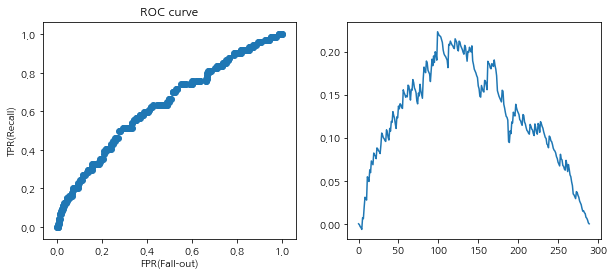

In [57]:
# roc_curve(타겟값, prob of 1)

model = upsampled_model

y_pred_proba = model.predict_proba(X_val)[:, 1]
fpr, tpr, thresholds = roc_curve(y_val, y_pred_proba)

roc = pd.DataFrame({
    'FPR(Fall-out)': fpr, 
    'TPRate(Recall)': tpr, 
    'Threshold': thresholds
})
# print(roc)

# roc 시각화
plt.rcParams["figure.figsize"] = (10,4)
plt.subplot(121)
plt.scatter(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('FPR(Fall-out)')
plt.ylabel('TPR(Recall)');

# threshold 최대값의 인덱스, np.argmax()
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print('idx:', optimal_idx, ', threshold:', optimal_threshold)

# auc 시각화
plt.subplot(122)
plt.plot(tpr-fpr);

# threshold 설정 및 레포트
y_pred_optimal = y_pred_proba >= optimal_threshold
print('Report \n',classification_report(y_val, y_pred_optimal))

# auc 점수
auc_score = roc_auc_score(y_val, y_pred_optimal)
print('최종 검증 정확도: ', accuracy_score(y_val, y_pred_optimal))
print('최종 f1 스코어',f1_score(y_val, y_pred_optimal))
print('최종 auc점수 : ', auc_score)

idx: 165 , threshold: 0.494917642051824
Report 
               precision    recall  f1-score   support

           0       0.94      0.56      0.70      1143
           1       0.11      0.60      0.19       105

    accuracy                           0.56      1248
   macro avg       0.53      0.58      0.45      1248
weighted avg       0.87      0.56      0.66      1248

테스트 정확도 0.6658653846153846
f1 스코어 0.1883408071748879
auc점수 :  0.5808398950131233


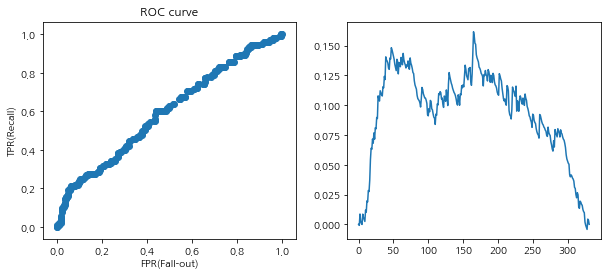

In [58]:
# 테스트 데이터 성능확인
# 파이프라인 빼고 재구성해서 나타냄

model = upsampled_model

# roc_curve(타겟값, prob of 1)
y_pred_proba = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

roc = pd.DataFrame({
    'FPR(Fall-out)': fpr, 
    'TPRate(Recall)': tpr, 
    'Threshold': thresholds
})

# roc 시각화
plt.rcParams["figure.figsize"] = (10,4)
plt.subplot(121)
plt.scatter(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('FPR(Fall-out)')
plt.ylabel('TPR(Recall)');

# 최적의 threshold
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print('idx:', optimal_idx, ', threshold:', optimal_threshold)

# auc 시각화
plt.subplot(122)
plt.plot(tpr-fpr);

# threshold 설정 및 레포트
y_pred_optimal = y_pred_proba >= optimal_threshold
print('Report \n',classification_report(y_test, y_pred_optimal))

# auc 점수
auc_score = roc_auc_score(y_test, y_pred_optimal)
print('테스트 정확도', model.score(X_test, y_test))
print('f1 스코어',f1_score(y_test, y_pred_optimal))
print('auc점수 : ', auc_score)

## 2) Feature Importance

* 트리기반 앙상블모델에서 사용되는 중요도로, 모든 상호학습 후에 특성들의 중요도 정보(Gini importance)를 이용한다.
* 노드들의 지니불순도(Gini Impurity)를 가지고 계산하는데, 노드가 중요할수록 불순도가 크게 감소하는 사실을 이용한다.
* 속도는 빠르지만 high-cardinality특성이 있는 경우, 트리구성 중 분기에 이용될 확률이 높아 과적합의 위험이 있다.

In [59]:
dataaaa=dataaa.drop(['recommendation'],axis=1)

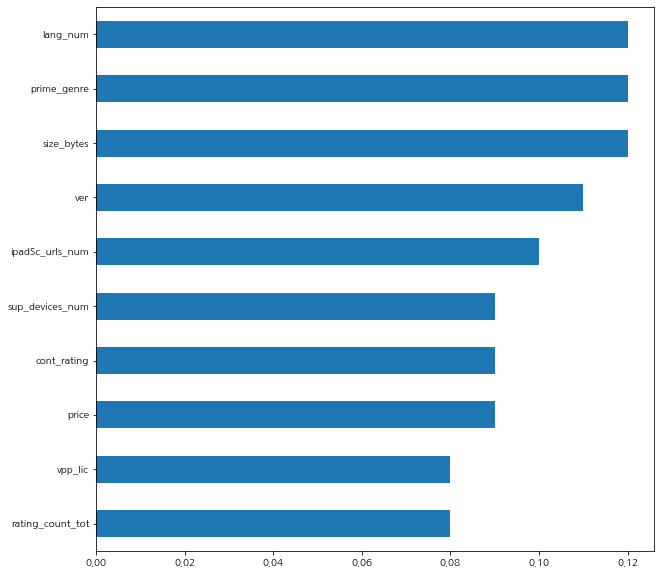

In [60]:
# 특성중요도확인

importances = pd.Series(upsampled_model.feature_importances_, dataaaa.columns)
plt.figure(figsize=(10,10))
importances.sort_values().plot.barh();

## Permutation Importance (순열 중요도)

* 모델 예측에 가장 큰 영향을 미치는 Feature를 파악하기 위해, 모델을 학습시킨 후, 훈련모델이 특정 Feature를 안썼을 때, 성능 손실이 얼마나 영향을 주는지, 변수중요도를 확인하는 방법. 
* high-cardinality의 경우 생기는 문제를 보완하기 위해 관심있는 특성에만 무작위로 노이즈(shuffle, permutation)를 주고, 평가지표가 얼마나 감소하는지 측정.(Black-box모델에 대해서 특정 feature를 안썼을 때, 성능이 얼마만큼 영향을 미치는지 feature의 중요도를 확인.)  


* 장점
* 모델을 재학습시킬 필요가 없다. (feature를 제거하는 대신, 무작위로 섞어(permutation) 노이즈로 만들기 때문에)
* 이렇게 특정 Feature를 섞었을 때, 예측값이 실제값보다 얼마나 차이나는지를 통해 해당 Feature의 영향력을 파악할 수 있다.
* 훈련된 모델이 이 특정 Feature에 크게 의존하고 있을 경우, 예측 정확도는 감소한다.(모델성능이 떨어지면 중요한 Feature)  


* 단점
* feature 값들을 무작위로 섞어 feature간의 연결되는 중요도가 사라지기에, 실행마다 Feature importance 결과가 매우 달라질 수 있고, 비현실적인 데이터 조합이 생성될 가능성이 높다.

In [61]:
# 순열중요도로 중요하지 않은 순서대로 나타냄
# 파이프라인 빼고 재구성해서 나타냄

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# permuter 정의
permuter = PermutationImportance(
    upsampled_model, # model
    scoring='roc_auc', # metric. 
    n_iter=5, # 다른 random seed를 사용하여 5번 반복
    random_state=2)

'''# permuter 계산은 preprocessing 된 X_val을 사용
X_val_transformed = pipe_cat_o.named_steps['preprocessing'].transform(X_val)'''

# 실제로 fit 의미보다는 스코어를 다시 계산하는 작업
permuter.fit(X_val, y_val)

feature_names = X_val.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values()


lang_num           -0.006200
ver                -0.002453
vpp_lic            -0.000271
prime_genre         0.000689
price               0.001397
sup_devices_num     0.001726
cont_rating         0.005266
ipadSc_urls_num     0.014619
size_bytes          0.038449
rating_count_tot    0.043963
dtype: float64

In [62]:
# 특성별 score 확인->ver이 모델에서 가장 높은 특성임을 보여줌
# 3차모델링의 파이프라인으로 나타냄

eli5.show_weights(permuter, top=None,
    feature_names=feature_names 
)

Weight,Feature
0.0440 ± 0.0222,rating_count_tot
0.0384 ± 0.0203,size_bytes
0.0146 ± 0.0105,ipadSc_urls_num
0.0053 ± 0.0186,cont_rating
0.0017 ± 0.0095,sup_devices_num
0.0014 ± 0.0128,price
0.0007 ± 0.0062,prime_genre
-0.0003 ± 0.0014,vpp_lic
-0.0025 ± 0.0200,ver
-0.0062 ± 0.0234,lang_num


* 순열 중요도에 대한 음수 값은 데이터에 대한 예측이 실제 데이터보다 더 정확함을 나타낸다. 
* 이는 특성이 예측에 많은 기여를 하지 않고,(중요도가 0에 가까움) 무작위 우연으로 인해 섞인 데이터에 대한 예측이 더 정확하다는 것을 의미한다.

Feature Importance는 트리기반 앙상블모델에서 사용되는 중요도로 노드가 중요할수록 불순도가 크게 감소하는 특징을 이용하여 중요도를 나타낸 것으로,  
lang_num, prime_genre, size_bytes Feature가 중요함을 보여준다.  
Permutation Importance는 무작위로 섞어 노이즈로 만들기에 예측값과 실제값이 어람나 차이나는지 영향력을 파악하는 것인데,  
rating_count_tot, size_bytes, ipadSc_urls_num의 순으로 중요한 Feature임을 보여준다.

## 4) PDP

* Feature Importance에서 중요한 상위 4가지 Feature에 대해 PDPlot 확인

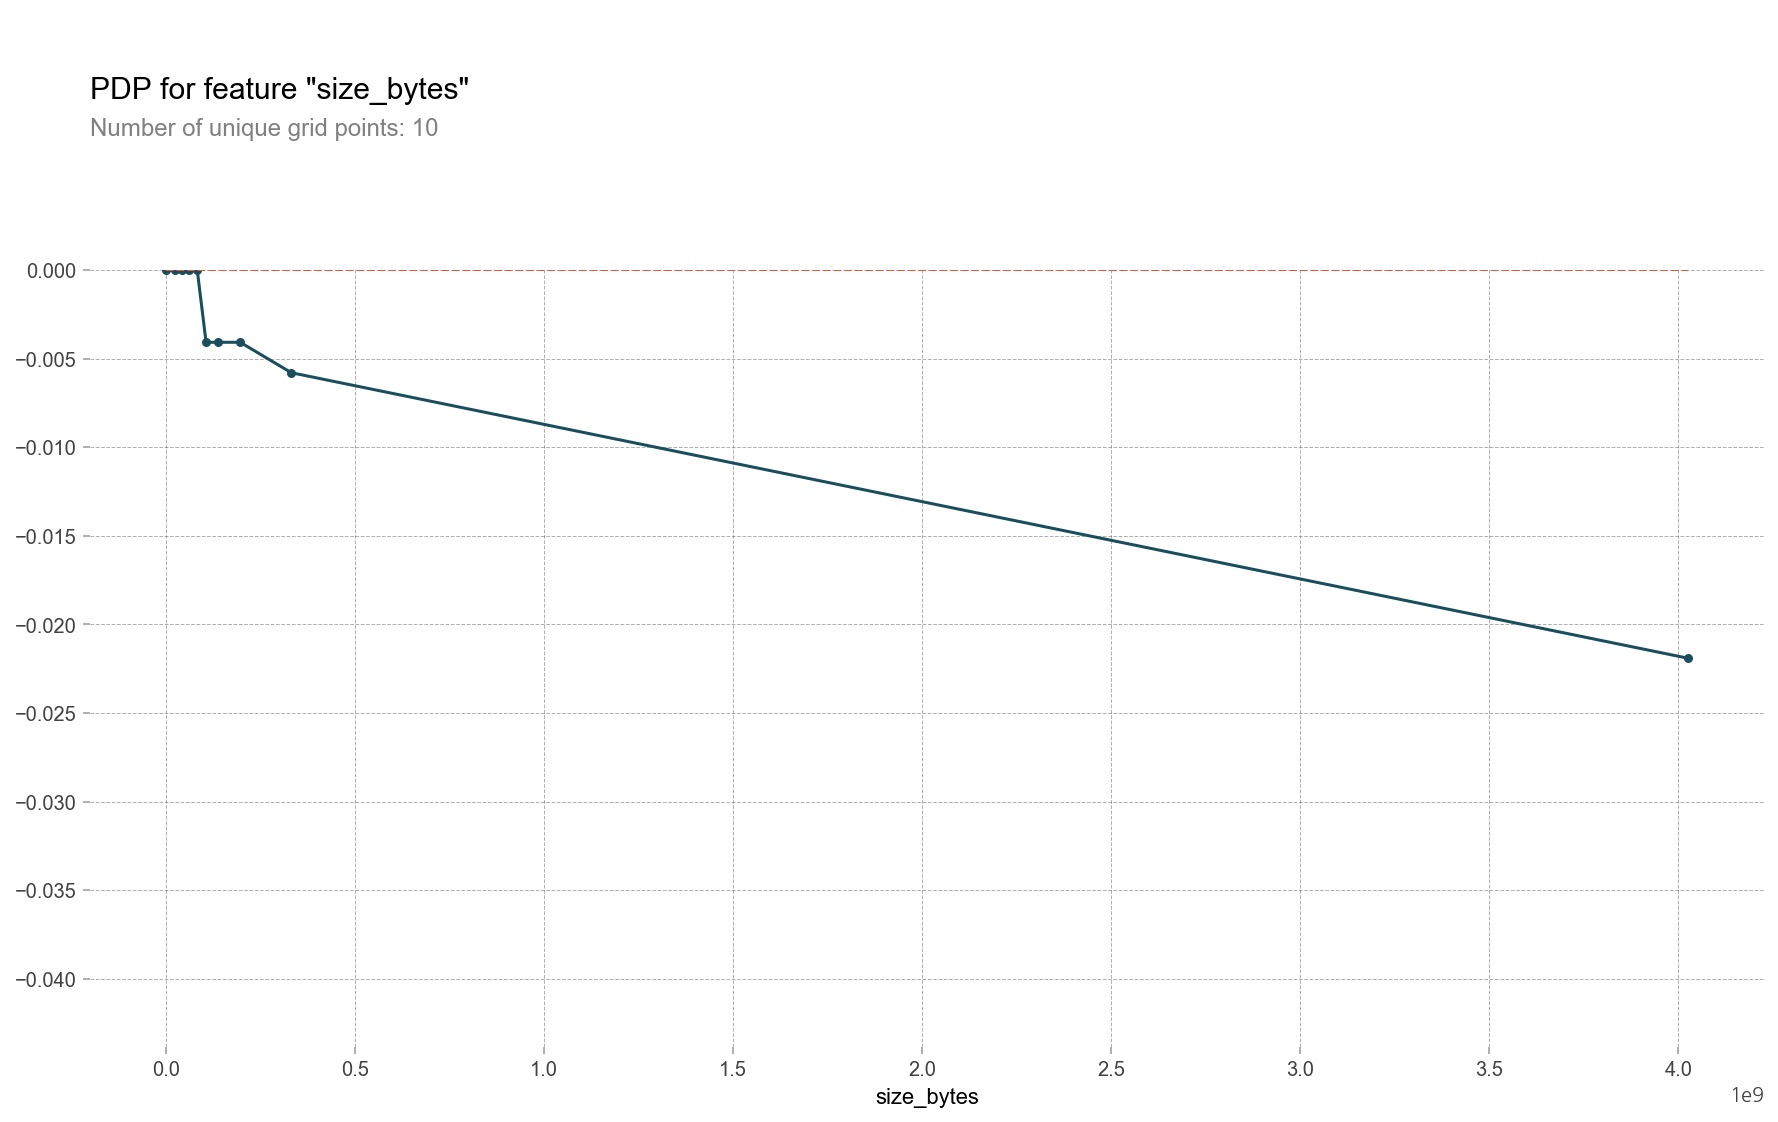

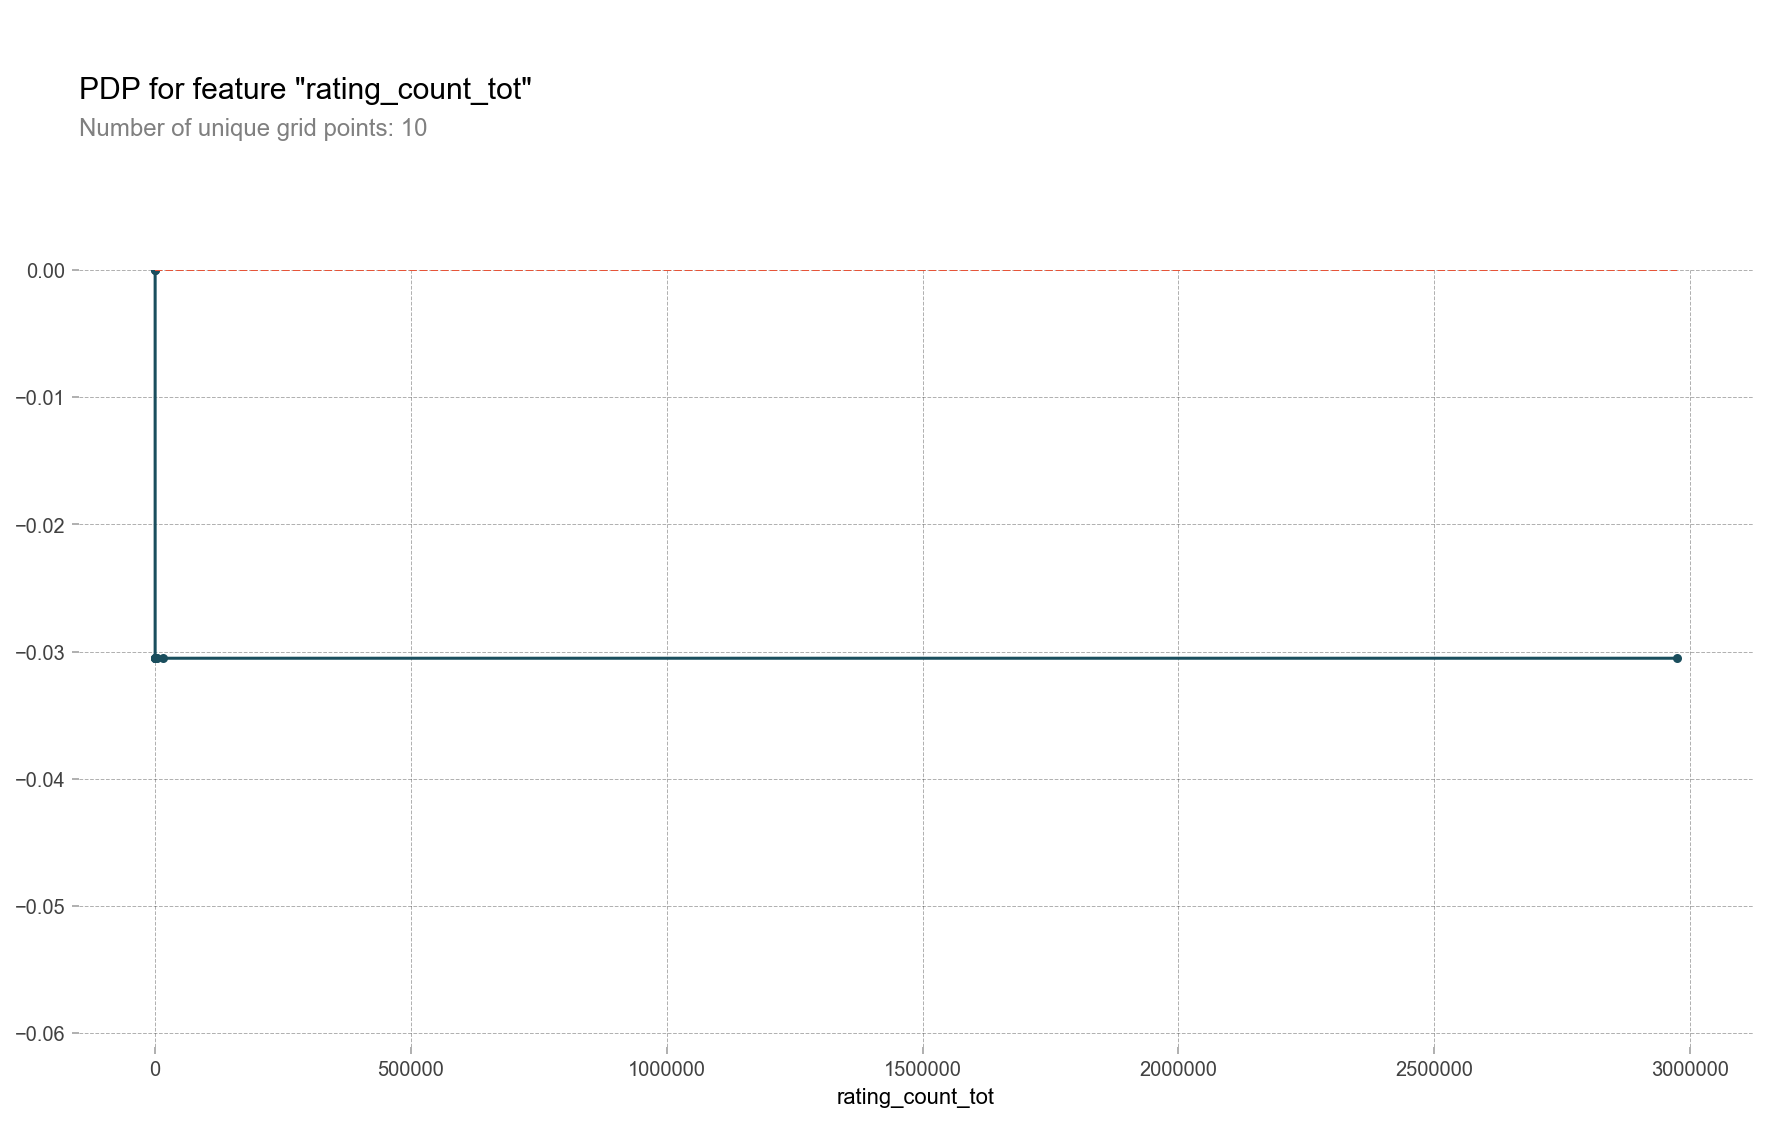

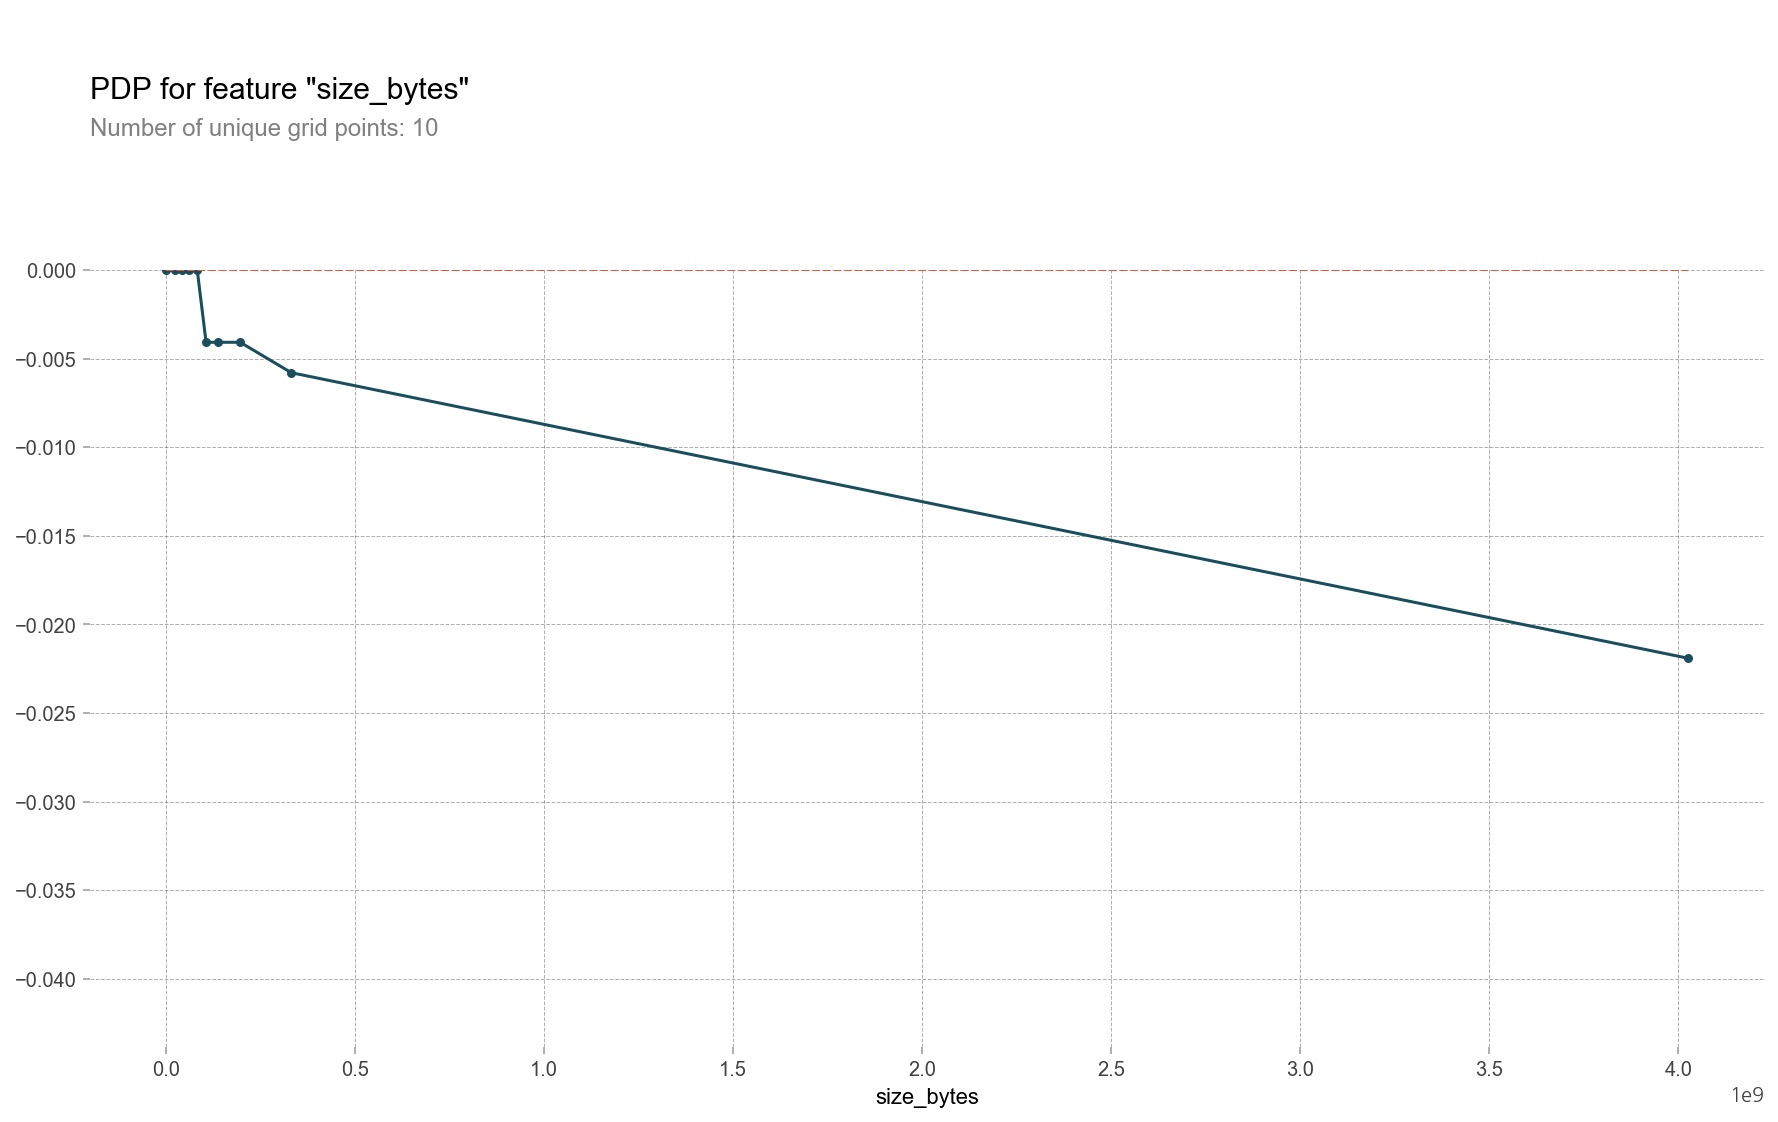

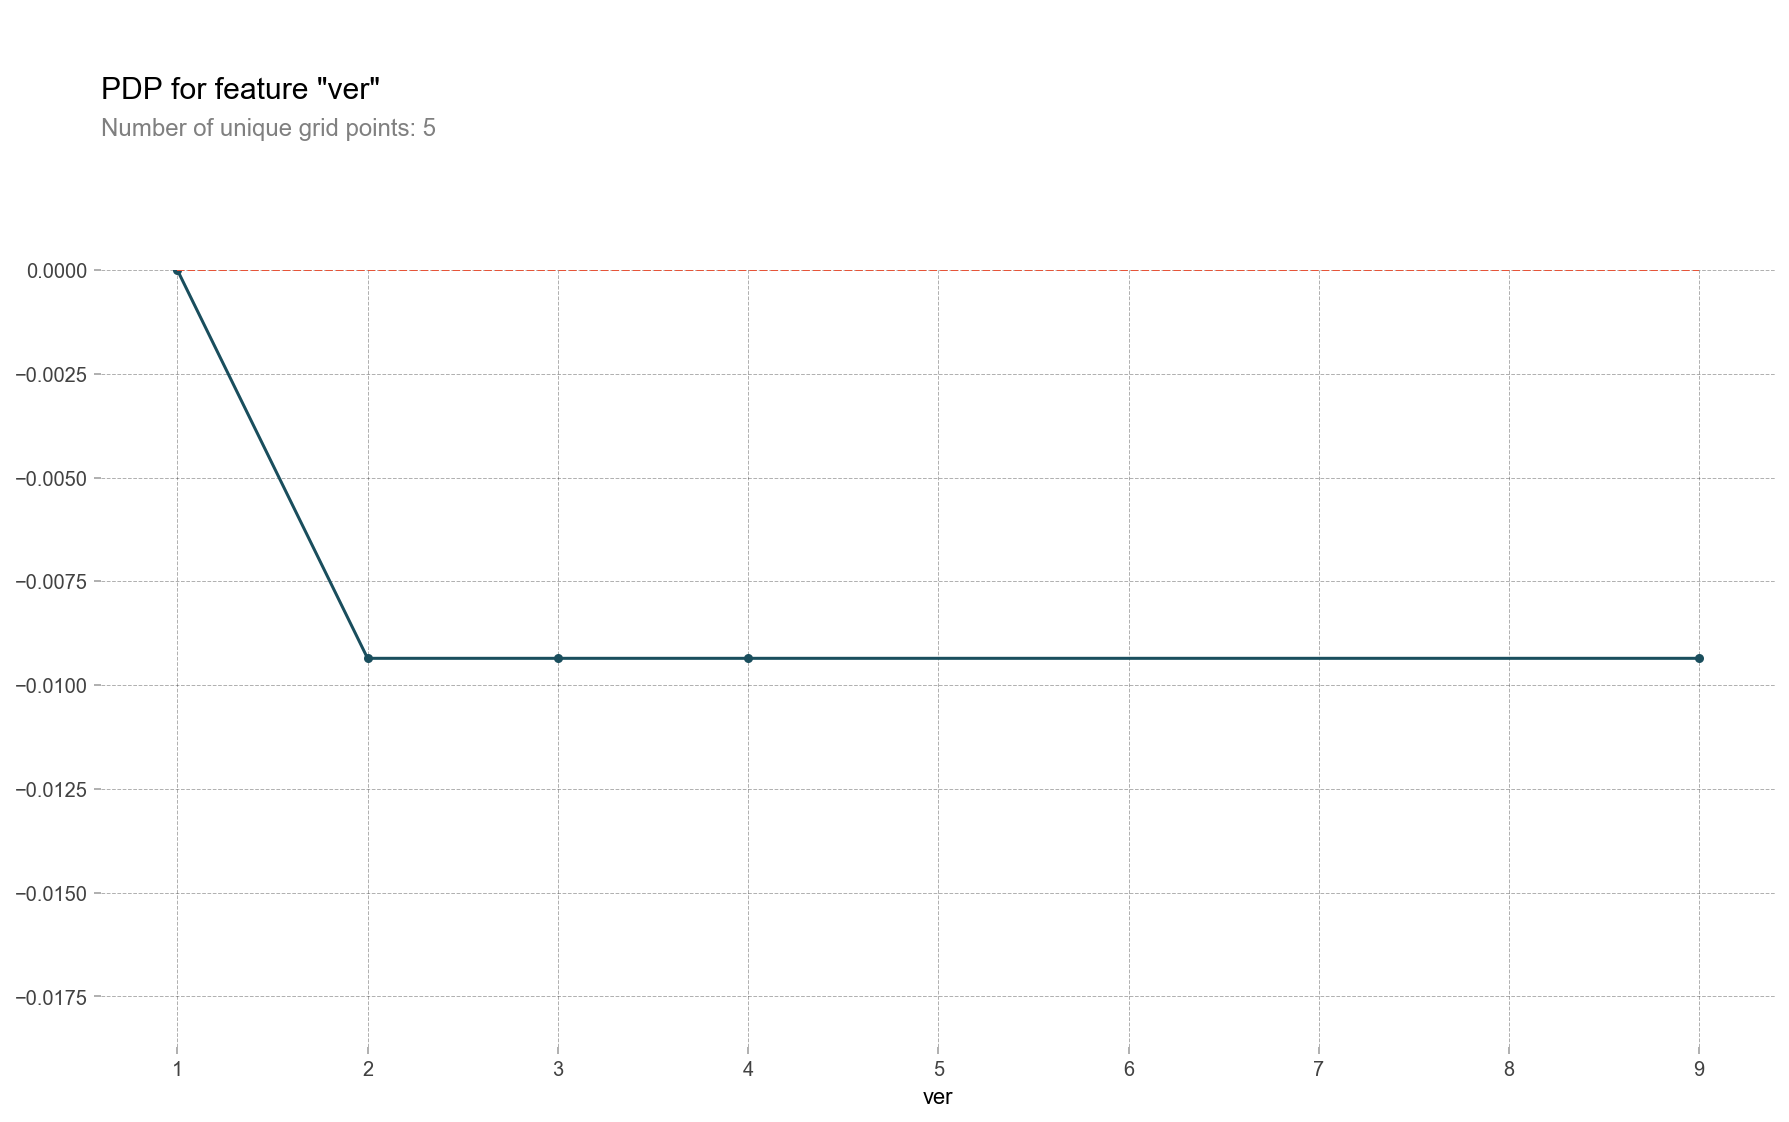

In [63]:
# dpi(dots per inch) 수치조정-> 이미지 화질조정
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 144

for i in ['size_bytes', 'rating_count_tot', 'size_bytes','ver']:
    feature = i
    isolated = pdp_isolate(
        model = upsampled_model,
        dataset=X_train,
        model_features=X_train.columns,
        feature=feature,
        grid_type='percentile',
        num_grid_points=10
        )
    pdp_plot(isolated,feature_name=feature);

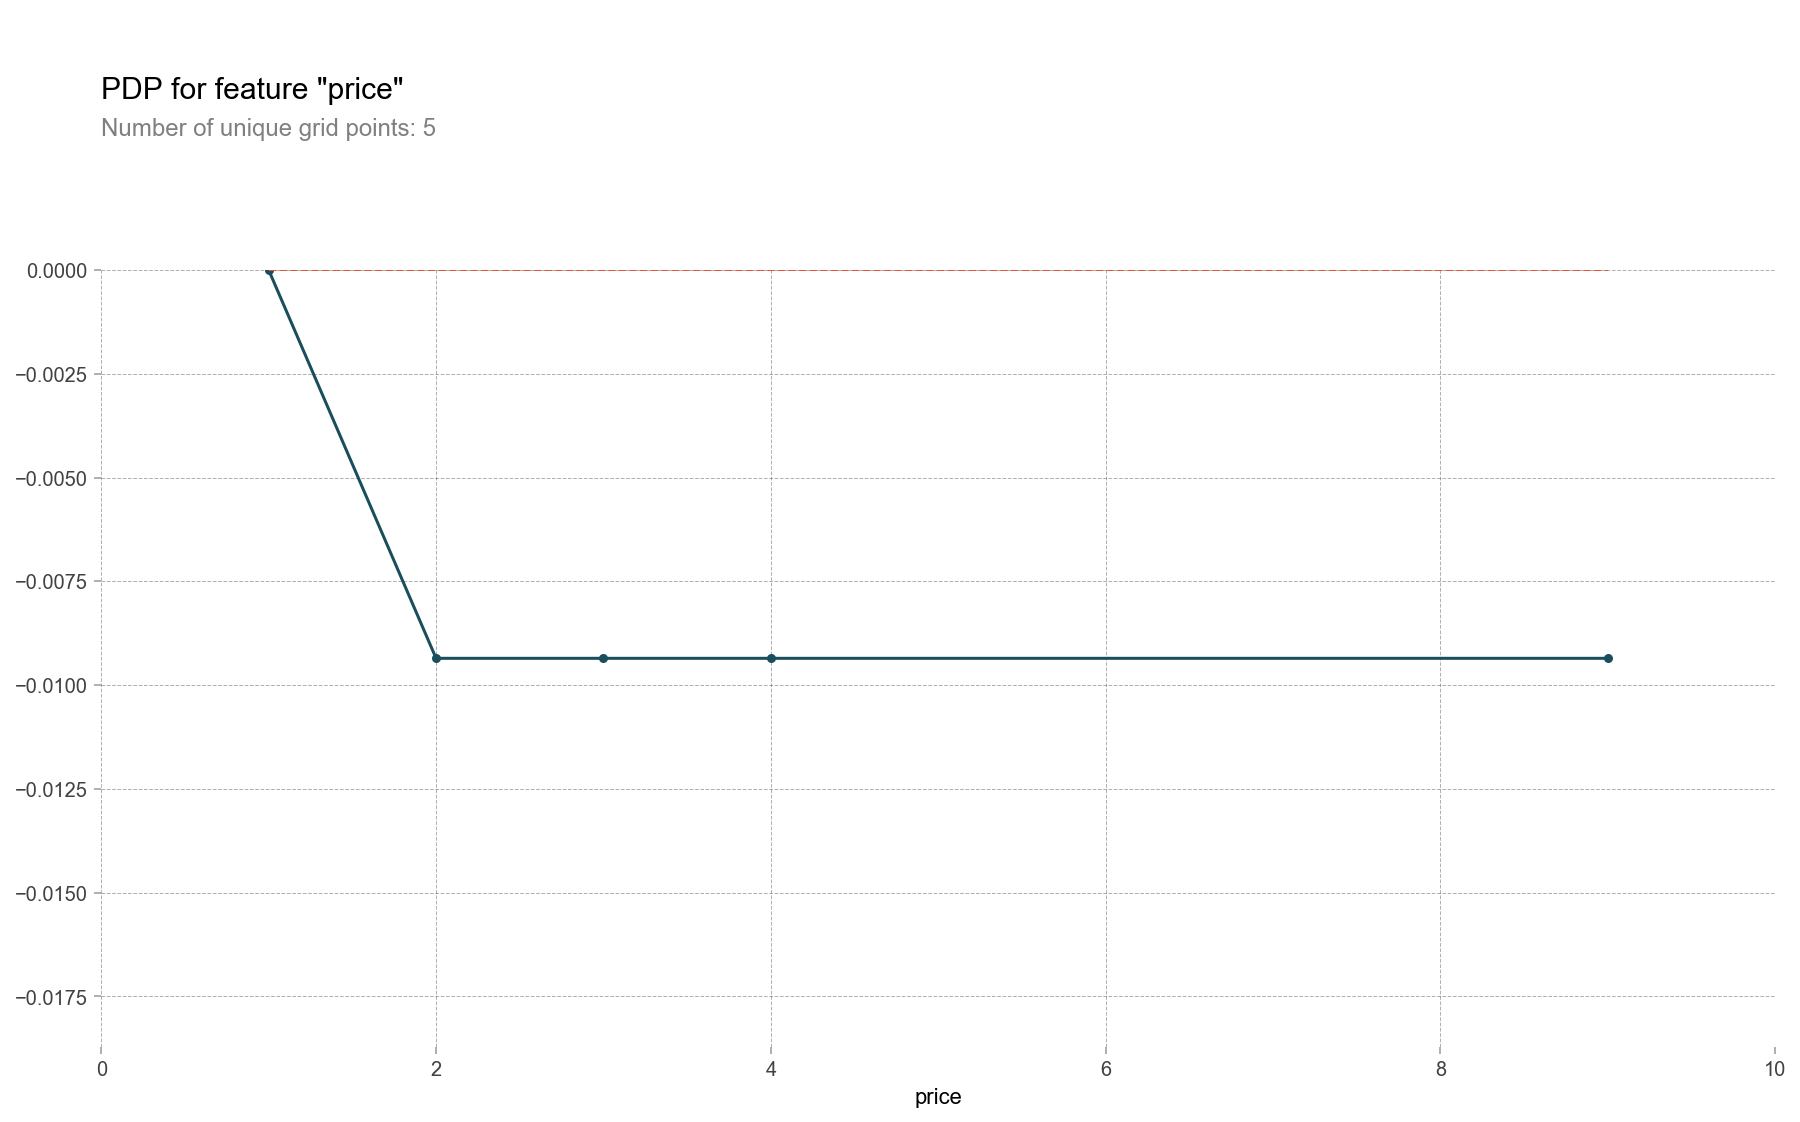

In [64]:
# price 0~10로 확대 
pdp_plot(isolated, feature_name='price')
plt.xlim((0,10));

## 5) 프로젝트 회고

* Feature Importance와 Permutation Importance에서의 특성이 비슷하다고 하기는 어려웠고, PDP에서는 추천이 안 되는 시각화는 나왔지만, 추천되는 부분에 대한 시각화가 잘 나타나지 않았다. 
* Imbalance한 데이터의 모델링에 성능을 높이기 위해 많은 시도를 하였으나, 최종모델에 Test Data를 넣었을 때, AUC Score가 0.58로 마무리 지은 것이 아쉽다.
* 모델의 성능이 좋다고 하기는 어려운데, 이는 데이터 특성의 정보가 부족하기 때문이라고 생각한다.
* 어플의 추천시 특성상 주관적인 판단이 많이 들어가는데, 캐글 데이터로 주관적인 내용을 구분하기는 쉽지 않았다.
* 연령대나 성별 등 이용자의 정보가 추가적으로 특성에 반영된다면 더 좋은 모델링을 할 수 있을 것이라 기대한다.